## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, average_precision_score, balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv

Set plot parameters

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Custom Functions

In [3]:
def my_errors(model, X_test, y_test, skl_api = False):
    if skl_api:
        probs = model.predict_proba(X_test)
    else:
        probs = model.predict(X_test)
    preds = np.asarray([np.argmax(line) for line in probs])
    print("Average Precision Score: {}".format(average_precision_score(y_test, preds)))
    print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(y_test, preds)))
    return probs, preds

In [4]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax, square = True, cmap = 'PuBu', cbar_kws = {'label':'Percentage'}, vmin = 0, vmax = 100) # Change cm_perc to cm if coloring is by %
    
    #!!UNCOMMENT if your mpl is not updated (if cm_analysis output is not square)
#     # fix for mpl bug that cuts off top/bottom of seaborn viz
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values
    
    plt.show()

## Imports

## AutoML: Keras

In [5]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
import autokeras as ak

In [7]:
clf = ak.ImageClassifier(max_trials = 10)
clf.fit(X_train, y_train, epochs = 3)

Train for 1500 steps, validate for 375 steps
Epoch 1/3


 184/1500 [==>...........................] - ETA: 1:12:37 - loss: 2.3084 - accuracy: 0.093 - ETA: 37:36 - loss: 2.3403 - accuracy: 0.0781  - ETA: 25:49 - loss: 2.2705 - accuracy: 0.166 - ETA: 19:59 - loss: 2.2167 - accuracy: 0.226 - ETA: 16:32 - loss: 2.1839 - accuracy: 0.250 - ETA: 14:16 - loss: 2.2017 - accuracy: 0.239 - ETA: 12:36 - loss: 2.1381 - accuracy: 0.267 - ETA: 11:19 - loss: 2.0954 - accuracy: 0.293 - ETA: 10:20 - loss: 2.0580 - accuracy: 0.322 - ETA: 9:35 - loss: 1.9954 - accuracy: 0.368 - ETA: 8:57 - loss: 1.9436 - accuracy: 0.38 - ETA: 8:27 - loss: 1.8872 - accuracy: 0.42 - ETA: 8:00 - loss: 1.8420 - accuracy: 0.44 - ETA: 7:40 - loss: 1.7884 - accuracy: 0.45 - ETA: 7:21 - loss: 1.7325 - accuracy: 0.47 - ETA: 7:02 - loss: 1.7136 - accuracy: 0.48 - ETA: 6:47 - loss: 1.6807 - accuracy: 0.49 - ETA: 6:33 - loss: 1.6266 - accuracy: 0.51 - ETA: 6:23 - loss: 1.5957 - accuracy: 0.52 - ETA: 6:13 - loss: 1.5797 - accuracy: 0.52 - ETA: 6:02 - loss: 1.5522 - accuracy: 0.53 - ETA: 5:5

 556/1500 [==========>...................] - ETA: 2:31 - loss: 0.3527 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3524 - accuracy: 0.89 - ETA: 2:31 - loss: 0.3516 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3510 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3504 - accuracy: 0.89 - ETA: 2:30 - loss: 0.3496 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3490 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3490 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3483 - accuracy: 0.89 - ETA: 2:29 - loss: 0.3475 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3468 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3466 - accuracy: 0.89 - ETA: 2:28 - loss: 0.3459 - accuracy: 0.89 - ETA: 2:27 - loss: 0.3460 - accuracy: 0.89 - ETA: 2:27 - loss: 0.3460 - accuracy: 0.89 - ETA: 2:27 - loss: 0.3453 - accuracy: 0.89 - ETA: 2:27 - loss: 0.3451 - accuracy: 0.89 - ETA: 2:26 - loss: 0.3445 - accuracy: 0.89 - ETA: 2:26 - loss: 0.3440 - accuracy: 0.89 - ETA: 2:26 - loss: 0.3434 - accuracy: 0.89 - ETA: 2:26 - loss: 0.3432 - accuracy: 0.89 - ETA: 2:25 - loss: 0.3427 - accu

 742/1500 [=============>................] - ETA: 1:50 - loss: 0.2854 - accuracy: 0.91 - ETA: 1:50 - loss: 0.2850 - accuracy: 0.91 - ETA: 1:50 - loss: 0.2847 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2846 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2843 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2844 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2842 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2839 - accuracy: 0.91 - ETA: 1:49 - loss: 0.2835 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2832 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2827 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2824 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2821 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2818 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2815 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2811 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2811 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2810 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2806 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2802 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2798 - accuracy: 0.91 - ETA: 1:46 - loss: 0.2795 - accu

 928/1500 [=================>............] - ETA: 1:31 - loss: 0.2424 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2421 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2421 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2418 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2416 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2416 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2419 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2418 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2415 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2416 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2413 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2413 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2410 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2408 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2406 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2404 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2402 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2400 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2396 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2394 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2391 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2389 - accu

1114/1500 [=====================>........] - ETA: 1:05 - loss: 0.2180 - accuracy: 0.93 - ETA: 1:05 - loss: 0.2180 - accuracy: 0.93 - ETA: 1:05 - loss: 0.2179 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2177 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2176 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2175 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2173 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2172 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2171 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2170 - accuracy: 0.93 - ETA: 1:04 - loss: 0.2169 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2169 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2167 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2167 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2167 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2165 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2163 - accuracy: 0.93 - ETA: 1:03 - loss: 0.2161 - accuracy: 0.93 - ETA: 1:02 - loss: 0.2160 - accuracy: 0.93 - ETA: 1:02 - loss: 0.2159 - accuracy: 0.93 - ETA: 1:02 - loss: 0.2158 - accuracy: 0.93 - ETA: 1:02 - loss: 0.2156 - accu

1300/1500 [=========================>....] - ETA: 42s - loss: 0.2009 - accuracy: 0.938 - ETA: 42s - loss: 0.2008 - accuracy: 0.938 - ETA: 41s - loss: 0.2006 - accuracy: 0.938 - ETA: 41s - loss: 0.2005 - accuracy: 0.938 - ETA: 41s - loss: 0.2003 - accuracy: 0.938 - ETA: 41s - loss: 0.2002 - accuracy: 0.939 - ETA: 41s - loss: 0.2002 - accuracy: 0.938 - ETA: 41s - loss: 0.2001 - accuracy: 0.939 - ETA: 41s - loss: 0.1999 - accuracy: 0.939 - ETA: 41s - loss: 0.1998 - accuracy: 0.939 - ETA: 40s - loss: 0.1997 - accuracy: 0.939 - ETA: 40s - loss: 0.1996 - accuracy: 0.939 - ETA: 40s - loss: 0.1996 - accuracy: 0.939 - ETA: 40s - loss: 0.1995 - accuracy: 0.939 - ETA: 40s - loss: 0.1995 - accuracy: 0.939 - ETA: 40s - loss: 0.1993 - accuracy: 0.939 - ETA: 40s - loss: 0.1993 - accuracy: 0.939 - ETA: 40s - loss: 0.1991 - accuracy: 0.939 - ETA: 40s - loss: 0.1992 - accuracy: 0.939 - ETA: 39s - loss: 0.1991 - accuracy: 0.939 - ETA: 39s - loss: 0.1990 - accuracy: 0.939 - ETA: 39s - loss: 0.1988 - accur

1490/1500 [============================>.] - ETA: 21s - loss: 0.1876 - accuracy: 0.942 - ETA: 21s - loss: 0.1875 - accuracy: 0.942 - ETA: 21s - loss: 0.1874 - accuracy: 0.942 - ETA: 20s - loss: 0.1873 - accuracy: 0.942 - ETA: 20s - loss: 0.1872 - accuracy: 0.942 - ETA: 20s - loss: 0.1872 - accuracy: 0.942 - ETA: 20s - loss: 0.1871 - accuracy: 0.942 - ETA: 20s - loss: 0.1870 - accuracy: 0.942 - ETA: 20s - loss: 0.1869 - accuracy: 0.943 - ETA: 20s - loss: 0.1868 - accuracy: 0.943 - ETA: 20s - loss: 0.1867 - accuracy: 0.943 - ETA: 20s - loss: 0.1866 - accuracy: 0.943 - ETA: 19s - loss: 0.1867 - accuracy: 0.943 - ETA: 19s - loss: 0.1866 - accuracy: 0.943 - ETA: 19s - loss: 0.1865 - accuracy: 0.943 - ETA: 19s - loss: 0.1864 - accuracy: 0.943 - ETA: 19s - loss: 0.1864 - accuracy: 0.943 - ETA: 19s - loss: 0.1863 - accuracy: 0.943 - ETA: 19s - loss: 0.1861 - accuracy: 0.943 - ETA: 19s - loss: 0.1861 - accuracy: 0.943 - ETA: 19s - loss: 0.1859 - accuracy: 0.943 - ETA: 18s - loss: 0.1858 - accur

1500/1500 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.94 - ETA: 0s - loss: 0.1771 - accuracy: 0.94 - ETA: 0s - loss: 0.1771 - accuracy: 0.94 - ETA: 0s - loss: 0.1770 - accuracy: 0.94 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1769 - accuracy: 0.94 - ETA: 0s - loss: 0.1768 - accuracy: 0.94 - ETA: 0s - loss: 0.1768 - accuracy: 0.94 - 165s 110ms/step - loss: 0.1767 - accuracy: 0.9461 - val_loss: 0.0627 - val_accuracy: 0.9826
Epoch 2/3


 186/1500 [==>...........................] - ETA: 18:06 - loss: 0.0483 - accuracy: 0.968 - ETA: 10:04 - loss: 0.0471 - accuracy: 0.984 - ETA: 7:24 - loss: 0.0601 - accuracy: 0.979 - ETA: 6:04 - loss: 0.0479 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0719 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0670 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0661 - accuracy: 0.97 - ETA: 4:03 - loss: 0.0759 - accuracy: 0.97 - ETA: 3:51 - loss: 0.0782 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0736 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0708 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0663 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0644 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0676 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0695 - accuracy: 0.97 - ETA: 3:05 - loss: 0.0905 - accuracy: 0.97 - ETA: 3:01 - loss: 0.0873 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0861 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0841 - accuracy: 0.97 - ETA: 2:53 - loss: 0.0827 - accuracy: 0.97 - ETA: 2:50 - loss: 0.0888 - accuracy: 0.97 - ETA: 2:47 - loss: 0.0866 -

 558/1500 [==========>...................] - ETA: 1:55 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:55 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:55 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:55 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0825 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0825 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0824 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0829 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0827 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0825 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0824 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0823 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0828 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0828 - accu

 744/1500 [=============>................] - ETA: 1:30 - loss: 0.0806 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0807 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0806 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0809 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0809 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0809 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0809 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0809 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0808 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0808 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0807 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0807 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0806 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0804 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0803 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0806 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0805 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0804 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0804 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0803 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0804 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0802 - accu

 930/1500 [=================>............] - ETA: 1:11 - loss: 0.0765 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0766 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0766 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0769 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0768 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0767 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0766 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0766 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0765 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0765 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0764 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0763 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0763 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0763 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0762 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0761 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0760 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0760 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0759 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0758 - accu

1116/1500 [=====================>........] - ETA: 52s - loss: 0.0768 - accuracy: 0.976 - ETA: 52s - loss: 0.0768 - accuracy: 0.976 - ETA: 52s - loss: 0.0769 - accuracy: 0.976 - ETA: 52s - loss: 0.0769 - accuracy: 0.976 - ETA: 52s - loss: 0.0769 - accuracy: 0.976 - ETA: 52s - loss: 0.0769 - accuracy: 0.976 - ETA: 52s - loss: 0.0768 - accuracy: 0.976 - ETA: 52s - loss: 0.0768 - accuracy: 0.976 - ETA: 51s - loss: 0.0768 - accuracy: 0.976 - ETA: 51s - loss: 0.0770 - accuracy: 0.976 - ETA: 51s - loss: 0.0770 - accuracy: 0.976 - ETA: 51s - loss: 0.0769 - accuracy: 0.976 - ETA: 51s - loss: 0.0769 - accuracy: 0.976 - ETA: 51s - loss: 0.0768 - accuracy: 0.976 - ETA: 51s - loss: 0.0767 - accuracy: 0.976 - ETA: 51s - loss: 0.0768 - accuracy: 0.976 - ETA: 51s - loss: 0.0767 - accuracy: 0.976 - ETA: 51s - loss: 0.0767 - accuracy: 0.976 - ETA: 51s - loss: 0.0766 - accuracy: 0.976 - ETA: 50s - loss: 0.0766 - accuracy: 0.976 - ETA: 50s - loss: 0.0765 - accuracy: 0.976 - ETA: 50s - loss: 0.0765 - accur

1302/1500 [=========================>....] - ETA: 35s - loss: 0.0758 - accuracy: 0.976 - ETA: 35s - loss: 0.0758 - accuracy: 0.976 - ETA: 35s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 34s - loss: 0.0757 - accuracy: 0.976 - ETA: 33s - loss: 0.0756 - accuracy: 0.976 - ETA: 33s - loss: 0.0756 - accuracy: 0.976 - ETA: 33s - loss: 0.0757 - accuracy: 0.976 - ETA: 33s - loss: 0.0757 - accuracy: 0.976 - ETA: 33s - loss: 0.0756 - accuracy: 0.976 - ETA: 33s - loss: 0.0756 - accuracy: 0.976 - ETA: 33s - loss: 0.0755 - accuracy: 0.976 - ETA: 33s - loss: 0.0756 - accur

1492/1500 [============================>.] - ETA: 17s - loss: 0.0759 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0757 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 17s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0757 - accuracy: 0.976 - ETA: 16s - loss: 0.0757 - accuracy: 0.976 - ETA: 16s - loss: 0.0757 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0759 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 16s - loss: 0.0758 - accuracy: 0.976 - ETA: 15s - loss: 0.0758 - accur

1500/1500 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0764 - accuracy: 0.97 - 144s 96ms/step - loss: 0.0763 - accuracy: 0.9760 - val_loss: 0.0569 - val_accuracy: 0.9839
Epoch 3/3


 186/1500 [==>...........................] - ETA: 11:34 - loss: 0.0315 - accuracy: 1.000 - ETA: 6:46 - loss: 0.0329 - accuracy: 1.000 - ETA: 5:13 - loss: 0.0796 - accuracy: 0.98 - ETA: 4:25 - loss: 0.0709 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0723 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0646 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0577 - accuracy: 0.99 - ETA: 3:35 - loss: 0.0548 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0529 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0494 - accuracy: 0.99 - ETA: 3:19 - loss: 0.0504 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0492 - accuracy: 0.98 - ETA: 3:10 - loss: 0.0476 - accuracy: 0.98 - ETA: 3:06 - loss: 0.0508 - accuracy: 0.98 - ETA: 3:05 - loss: 0.0477 - accuracy: 0.98 - ETA: 3:03 - loss: 0.0627 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0649 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0635 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0608 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0596 - accuracy: 0.98 - ETA: 2:54 - loss: 0.0580 - accuracy: 0.98 - ETA: 2:52 - loss: 0.0577 - a

 558/1500 [==========>...................] - ETA: 1:40 - loss: 0.0675 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0675 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0673 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0672 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0671 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0671 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0675 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0673 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0672 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0671 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0669 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0666 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0666 - accu

 744/1500 [=============>................] - ETA: 1:24 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:24 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:24 - loss: 0.0648 - accuracy: 0.98 - ETA: 1:24 - loss: 0.0648 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0651 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0650 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0650 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0648 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0647 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0646 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0646 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0648 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0647 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0646 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0646 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0645 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0645 - accuracy: 0.98 - ETA: 1:22 - loss: 0.0644 - accu

 930/1500 [=================>............] - ETA: 1:07 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:07 - loss: 0.0624 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0626 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0626 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0625 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0624 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0624 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0624 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0621 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0620 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0618 - accu

1116/1500 [=====================>........] - ETA: 50s - loss: 0.0631 - accuracy: 0.980 - ETA: 50s - loss: 0.0631 - accuracy: 0.980 - ETA: 50s - loss: 0.0631 - accuracy: 0.980 - ETA: 50s - loss: 0.0630 - accuracy: 0.980 - ETA: 50s - loss: 0.0629 - accuracy: 0.980 - ETA: 50s - loss: 0.0629 - accuracy: 0.980 - ETA: 49s - loss: 0.0630 - accuracy: 0.980 - ETA: 49s - loss: 0.0630 - accuracy: 0.980 - ETA: 49s - loss: 0.0629 - accuracy: 0.980 - ETA: 49s - loss: 0.0632 - accuracy: 0.980 - ETA: 49s - loss: 0.0634 - accuracy: 0.980 - ETA: 49s - loss: 0.0634 - accuracy: 0.980 - ETA: 49s - loss: 0.0634 - accuracy: 0.980 - ETA: 49s - loss: 0.0634 - accuracy: 0.980 - ETA: 49s - loss: 0.0633 - accuracy: 0.980 - ETA: 49s - loss: 0.0632 - accuracy: 0.980 - ETA: 49s - loss: 0.0632 - accuracy: 0.980 - ETA: 48s - loss: 0.0631 - accuracy: 0.980 - ETA: 48s - loss: 0.0631 - accuracy: 0.980 - ETA: 48s - loss: 0.0630 - accuracy: 0.980 - ETA: 48s - loss: 0.0630 - accuracy: 0.980 - ETA: 48s - loss: 0.0630 - accur

1302/1500 [=========================>....] - ETA: 33s - loss: 0.0640 - accuracy: 0.980 - ETA: 33s - loss: 0.0640 - accuracy: 0.980 - ETA: 33s - loss: 0.0639 - accuracy: 0.980 - ETA: 33s - loss: 0.0639 - accuracy: 0.980 - ETA: 33s - loss: 0.0640 - accuracy: 0.980 - ETA: 33s - loss: 0.0639 - accuracy: 0.980 - ETA: 33s - loss: 0.0639 - accuracy: 0.980 - ETA: 33s - loss: 0.0638 - accuracy: 0.980 - ETA: 33s - loss: 0.0638 - accuracy: 0.980 - ETA: 33s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0639 - accuracy: 0.980 - ETA: 32s - loss: 0.0639 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0638 - accuracy: 0.980 - ETA: 32s - loss: 0.0637 - accuracy: 0.980 - ETA: 32s - loss: 0.0637 - accuracy: 0.980 - ETA: 32s - loss: 0.0637 - accuracy: 0.980 - ETA: 31s - loss: 0.0637 - accur

1492/1500 [============================>.] - ETA: 17s - loss: 0.0635 - accuracy: 0.980 - ETA: 17s - loss: 0.0635 - accuracy: 0.980 - ETA: 17s - loss: 0.0634 - accuracy: 0.980 - ETA: 17s - loss: 0.0634 - accuracy: 0.980 - ETA: 17s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0635 - accuracy: 0.980 - ETA: 16s - loss: 0.0635 - accuracy: 0.980 - ETA: 16s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0634 - accuracy: 0.980 - ETA: 16s - loss: 0.0633 - accuracy: 0.980 - ETA: 16s - loss: 0.0633 - accuracy: 0.980 - ETA: 16s - loss: 0.0633 - accuracy: 0.980 - ETA: 16s - loss: 0.0633 - accuracy: 0.980 - ETA: 16s - loss: 0.0633 - accuracy: 0.980 - ETA: 15s - loss: 0.0633 - accuracy: 0.980 - ETA: 15s - loss: 0.0633 - accuracy: 0.980 - ETA: 15s - loss: 0.0632 - accuracy: 0.980 - ETA: 15s - loss: 0.0632 - accuracy: 0.980 - ETA: 15s - loss: 0.0633 - accur

1500/1500 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - ETA: 0s - loss: 0.0630 - accuracy: 0.98 - 146s 97ms/step - loss: 0.0630 - accuracy: 0.9802 - val_loss: 0.0480 - val_accuracy: 0.9860


Train for 1500 steps, validate for 375 steps
Epoch 1/3


 169/1500 [==>...........................] - ETA: 7:52:56 - loss: 3.0507 - accuracy: 0.031 - ETA: 4:35:39 - loss: 2.9044 - accuracy: 0.093 - ETA: 3:27:18 - loss: 2.7413 - accuracy: 0.125 - ETA: 2:53:24 - loss: 2.5093 - accuracy: 0.179 - ETA: 2:32:03 - loss: 2.3929 - accuracy: 0.225 - ETA: 2:18:21 - loss: 2.4415 - accuracy: 0.239 - ETA: 2:08:20 - loss: 2.3123 - accuracy: 0.276 - ETA: 2:02:38 - loss: 2.1631 - accuracy: 0.316 - ETA: 1:56:57 - loss: 2.1200 - accuracy: 0.336 - ETA: 1:52:34 - loss: 2.0271 - accuracy: 0.368 - ETA: 1:48:37 - loss: 1.9081 - accuracy: 0.400 - ETA: 1:45:43 - loss: 1.8234 - accuracy: 0.434 - ETA: 1:43:04 - loss: 1.7923 - accuracy: 0.449 - ETA: 1:40:43 - loss: 1.7722 - accuracy: 0.464 - ETA: 1:38:37 - loss: 1.7406 - accuracy: 0.481 - ETA: 1:36:41 - loss: 1.7438 - accuracy: 0.484 - ETA: 1:35:03 - loss: 1.7472 - accuracy: 0.492 - ETA: 1:33:22 - loss: 1.7586 - accuracy: 0.501 - ETA: 1:32:24 - loss: 1.7249 - accuracy: 0.511 - ETA: 1:31:49 - loss: 1.6860 - accuracy: 0.5

 522/1500 [=========>....................] - ETA: 51:54 - loss: 0.4693 - accuracy: 0.868 - ETA: 51:50 - loss: 0.4683 - accuracy: 0.868 - ETA: 51:47 - loss: 0.4681 - accuracy: 0.868 - ETA: 51:44 - loss: 0.4677 - accuracy: 0.869 - ETA: 51:40 - loss: 0.4670 - accuracy: 0.869 - ETA: 51:37 - loss: 0.4660 - accuracy: 0.869 - ETA: 51:34 - loss: 0.4653 - accuracy: 0.869 - ETA: 51:31 - loss: 0.4644 - accuracy: 0.869 - ETA: 51:28 - loss: 0.4639 - accuracy: 0.869 - ETA: 51:25 - loss: 0.4633 - accuracy: 0.869 - ETA: 51:22 - loss: 0.4625 - accuracy: 0.870 - ETA: 51:19 - loss: 0.4629 - accuracy: 0.870 - ETA: 51:16 - loss: 0.4622 - accuracy: 0.870 - ETA: 51:14 - loss: 0.4616 - accuracy: 0.870 - ETA: 51:11 - loss: 0.4609 - accuracy: 0.870 - ETA: 51:07 - loss: 0.4600 - accuracy: 0.870 - ETA: 51:05 - loss: 0.4597 - accuracy: 0.870 - ETA: 51:02 - loss: 0.4595 - accuracy: 0.870 - ETA: 50:59 - loss: 0.4590 - accuracy: 0.870 - ETA: 50:56 - loss: 0.4586 - accuracy: 0.871 - ETA: 50:53 - loss: 0.4579 - accurac

 700/1500 [=============>................] - ETA: 42:27 - loss: 0.3782 - accuracy: 0.894 - ETA: 42:24 - loss: 0.3786 - accuracy: 0.894 - ETA: 42:21 - loss: 0.3780 - accuracy: 0.894 - ETA: 42:18 - loss: 0.3777 - accuracy: 0.894 - ETA: 42:15 - loss: 0.3773 - accuracy: 0.894 - ETA: 42:12 - loss: 0.3769 - accuracy: 0.894 - ETA: 42:09 - loss: 0.3762 - accuracy: 0.895 - ETA: 42:06 - loss: 0.3756 - accuracy: 0.895 - ETA: 42:03 - loss: 0.3755 - accuracy: 0.895 - ETA: 42:00 - loss: 0.3755 - accuracy: 0.895 - ETA: 41:57 - loss: 0.3752 - accuracy: 0.895 - ETA: 41:54 - loss: 0.3750 - accuracy: 0.895 - ETA: 41:51 - loss: 0.3745 - accuracy: 0.895 - ETA: 41:48 - loss: 0.3740 - accuracy: 0.895 - ETA: 41:45 - loss: 0.3734 - accuracy: 0.895 - ETA: 41:42 - loss: 0.3733 - accuracy: 0.895 - ETA: 41:39 - loss: 0.3731 - accuracy: 0.895 - ETA: 41:36 - loss: 0.3728 - accuracy: 0.895 - ETA: 41:33 - loss: 0.3723 - accuracy: 0.896 - ETA: 41:30 - loss: 0.3717 - accuracy: 0.896 - ETA: 41:27 - loss: 0.3711 - accurac

 878/1500 [================>.............] - ETA: 34:37 - loss: 0.3370 - accuracy: 0.907 - ETA: 34:34 - loss: 0.3374 - accuracy: 0.906 - ETA: 34:31 - loss: 0.3372 - accuracy: 0.907 - ETA: 34:29 - loss: 0.3370 - accuracy: 0.907 - ETA: 34:26 - loss: 0.3371 - accuracy: 0.906 - ETA: 34:23 - loss: 0.3368 - accuracy: 0.907 - ETA: 34:20 - loss: 0.3367 - accuracy: 0.906 - ETA: 34:17 - loss: 0.3364 - accuracy: 0.907 - ETA: 34:15 - loss: 0.3362 - accuracy: 0.907 - ETA: 34:12 - loss: 0.3359 - accuracy: 0.907 - ETA: 34:09 - loss: 0.3355 - accuracy: 0.907 - ETA: 34:07 - loss: 0.3355 - accuracy: 0.907 - ETA: 34:04 - loss: 0.3353 - accuracy: 0.907 - ETA: 34:01 - loss: 0.3352 - accuracy: 0.907 - ETA: 33:58 - loss: 0.3348 - accuracy: 0.907 - ETA: 33:55 - loss: 0.3345 - accuracy: 0.907 - ETA: 33:52 - loss: 0.3341 - accuracy: 0.907 - ETA: 33:50 - loss: 0.3337 - accuracy: 0.907 - ETA: 33:47 - loss: 0.3334 - accuracy: 0.907 - ETA: 33:44 - loss: 0.3330 - accuracy: 0.908 - ETA: 33:41 - loss: 0.3326 - accurac

1056/1500 [====================>.........] - ETA: 26:32 - loss: 0.3019 - accuracy: 0.916 - ETA: 26:30 - loss: 0.3016 - accuracy: 0.916 - ETA: 26:27 - loss: 0.3016 - accuracy: 0.916 - ETA: 26:24 - loss: 0.3013 - accuracy: 0.916 - ETA: 26:22 - loss: 0.3012 - accuracy: 0.916 - ETA: 26:19 - loss: 0.3014 - accuracy: 0.916 - ETA: 26:17 - loss: 0.3012 - accuracy: 0.916 - ETA: 26:14 - loss: 0.3009 - accuracy: 0.916 - ETA: 26:11 - loss: 0.3009 - accuracy: 0.916 - ETA: 26:09 - loss: 0.3007 - accuracy: 0.916 - ETA: 26:06 - loss: 0.3004 - accuracy: 0.917 - ETA: 26:04 - loss: 0.3001 - accuracy: 0.917 - ETA: 26:01 - loss: 0.2999 - accuracy: 0.917 - ETA: 25:59 - loss: 0.2999 - accuracy: 0.917 - ETA: 25:56 - loss: 0.2999 - accuracy: 0.917 - ETA: 25:54 - loss: 0.2998 - accuracy: 0.917 - ETA: 25:52 - loss: 0.2995 - accuracy: 0.917 - ETA: 25:49 - loss: 0.2997 - accuracy: 0.917 - ETA: 25:47 - loss: 0.2995 - accuracy: 0.917 - ETA: 25:44 - loss: 0.2995 - accuracy: 0.917 - ETA: 25:42 - loss: 0.2992 - accurac

1234/1500 [=======================>......] - ETA: 18:24 - loss: 0.2768 - accuracy: 0.923 - ETA: 18:21 - loss: 0.2765 - accuracy: 0.923 - ETA: 18:18 - loss: 0.2763 - accuracy: 0.923 - ETA: 18:15 - loss: 0.2760 - accuracy: 0.923 - ETA: 18:11 - loss: 0.2758 - accuracy: 0.924 - ETA: 18:08 - loss: 0.2756 - accuracy: 0.924 - ETA: 18:05 - loss: 0.2753 - accuracy: 0.924 - ETA: 18:02 - loss: 0.2751 - accuracy: 0.924 - ETA: 17:59 - loss: 0.2750 - accuracy: 0.924 - ETA: 17:56 - loss: 0.2748 - accuracy: 0.924 - ETA: 17:53 - loss: 0.2748 - accuracy: 0.924 - ETA: 17:50 - loss: 0.2746 - accuracy: 0.924 - ETA: 17:47 - loss: 0.2744 - accuracy: 0.924 - ETA: 17:44 - loss: 0.2742 - accuracy: 0.924 - ETA: 17:40 - loss: 0.2740 - accuracy: 0.924 - ETA: 17:37 - loss: 0.2737 - accuracy: 0.924 - ETA: 17:34 - loss: 0.2737 - accuracy: 0.924 - ETA: 17:31 - loss: 0.2735 - accuracy: 0.924 - ETA: 17:28 - loss: 0.2733 - accuracy: 0.924 - ETA: 17:25 - loss: 0.2735 - accuracy: 0.924 - ETA: 17:22 - loss: 0.2743 - accurac

1420/1500 [===========================>..] - ETA: 9:59 - loss: 0.2552 - accuracy: 0.929 - ETA: 9:57 - loss: 0.2553 - accuracy: 0.92 - ETA: 9:54 - loss: 0.2551 - accuracy: 0.92 - ETA: 9:51 - loss: 0.2550 - accuracy: 0.93 - ETA: 9:49 - loss: 0.2549 - accuracy: 0.93 - ETA: 9:46 - loss: 0.2548 - accuracy: 0.93 - ETA: 9:44 - loss: 0.2549 - accuracy: 0.93 - ETA: 9:41 - loss: 0.2547 - accuracy: 0.93 - ETA: 9:39 - loss: 0.2546 - accuracy: 0.93 - ETA: 9:36 - loss: 0.2545 - accuracy: 0.93 - ETA: 9:34 - loss: 0.2543 - accuracy: 0.93 - ETA: 9:31 - loss: 0.2542 - accuracy: 0.93 - ETA: 9:29 - loss: 0.2540 - accuracy: 0.93 - ETA: 9:26 - loss: 0.2539 - accuracy: 0.93 - ETA: 9:24 - loss: 0.2538 - accuracy: 0.93 - ETA: 9:21 - loss: 0.2537 - accuracy: 0.93 - ETA: 9:19 - loss: 0.2535 - accuracy: 0.93 - ETA: 9:16 - loss: 0.2534 - accuracy: 0.93 - ETA: 9:13 - loss: 0.2533 - accuracy: 0.93 - ETA: 9:11 - loss: 0.2531 - accuracy: 0.93 - ETA: 9:08 - loss: 0.2531 - accuracy: 0.93 - ETA: 9:06 - loss: 0.2529 - acc

1500/1500 [==============================] - ETA: 2:44 - loss: 0.2348 - accuracy: 0.93 - ETA: 2:42 - loss: 0.2347 - accuracy: 0.93 - ETA: 2:40 - loss: 0.2347 - accuracy: 0.93 - ETA: 2:38 - loss: 0.2346 - accuracy: 0.93 - ETA: 2:36 - loss: 0.2345 - accuracy: 0.93 - ETA: 2:34 - loss: 0.2346 - accuracy: 0.93 - ETA: 2:32 - loss: 0.2345 - accuracy: 0.93 - ETA: 2:29 - loss: 0.2344 - accuracy: 0.93 - ETA: 2:27 - loss: 0.2343 - accuracy: 0.93 - ETA: 2:25 - loss: 0.2342 - accuracy: 0.93 - ETA: 2:23 - loss: 0.2341 - accuracy: 0.93 - ETA: 2:21 - loss: 0.2341 - accuracy: 0.93 - ETA: 2:19 - loss: 0.2340 - accuracy: 0.93 - ETA: 2:17 - loss: 0.2340 - accuracy: 0.93 - ETA: 2:15 - loss: 0.2339 - accuracy: 0.93 - ETA: 2:12 - loss: 0.2337 - accuracy: 0.93 - ETA: 2:10 - loss: 0.2336 - accuracy: 0.93 - ETA: 2:08 - loss: 0.2335 - accuracy: 0.93 - ETA: 2:06 - loss: 0.2333 - accuracy: 0.93 - ETA: 2:04 - loss: 0.2332 - accuracy: 0.93 - ETA: 2:02 - loss: 0.2332 - accuracy: 0.93 - ETA: 2:00 - loss: 0.2331 - accu

 178/1500 [==>...........................] - ETA: 29:50 - loss: 0.0351 - accuracy: 0.968 - ETA: 28:18 - loss: 0.0869 - accuracy: 0.953 - ETA: 27:06 - loss: 0.1269 - accuracy: 0.958 - ETA: 26:25 - loss: 0.0983 - accuracy: 0.968 - ETA: 25:55 - loss: 0.1245 - accuracy: 0.968 - ETA: 25:39 - loss: 0.1283 - accuracy: 0.968 - ETA: 25:27 - loss: 0.1202 - accuracy: 0.968 - ETA: 25:15 - loss: 0.1093 - accuracy: 0.972 - ETA: 25:06 - loss: 0.1051 - accuracy: 0.972 - ETA: 24:59 - loss: 0.0955 - accuracy: 0.975 - ETA: 24:52 - loss: 0.0926 - accuracy: 0.974 - ETA: 24:50 - loss: 0.0938 - accuracy: 0.974 - ETA: 24:49 - loss: 0.1073 - accuracy: 0.971 - ETA: 24:46 - loss: 0.1134 - accuracy: 0.971 - ETA: 24:42 - loss: 0.1065 - accuracy: 0.972 - ETA: 24:41 - loss: 0.1323 - accuracy: 0.970 - ETA: 24:40 - loss: 0.1258 - accuracy: 0.972 - ETA: 24:37 - loss: 0.1197 - accuracy: 0.974 - ETA: 24:37 - loss: 0.1246 - accuracy: 0.972 - ETA: 24:37 - loss: 0.1327 - accuracy: 0.971 - ETA: 24:33 - loss: 0.1282 - accurac

 534/1500 [=========>....................] - ETA: 18:46 - loss: 0.1118 - accuracy: 0.969 - ETA: 18:46 - loss: 0.1118 - accuracy: 0.969 - ETA: 18:45 - loss: 0.1118 - accuracy: 0.969 - ETA: 18:44 - loss: 0.1117 - accuracy: 0.969 - ETA: 18:43 - loss: 0.1124 - accuracy: 0.968 - ETA: 18:42 - loss: 0.1134 - accuracy: 0.968 - ETA: 18:41 - loss: 0.1137 - accuracy: 0.968 - ETA: 18:40 - loss: 0.1146 - accuracy: 0.968 - ETA: 18:39 - loss: 0.1147 - accuracy: 0.968 - ETA: 18:39 - loss: 0.1149 - accuracy: 0.968 - ETA: 18:38 - loss: 0.1149 - accuracy: 0.968 - ETA: 18:37 - loss: 0.1152 - accuracy: 0.968 - ETA: 18:36 - loss: 0.1153 - accuracy: 0.968 - ETA: 18:35 - loss: 0.1155 - accuracy: 0.968 - ETA: 18:35 - loss: 0.1156 - accuracy: 0.968 - ETA: 18:34 - loss: 0.1157 - accuracy: 0.968 - ETA: 18:32 - loss: 0.1158 - accuracy: 0.968 - ETA: 18:31 - loss: 0.1158 - accuracy: 0.968 - ETA: 18:31 - loss: 0.1155 - accuracy: 0.968 - ETA: 18:30 - loss: 0.1155 - accuracy: 0.968 - ETA: 18:29 - loss: 0.1164 - accurac

 712/1500 [=============>................] - ETA: 16:21 - loss: 0.1310 - accuracy: 0.964 - ETA: 16:20 - loss: 0.1308 - accuracy: 0.964 - ETA: 16:19 - loss: 0.1306 - accuracy: 0.964 - ETA: 16:18 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:17 - loss: 0.1306 - accuracy: 0.964 - ETA: 16:16 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:15 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:14 - loss: 0.1302 - accuracy: 0.964 - ETA: 16:13 - loss: 0.1300 - accuracy: 0.964 - ETA: 16:12 - loss: 0.1300 - accuracy: 0.964 - ETA: 16:11 - loss: 0.1300 - accuracy: 0.964 - ETA: 16:10 - loss: 0.1299 - accuracy: 0.964 - ETA: 16:09 - loss: 0.1301 - accuracy: 0.964 - ETA: 16:08 - loss: 0.1299 - accuracy: 0.964 - ETA: 16:07 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:06 - loss: 0.1308 - accuracy: 0.964 - ETA: 16:05 - loss: 0.1307 - accuracy: 0.964 - ETA: 16:04 - loss: 0.1306 - accuracy: 0.964 - ETA: 16:03 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:02 - loss: 0.1304 - accuracy: 0.964 - ETA: 16:01 - loss: 0.1315 - accurac

 890/1500 [================>.............] - ETA: 13:16 - loss: 0.1248 - accuracy: 0.965 - ETA: 13:15 - loss: 0.1247 - accuracy: 0.965 - ETA: 13:14 - loss: 0.1246 - accuracy: 0.965 - ETA: 13:13 - loss: 0.1248 - accuracy: 0.965 - ETA: 13:12 - loss: 0.1246 - accuracy: 0.965 - ETA: 13:11 - loss: 0.1244 - accuracy: 0.965 - ETA: 13:10 - loss: 0.1243 - accuracy: 0.965 - ETA: 13:09 - loss: 0.1242 - accuracy: 0.965 - ETA: 13:08 - loss: 0.1240 - accuracy: 0.965 - ETA: 13:07 - loss: 0.1243 - accuracy: 0.965 - ETA: 13:05 - loss: 0.1242 - accuracy: 0.965 - ETA: 13:04 - loss: 0.1240 - accuracy: 0.965 - ETA: 13:03 - loss: 0.1239 - accuracy: 0.965 - ETA: 13:02 - loss: 0.1240 - accuracy: 0.965 - ETA: 13:01 - loss: 0.1238 - accuracy: 0.965 - ETA: 13:00 - loss: 0.1237 - accuracy: 0.966 - ETA: 12:59 - loss: 0.1235 - accuracy: 0.966 - ETA: 12:58 - loss: 0.1235 - accuracy: 0.966 - ETA: 12:57 - loss: 0.1234 - accuracy: 0.966 - ETA: 12:56 - loss: 0.1234 - accuracy: 0.966 - ETA: 12:55 - loss: 0.1233 - accurac

1075/1500 [====================>.........] - ETA: 10:08 - loss: 0.1240 - accuracy: 0.967 - ETA: 10:07 - loss: 0.1239 - accuracy: 0.967 - ETA: 10:06 - loss: 0.1241 - accuracy: 0.967 - ETA: 10:05 - loss: 0.1241 - accuracy: 0.967 - ETA: 10:04 - loss: 0.1240 - accuracy: 0.967 - ETA: 10:03 - loss: 0.1241 - accuracy: 0.967 - ETA: 10:02 - loss: 0.1239 - accuracy: 0.967 - ETA: 10:01 - loss: 0.1240 - accuracy: 0.967 - ETA: 10:00 - loss: 0.1239 - accuracy: 0.967 - ETA: 9:59 - loss: 0.1242 - accuracy: 0.967 - ETA: 9:58 - loss: 0.1241 - accuracy: 0.96 - ETA: 9:57 - loss: 0.1240 - accuracy: 0.96 - ETA: 9:56 - loss: 0.1239 - accuracy: 0.96 - ETA: 9:55 - loss: 0.1238 - accuracy: 0.96 - ETA: 9:54 - loss: 0.1242 - accuracy: 0.96 - ETA: 9:53 - loss: 0.1242 - accuracy: 0.96 - ETA: 9:52 - loss: 0.1241 - accuracy: 0.96 - ETA: 9:51 - loss: 0.1241 - accuracy: 0.96 - ETA: 9:50 - loss: 0.1241 - accuracy: 0.96 - ETA: 9:49 - loss: 0.1240 - accuracy: 0.96 - ETA: 9:48 - loss: 0.1241 - accuracy: 0.96 - ETA: 9:47 - 

1261/1500 [========================>.....] - ETA: 7:00 - loss: 0.1200 - accuracy: 0.96 - ETA: 6:59 - loss: 0.1200 - accuracy: 0.96 - ETA: 6:58 - loss: 0.1200 - accuracy: 0.96 - ETA: 6:57 - loss: 0.1200 - accuracy: 0.96 - ETA: 6:56 - loss: 0.1199 - accuracy: 0.96 - ETA: 6:55 - loss: 0.1198 - accuracy: 0.96 - ETA: 6:54 - loss: 0.1197 - accuracy: 0.96 - ETA: 6:53 - loss: 0.1199 - accuracy: 0.96 - ETA: 6:52 - loss: 0.1202 - accuracy: 0.96 - ETA: 6:51 - loss: 0.1201 - accuracy: 0.96 - ETA: 6:50 - loss: 0.1204 - accuracy: 0.96 - ETA: 6:49 - loss: 0.1204 - accuracy: 0.96 - ETA: 6:48 - loss: 0.1204 - accuracy: 0.96 - ETA: 6:47 - loss: 0.1204 - accuracy: 0.96 - ETA: 6:46 - loss: 0.1203 - accuracy: 0.96 - ETA: 6:45 - loss: 0.1203 - accuracy: 0.96 - ETA: 6:44 - loss: 0.1203 - accuracy: 0.96 - ETA: 6:43 - loss: 0.1203 - accuracy: 0.96 - ETA: 6:42 - loss: 0.1202 - accuracy: 0.96 - ETA: 6:41 - loss: 0.1201 - accuracy: 0.96 - ETA: 6:40 - loss: 0.1201 - accuracy: 0.96 - ETA: 6:39 - loss: 0.1200 - accu

1447/1500 [===========================>..] - ETA: 3:54 - loss: 0.1167 - accuracy: 0.96 - ETA: 3:53 - loss: 0.1169 - accuracy: 0.96 - ETA: 3:52 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:51 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:50 - loss: 0.1167 - accuracy: 0.96 - ETA: 3:49 - loss: 0.1169 - accuracy: 0.96 - ETA: 3:48 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:47 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:46 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:44 - loss: 0.1169 - accuracy: 0.96 - ETA: 3:43 - loss: 0.1168 - accuracy: 0.96 - ETA: 3:42 - loss: 0.1171 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1170 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1171 - accuracy: 0.96 - ETA: 3:39 - loss: 0.1170 - accuracy: 0.96 - ETA: 3:38 - loss: 0.1170 - accuracy: 0.96 - ETA: 3:37 - loss: 0.1169 - accuracy: 0.96 - ETA: 3:36 - loss: 0.1170 - accuracy: 0.96 - ETA: 3:35 - loss: 0.1171 - accuracy: 0.96 - ETA: 3:34 - loss: 0.1171 - accuracy: 0.96 - ETA: 3:33 - loss: 0.1170 - accu

1500/1500 [==============================] - ETA: 50s - loss: 0.1144 - accuracy: 0.969 - ETA: 49s - loss: 0.1144 - accuracy: 0.969 - ETA: 48s - loss: 0.1144 - accuracy: 0.969 - ETA: 47s - loss: 0.1144 - accuracy: 0.969 - ETA: 46s - loss: 0.1143 - accuracy: 0.969 - ETA: 45s - loss: 0.1143 - accuracy: 0.969 - ETA: 44s - loss: 0.1142 - accuracy: 0.969 - ETA: 43s - loss: 0.1141 - accuracy: 0.969 - ETA: 43s - loss: 0.1141 - accuracy: 0.969 - ETA: 42s - loss: 0.1140 - accuracy: 0.969 - ETA: 41s - loss: 0.1139 - accuracy: 0.969 - ETA: 40s - loss: 0.1138 - accuracy: 0.969 - ETA: 39s - loss: 0.1138 - accuracy: 0.970 - ETA: 38s - loss: 0.1138 - accuracy: 0.969 - ETA: 37s - loss: 0.1138 - accuracy: 0.970 - ETA: 36s - loss: 0.1137 - accuracy: 0.970 - ETA: 35s - loss: 0.1136 - accuracy: 0.970 - ETA: 34s - loss: 0.1137 - accuracy: 0.970 - ETA: 33s - loss: 0.1136 - accuracy: 0.970 - ETA: 32s - loss: 0.1135 - accuracy: 0.970 - ETA: 31s - loss: 0.1135 - accuracy: 0.970 - ETA: 30s - loss: 0.1135 - accur

 178/1500 [==>...........................] - ETA: 30:21 - loss: 0.0344 - accuracy: 0.968 - ETA: 27:31 - loss: 0.1704 - accuracy: 0.937 - ETA: 26:02 - loss: 0.1814 - accuracy: 0.947 - ETA: 25:29 - loss: 0.1373 - accuracy: 0.960 - ETA: 25:13 - loss: 0.1397 - accuracy: 0.962 - ETA: 24:58 - loss: 0.1273 - accuracy: 0.958 - ETA: 24:41 - loss: 0.1164 - accuracy: 0.959 - ETA: 24:32 - loss: 0.1049 - accuracy: 0.964 - ETA: 24:22 - loss: 0.0977 - accuracy: 0.968 - ETA: 24:09 - loss: 0.0911 - accuracy: 0.968 - ETA: 24:06 - loss: 0.0940 - accuracy: 0.968 - ETA: 24:22 - loss: 0.0874 - accuracy: 0.971 - ETA: 24:40 - loss: 0.0885 - accuracy: 0.971 - ETA: 24:34 - loss: 0.0868 - accuracy: 0.971 - ETA: 24:25 - loss: 0.0815 - accuracy: 0.972 - ETA: 24:17 - loss: 0.1200 - accuracy: 0.970 - ETA: 24:11 - loss: 0.1157 - accuracy: 0.970 - ETA: 24:09 - loss: 0.1121 - accuracy: 0.972 - ETA: 24:06 - loss: 0.1072 - accuracy: 0.973 - ETA: 24:02 - loss: 0.1093 - accuracy: 0.973 - ETA: 23:58 - loss: 0.1044 - accurac

 534/1500 [=========>....................] - ETA: 17:44 - loss: 0.0907 - accuracy: 0.975 - ETA: 17:43 - loss: 0.0911 - accuracy: 0.975 - ETA: 17:42 - loss: 0.0909 - accuracy: 0.975 - ETA: 17:41 - loss: 0.0909 - accuracy: 0.975 - ETA: 17:40 - loss: 0.0908 - accuracy: 0.975 - ETA: 17:40 - loss: 0.0910 - accuracy: 0.975 - ETA: 17:39 - loss: 0.0910 - accuracy: 0.975 - ETA: 17:38 - loss: 0.0908 - accuracy: 0.975 - ETA: 17:38 - loss: 0.0906 - accuracy: 0.975 - ETA: 17:37 - loss: 0.0906 - accuracy: 0.975 - ETA: 17:36 - loss: 0.0903 - accuracy: 0.975 - ETA: 17:35 - loss: 0.0901 - accuracy: 0.975 - ETA: 17:34 - loss: 0.0903 - accuracy: 0.975 - ETA: 17:34 - loss: 0.0901 - accuracy: 0.975 - ETA: 17:33 - loss: 0.0899 - accuracy: 0.975 - ETA: 17:32 - loss: 0.0898 - accuracy: 0.975 - ETA: 17:31 - loss: 0.0896 - accuracy: 0.975 - ETA: 17:31 - loss: 0.0893 - accuracy: 0.975 - ETA: 17:30 - loss: 0.0891 - accuracy: 0.975 - ETA: 17:29 - loss: 0.0894 - accuracy: 0.975 - ETA: 17:28 - loss: 0.0893 - accurac

 712/1500 [=============>................] - ETA: 15:09 - loss: 0.0799 - accuracy: 0.978 - ETA: 15:08 - loss: 0.0798 - accuracy: 0.978 - ETA: 15:07 - loss: 0.0797 - accuracy: 0.978 - ETA: 15:06 - loss: 0.0796 - accuracy: 0.978 - ETA: 15:05 - loss: 0.0797 - accuracy: 0.978 - ETA: 15:04 - loss: 0.0796 - accuracy: 0.978 - ETA: 15:03 - loss: 0.0794 - accuracy: 0.978 - ETA: 15:02 - loss: 0.0793 - accuracy: 0.978 - ETA: 15:01 - loss: 0.0792 - accuracy: 0.978 - ETA: 15:00 - loss: 0.0792 - accuracy: 0.978 - ETA: 14:59 - loss: 0.0791 - accuracy: 0.978 - ETA: 14:58 - loss: 0.0792 - accuracy: 0.978 - ETA: 14:57 - loss: 0.0792 - accuracy: 0.978 - ETA: 14:56 - loss: 0.0793 - accuracy: 0.978 - ETA: 14:56 - loss: 0.0796 - accuracy: 0.978 - ETA: 14:55 - loss: 0.0797 - accuracy: 0.978 - ETA: 14:54 - loss: 0.0795 - accuracy: 0.978 - ETA: 14:53 - loss: 0.0795 - accuracy: 0.978 - ETA: 14:52 - loss: 0.0794 - accuracy: 0.978 - ETA: 14:51 - loss: 0.0794 - accuracy: 0.978 - ETA: 14:50 - loss: 0.0800 - accurac

 891/1500 [================>.............] - ETA: 12:20 - loss: 0.0779 - accuracy: 0.978 - ETA: 12:19 - loss: 0.0779 - accuracy: 0.978 - ETA: 12:19 - loss: 0.0778 - accuracy: 0.978 - ETA: 12:18 - loss: 0.0777 - accuracy: 0.978 - ETA: 12:17 - loss: 0.0776 - accuracy: 0.978 - ETA: 12:16 - loss: 0.0775 - accuracy: 0.978 - ETA: 12:15 - loss: 0.0774 - accuracy: 0.978 - ETA: 12:14 - loss: 0.0774 - accuracy: 0.978 - ETA: 12:13 - loss: 0.0773 - accuracy: 0.978 - ETA: 12:12 - loss: 0.0774 - accuracy: 0.978 - ETA: 12:11 - loss: 0.0774 - accuracy: 0.978 - ETA: 12:10 - loss: 0.0773 - accuracy: 0.978 - ETA: 12:09 - loss: 0.0772 - accuracy: 0.978 - ETA: 12:08 - loss: 0.0771 - accuracy: 0.978 - ETA: 12:07 - loss: 0.0770 - accuracy: 0.978 - ETA: 12:06 - loss: 0.0769 - accuracy: 0.978 - ETA: 12:05 - loss: 0.0768 - accuracy: 0.979 - ETA: 12:04 - loss: 0.0767 - accuracy: 0.979 - ETA: 12:04 - loss: 0.0768 - accuracy: 0.979 - ETA: 12:03 - loss: 0.0768 - accuracy: 0.979 - ETA: 12:02 - loss: 0.0767 - accurac

1077/1500 [====================>.........] - ETA: 9:32 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:31 - loss: 0.0766 - accuracy: 0.97 - ETA: 9:30 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:29 - loss: 0.0764 - accuracy: 0.97 - ETA: 9:28 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:27 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:26 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:25 - loss: 0.0764 - accuracy: 0.97 - ETA: 9:24 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:23 - loss: 0.0765 - accuracy: 0.97 - ETA: 9:22 - loss: 0.0764 - accuracy: 0.97 - ETA: 9:21 - loss: 0.0764 - accuracy: 0.97 - ETA: 9:20 - loss: 0.0764 - accuracy: 0.97 - ETA: 9:20 - loss: 0.0793 - accuracy: 0.97 - ETA: 9:19 - loss: 0.0793 - accuracy: 0.97 - ETA: 9:18 - loss: 0.0800 - accuracy: 0.97 - ETA: 9:17 - loss: 0.0800 - accuracy: 0.97 - ETA: 9:16 - loss: 0.0807 - accuracy: 0.97 - ETA: 9:15 - loss: 0.0806 - accuracy: 0.97 - ETA: 9:14 - loss: 0.0807 - accuracy: 0.97 - ETA: 9:13 - loss: 0.0807 - accuracy: 0.97 - ETA: 9:12 - loss: 0.0807 - accu

1263/1500 [========================>.....] - ETA: 6:36 - loss: 0.0850 - accuracy: 0.97 - ETA: 6:35 - loss: 0.0852 - accuracy: 0.97 - ETA: 6:34 - loss: 0.0852 - accuracy: 0.97 - ETA: 6:33 - loss: 0.0851 - accuracy: 0.97 - ETA: 6:32 - loss: 0.0852 - accuracy: 0.97 - ETA: 6:32 - loss: 0.0854 - accuracy: 0.97 - ETA: 6:31 - loss: 0.0859 - accuracy: 0.97 - ETA: 6:30 - loss: 0.0858 - accuracy: 0.97 - ETA: 6:29 - loss: 0.0861 - accuracy: 0.97 - ETA: 6:28 - loss: 0.0862 - accuracy: 0.97 - ETA: 6:27 - loss: 0.0862 - accuracy: 0.97 - ETA: 6:26 - loss: 0.0863 - accuracy: 0.97 - ETA: 6:25 - loss: 0.0862 - accuracy: 0.97 - ETA: 6:24 - loss: 0.0862 - accuracy: 0.97 - ETA: 6:23 - loss: 0.0862 - accuracy: 0.97 - ETA: 6:22 - loss: 0.0861 - accuracy: 0.97 - ETA: 6:21 - loss: 0.0860 - accuracy: 0.97 - ETA: 6:20 - loss: 0.0860 - accuracy: 0.97 - ETA: 6:19 - loss: 0.0867 - accuracy: 0.97 - ETA: 6:18 - loss: 0.0866 - accuracy: 0.97 - ETA: 6:17 - loss: 0.0867 - accuracy: 0.97 - ETA: 6:16 - loss: 0.0868 - accu

1449/1500 [===========================>..] - ETA: 3:43 - loss: 0.0899 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0899 - accuracy: 0.97 - ETA: 3:41 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0896 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0896 - accuracy: 0.97 - ETA: 3:33 - loss: 0.0896 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:30 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0899 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0898 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0897 - accu

1500/1500 [==============================] - ETA: 47s - loss: 0.0879 - accuracy: 0.976 - ETA: 46s - loss: 0.0879 - accuracy: 0.976 - ETA: 45s - loss: 0.0878 - accuracy: 0.976 - ETA: 44s - loss: 0.0878 - accuracy: 0.976 - ETA: 43s - loss: 0.0877 - accuracy: 0.976 - ETA: 42s - loss: 0.0877 - accuracy: 0.976 - ETA: 41s - loss: 0.0876 - accuracy: 0.976 - ETA: 40s - loss: 0.0875 - accuracy: 0.976 - ETA: 39s - loss: 0.0875 - accuracy: 0.976 - ETA: 38s - loss: 0.0874 - accuracy: 0.976 - ETA: 37s - loss: 0.0874 - accuracy: 0.976 - ETA: 36s - loss: 0.0875 - accuracy: 0.976 - ETA: 35s - loss: 0.0875 - accuracy: 0.976 - ETA: 34s - loss: 0.0875 - accuracy: 0.976 - ETA: 34s - loss: 0.0874 - accuracy: 0.976 - ETA: 33s - loss: 0.0874 - accuracy: 0.976 - ETA: 32s - loss: 0.0874 - accuracy: 0.976 - ETA: 31s - loss: 0.0873 - accuracy: 0.976 - ETA: 30s - loss: 0.0873 - accuracy: 0.976 - ETA: 29s - loss: 0.0873 - accuracy: 0.976 - ETA: 28s - loss: 0.0873 - accuracy: 0.976 - ETA: 27s - loss: 0.0873 - accur

Train for 1500 steps, validate for 375 steps
Epoch 1/3


 367/1500 [======>.......................] - ETA: 11:14 - loss: 2.3148 - accuracy: 0.093 - ETA: 4:12 - loss: 2.2551 - accuracy: 0.145 - ETA: 2:48 - loss: 2.1622 - accuracy: 0.21 - ETA: 2:12 - loss: 2.0626 - accuracy: 0.29 - ETA: 1:52 - loss: 1.9558 - accuracy: 0.37 - ETA: 1:40 - loss: 1.8279 - accuracy: 0.44 - ETA: 1:31 - loss: 1.7082 - accuracy: 0.49 - ETA: 1:24 - loss: 1.5953 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5508 - accuracy: 0.54 - ETA: 1:15 - loss: 1.4770 - accuracy: 0.56 - ETA: 1:12 - loss: 1.4333 - accuracy: 0.56 - ETA: 1:10 - loss: 1.3820 - accuracy: 0.58 - ETA: 1:07 - loss: 1.3389 - accuracy: 0.59 - ETA: 1:05 - loss: 1.2984 - accuracy: 0.60 - ETA: 1:04 - loss: 1.2704 - accuracy: 0.61 - ETA: 1:02 - loss: 1.2306 - accuracy: 0.62 - ETA: 1:01 - loss: 1.2045 - accuracy: 0.63 - ETA: 1:00 - loss: 1.1778 - accuracy: 0.63 - ETA: 59s - loss: 1.1471 - accuracy: 0.6478 - ETA: 58s - loss: 1.1338 - accuracy: 0.650 - ETA: 57s - loss: 1.1136 - accuracy: 0.655 - ETA: 56s - loss: 1.0917 - a

1111/1500 [=====================>........] - ETA: 23s - loss: 0.2417 - accuracy: 0.927 - ETA: 23s - loss: 0.2415 - accuracy: 0.927 - ETA: 23s - loss: 0.2413 - accuracy: 0.927 - ETA: 23s - loss: 0.2409 - accuracy: 0.927 - ETA: 23s - loss: 0.2411 - accuracy: 0.927 - ETA: 23s - loss: 0.2405 - accuracy: 0.927 - ETA: 23s - loss: 0.2403 - accuracy: 0.927 - ETA: 23s - loss: 0.2401 - accuracy: 0.927 - ETA: 23s - loss: 0.2397 - accuracy: 0.927 - ETA: 23s - loss: 0.2394 - accuracy: 0.928 - ETA: 22s - loss: 0.2389 - accuracy: 0.928 - ETA: 22s - loss: 0.2384 - accuracy: 0.928 - ETA: 22s - loss: 0.2380 - accuracy: 0.928 - ETA: 22s - loss: 0.2377 - accuracy: 0.928 - ETA: 22s - loss: 0.2374 - accuracy: 0.928 - ETA: 22s - loss: 0.2372 - accuracy: 0.928 - ETA: 22s - loss: 0.2369 - accuracy: 0.928 - ETA: 22s - loss: 0.2371 - accuracy: 0.929 - ETA: 22s - loss: 0.2367 - accuracy: 0.929 - ETA: 22s - loss: 0.2362 - accuracy: 0.929 - ETA: 22s - loss: 0.2360 - accuracy: 0.929 - ETA: 22s - loss: 0.2354 - accur

1431/1500 [===========================>..] - ETA: 11s - loss: 0.1994 - accuracy: 0.940 - ETA: 11s - loss: 0.1994 - accuracy: 0.940 - ETA: 11s - loss: 0.1992 - accuracy: 0.940 - ETA: 11s - loss: 0.1989 - accuracy: 0.940 - ETA: 11s - loss: 0.1987 - accuracy: 0.940 - ETA: 11s - loss: 0.1984 - accuracy: 0.940 - ETA: 11s - loss: 0.1982 - accuracy: 0.940 - ETA: 11s - loss: 0.1981 - accuracy: 0.940 - ETA: 11s - loss: 0.1981 - accuracy: 0.940 - ETA: 11s - loss: 0.1980 - accuracy: 0.941 - ETA: 11s - loss: 0.1979 - accuracy: 0.941 - ETA: 11s - loss: 0.1976 - accuracy: 0.941 - ETA: 11s - loss: 0.1974 - accuracy: 0.941 - ETA: 11s - loss: 0.1974 - accuracy: 0.941 - ETA: 11s - loss: 0.1971 - accuracy: 0.941 - ETA: 10s - loss: 0.1968 - accuracy: 0.941 - ETA: 10s - loss: 0.1967 - accuracy: 0.941 - ETA: 10s - loss: 0.1964 - accuracy: 0.941 - ETA: 10s - loss: 0.1966 - accuracy: 0.941 - ETA: 10s - loss: 0.1964 - accuracy: 0.941 - ETA: 10s - loss: 0.1962 - accuracy: 0.941 - ETA: 10s - loss: 0.1960 - accur

1500/1500 [==============================] - ETA: 2s - loss: 0.1781 - accuracy: 0.94 - ETA: 2s - loss: 0.1780 - accuracy: 0.94 - ETA: 2s - loss: 0.1780 - accuracy: 0.94 - ETA: 2s - loss: 0.1779 - accuracy: 0.94 - ETA: 2s - loss: 0.1779 - accuracy: 0.94 - ETA: 2s - loss: 0.1779 - accuracy: 0.94 - ETA: 2s - loss: 0.1778 - accuracy: 0.94 - ETA: 2s - loss: 0.1777 - accuracy: 0.94 - ETA: 2s - loss: 0.1777 - accuracy: 0.94 - ETA: 1s - loss: 0.1777 - accuracy: 0.94 - ETA: 1s - loss: 0.1777 - accuracy: 0.94 - ETA: 1s - loss: 0.1776 - accuracy: 0.94 - ETA: 1s - loss: 0.1776 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1776 - accuracy: 0.94 - ETA: 1s - loss: 0.1775 - accuracy: 0.94 - ETA: 1s - loss: 0.1774 - accuracy: 0.94 - ETA: 1s - loss: 0.1773 - accura

 371/1500 [======>.......................] - ETA: 6:40 - loss: 0.0715 - accuracy: 0.96 - ETA: 2:51 - loss: 0.1114 - accuracy: 0.96 - ETA: 2:05 - loss: 0.1097 - accuracy: 0.96 - ETA: 1:46 - loss: 0.1003 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1138 - accuracy: 0.95 - ETA: 1:30 - loss: 0.1028 - accuracy: 0.96 - ETA: 1:25 - loss: 0.0934 - accuracy: 0.96 - ETA: 1:21 - loss: 0.0887 - accuracy: 0.96 - ETA: 1:19 - loss: 0.1070 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0999 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0979 - accuracy: 0.97 - ETA: 1:14 - loss: 0.0975 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0950 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0923 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0951 - accuracy: 0.97 - ETA: 1:08 - loss: 0.0935 - accuracy: 0.97 - ETA: 1:07 - loss: 0.1042 - accuracy: 0.96 - ETA: 1:07 - loss: 0.1090 - accuracy: 0.96 - ETA: 1:06 - loss: 0.1094 - accuracy: 0.96 - ETA: 1:05 - loss: 0.1110 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1083 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1118 - accu

1115/1500 [=====================>........] - ETA: 23s - loss: 0.0808 - accuracy: 0.975 - ETA: 23s - loss: 0.0809 - accuracy: 0.975 - ETA: 23s - loss: 0.0811 - accuracy: 0.975 - ETA: 23s - loss: 0.0809 - accuracy: 0.975 - ETA: 23s - loss: 0.0807 - accuracy: 0.975 - ETA: 23s - loss: 0.0806 - accuracy: 0.975 - ETA: 23s - loss: 0.0805 - accuracy: 0.975 - ETA: 23s - loss: 0.0804 - accuracy: 0.975 - ETA: 23s - loss: 0.0803 - accuracy: 0.975 - ETA: 23s - loss: 0.0801 - accuracy: 0.975 - ETA: 22s - loss: 0.0799 - accuracy: 0.975 - ETA: 22s - loss: 0.0798 - accuracy: 0.975 - ETA: 22s - loss: 0.0798 - accuracy: 0.975 - ETA: 22s - loss: 0.0798 - accuracy: 0.975 - ETA: 22s - loss: 0.0798 - accuracy: 0.975 - ETA: 22s - loss: 0.0802 - accuracy: 0.975 - ETA: 22s - loss: 0.0802 - accuracy: 0.975 - ETA: 22s - loss: 0.0801 - accuracy: 0.975 - ETA: 22s - loss: 0.0800 - accuracy: 0.975 - ETA: 22s - loss: 0.0798 - accuracy: 0.975 - ETA: 22s - loss: 0.0796 - accuracy: 0.975 - ETA: 22s - loss: 0.0795 - accur

1500/1500 [==============================] - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0798 - accuracy: 0.976 - ETA: 11s - loss: 0.0799 - accuracy: 0.976 - ETA: 11s - loss: 0.0798 - accuracy: 0.976 - ETA: 11s - loss: 0.0798 - accuracy: 0.976 - ETA: 11s - loss: 0.0798 - accuracy: 0.976 - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0796 - accuracy: 0.976 - ETA: 11s - loss: 0.0797 - accuracy: 0.976 - ETA: 11s - loss: 0.0796 - accuracy: 0.976 - ETA: 11s - loss: 0.0795 - accuracy: 0.976 - ETA: 10s - loss: 0.0794 - accuracy: 0.976 - ETA: 10s - loss: 0.0794 - accuracy: 0.976 - ETA: 10s - loss: 0.0795 - accuracy: 0.976 - ETA: 10s - loss: 0.0794 - accuracy: 0.976 - ETA: 10s - loss: 0.0794 - accuracy: 0.976 - ETA: 10s - loss: 0.0794 - accuracy: 0.976 - ETA: 10s - loss: 0.0793 - accuracy: 0.976 - ETA: 10s - loss: 0.0797 - accur

Epoch 3/3


 282/1500 [====>.........................] - ETA: 16:17 - loss: 0.0619 - accuracy: 0.968 - ETA: 9:10 - loss: 0.0379 - accuracy: 0.984 - ETA: 6:49 - loss: 0.0575 - accuracy: 0.97 - ETA: 5:38 - loss: 0.0445 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0672 - accuracy: 0.96 - ETA: 4:31 - loss: 0.0613 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0607 - accuracy: 0.97 - ETA: 4:07 - loss: 0.0596 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0641 - accuracy: 0.96 - ETA: 3:52 - loss: 0.0579 - accuracy: 0.97 - ETA: 3:47 - loss: 0.0538 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0505 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0495 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0534 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0518 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0700 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0670 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0639 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0649 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0643 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0623 - accuracy: 0.97 - ETA: 3:13 - loss: 0.0598 - a

1026/1500 [===================>..........] - ETA: 34s - loss: 0.0690 - accuracy: 0.977 - ETA: 34s - loss: 0.0691 - accuracy: 0.977 - ETA: 34s - loss: 0.0690 - accuracy: 0.977 - ETA: 34s - loss: 0.0691 - accuracy: 0.977 - ETA: 33s - loss: 0.0690 - accuracy: 0.977 - ETA: 33s - loss: 0.0688 - accuracy: 0.977 - ETA: 33s - loss: 0.0687 - accuracy: 0.978 - ETA: 33s - loss: 0.0686 - accuracy: 0.978 - ETA: 33s - loss: 0.0685 - accuracy: 0.978 - ETA: 33s - loss: 0.0683 - accuracy: 0.978 - ETA: 33s - loss: 0.0684 - accuracy: 0.978 - ETA: 33s - loss: 0.0684 - accuracy: 0.978 - ETA: 33s - loss: 0.0683 - accuracy: 0.978 - ETA: 33s - loss: 0.0683 - accuracy: 0.978 - ETA: 32s - loss: 0.0682 - accuracy: 0.978 - ETA: 32s - loss: 0.0682 - accuracy: 0.978 - ETA: 32s - loss: 0.0681 - accuracy: 0.978 - ETA: 32s - loss: 0.0679 - accuracy: 0.978 - ETA: 32s - loss: 0.0679 - accuracy: 0.978 - ETA: 32s - loss: 0.0680 - accuracy: 0.978 - ETA: 32s - loss: 0.0681 - accuracy: 0.978 - ETA: 32s - loss: 0.0682 - accur

1406/1500 [===========================>..] - ETA: 17s - loss: 0.0650 - accuracy: 0.979 - ETA: 17s - loss: 0.0649 - accuracy: 0.979 - ETA: 17s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0647 - accuracy: 0.979 - ETA: 17s - loss: 0.0646 - accuracy: 0.979 - ETA: 16s - loss: 0.0645 - accuracy: 0.979 - ETA: 16s - loss: 0.0644 - accuracy: 0.980 - ETA: 16s - loss: 0.0645 - accuracy: 0.979 - ETA: 16s - loss: 0.0645 - accuracy: 0.979 - ETA: 16s - loss: 0.0647 - accuracy: 0.979 - ETA: 16s - loss: 0.0646 - accuracy: 0.979 - ETA: 16s - loss: 0.0645 - accuracy: 0.979 - ETA: 16s - loss: 0.0644 - accuracy: 0.979 - ETA: 16s - loss: 0.0644 - accuracy: 0.979 - ETA: 16s - loss: 0.0644 - accuracy: 0.979 - ETA: 16s - loss: 0.0643 - accuracy: 0.980 - ETA: 16s - loss: 0.0642 - accuracy: 0.980 - ETA: 16s - loss: 0.0641 - accuracy: 0.980 - ETA: 15s - loss: 0.0640 - accuracy: 0.980 - ETA: 15s - loss: 0.0640 - accuracy: 0.980 - ETA: 15s - loss: 0.0639 - accuracy: 0.980 - ETA: 15s - loss: 0.0638 - accur

1500/1500 [==============================] - ETA: 3s - loss: 0.0621 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0619 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.98 - ETA: 1s - loss: 0.0619 - accuracy: 0.98 - ETA: 1s - loss: 0.0620 - accuracy: 0.98 - ETA: 1s - loss: 0.0621 - accuracy: 0.98 - ETA: 1s - loss: 0.0621 - accuracy: 0.98 - ETA: 1s - loss: 0.0621 - accura

INFO:tensorflow:Oracle triggered exit
Train for 1875 steps, validate for 375 steps
Epoch 1/3


 365/1875 [====>.........................] - ETA: 17:19 - loss: 2.4092 - accuracy: 0.0000e+0 - ETA: 6:21 - loss: 2.2925 - accuracy: 0.1458    - ETA: 4:10 - loss: 2.1749 - accuracy: 0.26 - ETA: 3:13 - loss: 2.0928 - accuracy: 0.32 - ETA: 2:42 - loss: 2.0066 - accuracy: 0.37 - ETA: 2:22 - loss: 1.9069 - accuracy: 0.42 - ETA: 2:08 - loss: 1.7865 - accuracy: 0.47 - ETA: 1:58 - loss: 1.6779 - accuracy: 0.50 - ETA: 1:50 - loss: 1.6305 - accuracy: 0.52 - ETA: 1:44 - loss: 1.5522 - accuracy: 0.54 - ETA: 1:39 - loss: 1.4994 - accuracy: 0.55 - ETA: 1:35 - loss: 1.4375 - accuracy: 0.56 - ETA: 1:32 - loss: 1.3786 - accuracy: 0.58 - ETA: 1:29 - loss: 1.3275 - accuracy: 0.60 - ETA: 1:26 - loss: 1.2909 - accuracy: 0.61 - ETA: 1:24 - loss: 1.2472 - accuracy: 0.62 - ETA: 1:22 - loss: 1.2154 - accuracy: 0.63 - ETA: 1:20 - loss: 1.1979 - accuracy: 0.64 - ETA: 1:19 - loss: 1.1629 - accuracy: 0.64 - ETA: 1:17 - loss: 1.1432 - accuracy: 0.65 - ETA: 1:16 - loss: 1.1131 - accuracy: 0.66 - ETA: 1:15 - loss: 1.

1109/1875 [================>.............] - ETA: 34s - loss: 0.2404 - accuracy: 0.927 - ETA: 34s - loss: 0.2402 - accuracy: 0.927 - ETA: 34s - loss: 0.2398 - accuracy: 0.927 - ETA: 34s - loss: 0.2398 - accuracy: 0.927 - ETA: 34s - loss: 0.2395 - accuracy: 0.927 - ETA: 34s - loss: 0.2396 - accuracy: 0.927 - ETA: 34s - loss: 0.2390 - accuracy: 0.927 - ETA: 34s - loss: 0.2391 - accuracy: 0.927 - ETA: 34s - loss: 0.2386 - accuracy: 0.927 - ETA: 34s - loss: 0.2381 - accuracy: 0.928 - ETA: 34s - loss: 0.2376 - accuracy: 0.928 - ETA: 34s - loss: 0.2372 - accuracy: 0.928 - ETA: 34s - loss: 0.2366 - accuracy: 0.928 - ETA: 34s - loss: 0.2361 - accuracy: 0.928 - ETA: 34s - loss: 0.2358 - accuracy: 0.928 - ETA: 34s - loss: 0.2356 - accuracy: 0.928 - ETA: 33s - loss: 0.2353 - accuracy: 0.928 - ETA: 33s - loss: 0.2349 - accuracy: 0.928 - ETA: 33s - loss: 0.2352 - accuracy: 0.929 - ETA: 33s - loss: 0.2349 - accuracy: 0.929 - ETA: 33s - loss: 0.2345 - accuracy: 0.929 - ETA: 33s - loss: 0.2344 - accur

1349/1875 [====================>.........] - ETA: 23s - loss: 0.1981 - accuracy: 0.940 - ETA: 23s - loss: 0.1978 - accuracy: 0.940 - ETA: 23s - loss: 0.1978 - accuracy: 0.940 - ETA: 23s - loss: 0.1976 - accuracy: 0.940 - ETA: 23s - loss: 0.1974 - accuracy: 0.940 - ETA: 23s - loss: 0.1974 - accuracy: 0.941 - ETA: 23s - loss: 0.1972 - accuracy: 0.941 - ETA: 22s - loss: 0.1969 - accuracy: 0.941 - ETA: 22s - loss: 0.1968 - accuracy: 0.941 - ETA: 22s - loss: 0.1968 - accuracy: 0.941 - ETA: 22s - loss: 0.1966 - accuracy: 0.941 - ETA: 22s - loss: 0.1965 - accuracy: 0.941 - ETA: 22s - loss: 0.1962 - accuracy: 0.941 - ETA: 22s - loss: 0.1959 - accuracy: 0.941 - ETA: 22s - loss: 0.1959 - accuracy: 0.941 - ETA: 22s - loss: 0.1956 - accuracy: 0.941 - ETA: 22s - loss: 0.1953 - accuracy: 0.941 - ETA: 22s - loss: 0.1952 - accuracy: 0.941 - ETA: 22s - loss: 0.1949 - accuracy: 0.941 - ETA: 22s - loss: 0.1950 - accuracy: 0.941 - ETA: 22s - loss: 0.1947 - accuracy: 0.941 - ETA: 22s - loss: 0.1945 - accur

1674/1875 [=========================>....] - ETA: 20s - loss: 0.1818 - accuracy: 0.945 - ETA: 20s - loss: 0.1817 - accuracy: 0.945 - ETA: 20s - loss: 0.1816 - accuracy: 0.945 - ETA: 20s - loss: 0.1815 - accuracy: 0.945 - ETA: 20s - loss: 0.1814 - accuracy: 0.945 - ETA: 20s - loss: 0.1813 - accuracy: 0.945 - ETA: 20s - loss: 0.1812 - accuracy: 0.945 - ETA: 20s - loss: 0.1811 - accuracy: 0.945 - ETA: 20s - loss: 0.1811 - accuracy: 0.945 - ETA: 20s - loss: 0.1810 - accuracy: 0.945 - ETA: 20s - loss: 0.1809 - accuracy: 0.945 - ETA: 20s - loss: 0.1809 - accuracy: 0.945 - ETA: 20s - loss: 0.1810 - accuracy: 0.945 - ETA: 20s - loss: 0.1808 - accuracy: 0.945 - ETA: 20s - loss: 0.1807 - accuracy: 0.945 - ETA: 20s - loss: 0.1808 - accuracy: 0.945 - ETA: 20s - loss: 0.1807 - accuracy: 0.945 - ETA: 20s - loss: 0.1806 - accuracy: 0.945 - ETA: 20s - loss: 0.1805 - accuracy: 0.945 - ETA: 20s - loss: 0.1804 - accuracy: 0.945 - ETA: 20s - loss: 0.1804 - accuracy: 0.945 - ETA: 20s - loss: 0.1803 - accur

1875/1875 [==============================] - ETA: 7s - loss: 0.1657 - accuracy: 0.94 - ETA: 7s - loss: 0.1657 - accuracy: 0.94 - ETA: 7s - loss: 0.1656 - accuracy: 0.94 - ETA: 7s - loss: 0.1655 - accuracy: 0.94 - ETA: 7s - loss: 0.1655 - accuracy: 0.94 - ETA: 7s - loss: 0.1654 - accuracy: 0.94 - ETA: 7s - loss: 0.1654 - accuracy: 0.94 - ETA: 7s - loss: 0.1653 - accuracy: 0.94 - ETA: 7s - loss: 0.1651 - accuracy: 0.94 - ETA: 7s - loss: 0.1650 - accuracy: 0.94 - ETA: 7s - loss: 0.1648 - accuracy: 0.94 - ETA: 6s - loss: 0.1647 - accuracy: 0.94 - ETA: 6s - loss: 0.1646 - accuracy: 0.94 - ETA: 6s - loss: 0.1644 - accuracy: 0.94 - ETA: 6s - loss: 0.1643 - accuracy: 0.94 - ETA: 6s - loss: 0.1642 - accuracy: 0.95 - ETA: 6s - loss: 0.1641 - accuracy: 0.95 - ETA: 6s - loss: 0.1639 - accuracy: 0.95 - ETA: 6s - loss: 0.1638 - accuracy: 0.95 - ETA: 6s - loss: 0.1637 - accuracy: 0.95 - ETA: 6s - loss: 0.1636 - accuracy: 0.95 - ETA: 6s - loss: 0.1635 - accuracy: 0.95 - ETA: 6s - loss: 0.1634 - accura

 371/1875 [====>.........................] - ETA: 9:42 - loss: 0.0237 - accuracy: 1.00 - ETA: 3:49 - loss: 0.0797 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0931 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0917 - accuracy: 0.96 - ETA: 1:51 - loss: 0.0803 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0708 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0767 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0839 - accuracy: 0.97 - ETA: 1:24 - loss: 0.0998 - accuracy: 0.97 - ETA: 1:21 - loss: 0.0930 - accuracy: 0.97 - ETA: 1:19 - loss: 0.0879 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0845 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0907 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0941 - accuracy: 0.97 - ETA: 1:12 - loss: 0.0935 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0908 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0969 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0990 - accuracy: 0.97 - ETA: 1:09 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1033 - accuracy: 0.96 - ETA: 1:07 - loss: 0.1030 - accuracy: 0.96 - ETA: 1:06 - loss: 0.1037 - accu

1115/1875 [================>.............] - ETA: 34s - loss: 0.0784 - accuracy: 0.974 - ETA: 34s - loss: 0.0784 - accuracy: 0.974 - ETA: 34s - loss: 0.0785 - accuracy: 0.974 - ETA: 34s - loss: 0.0784 - accuracy: 0.975 - ETA: 34s - loss: 0.0783 - accuracy: 0.974 - ETA: 34s - loss: 0.0782 - accuracy: 0.975 - ETA: 34s - loss: 0.0783 - accuracy: 0.975 - ETA: 33s - loss: 0.0782 - accuracy: 0.975 - ETA: 33s - loss: 0.0780 - accuracy: 0.975 - ETA: 33s - loss: 0.0778 - accuracy: 0.975 - ETA: 33s - loss: 0.0777 - accuracy: 0.975 - ETA: 33s - loss: 0.0776 - accuracy: 0.975 - ETA: 33s - loss: 0.0778 - accuracy: 0.975 - ETA: 33s - loss: 0.0778 - accuracy: 0.975 - ETA: 33s - loss: 0.0778 - accuracy: 0.975 - ETA: 33s - loss: 0.0783 - accuracy: 0.975 - ETA: 33s - loss: 0.0782 - accuracy: 0.975 - ETA: 33s - loss: 0.0781 - accuracy: 0.975 - ETA: 33s - loss: 0.0782 - accuracy: 0.975 - ETA: 33s - loss: 0.0780 - accuracy: 0.975 - ETA: 33s - loss: 0.0779 - accuracy: 0.975 - ETA: 33s - loss: 0.0779 - accur

1487/1875 [======================>.......] - ETA: 22s - loss: 0.0759 - accuracy: 0.976 - ETA: 22s - loss: 0.0759 - accuracy: 0.976 - ETA: 22s - loss: 0.0760 - accuracy: 0.976 - ETA: 22s - loss: 0.0759 - accuracy: 0.976 - ETA: 22s - loss: 0.0758 - accuracy: 0.976 - ETA: 22s - loss: 0.0759 - accuracy: 0.976 - ETA: 22s - loss: 0.0759 - accuracy: 0.976 - ETA: 22s - loss: 0.0758 - accuracy: 0.976 - ETA: 22s - loss: 0.0758 - accuracy: 0.976 - ETA: 22s - loss: 0.0756 - accuracy: 0.976 - ETA: 22s - loss: 0.0755 - accuracy: 0.976 - ETA: 22s - loss: 0.0756 - accuracy: 0.976 - ETA: 22s - loss: 0.0756 - accuracy: 0.976 - ETA: 22s - loss: 0.0755 - accuracy: 0.976 - ETA: 22s - loss: 0.0754 - accuracy: 0.976 - ETA: 22s - loss: 0.0753 - accuracy: 0.976 - ETA: 22s - loss: 0.0753 - accuracy: 0.976 - ETA: 21s - loss: 0.0753 - accuracy: 0.976 - ETA: 21s - loss: 0.0753 - accuracy: 0.976 - ETA: 21s - loss: 0.0753 - accuracy: 0.976 - ETA: 21s - loss: 0.0751 - accuracy: 0.976 - ETA: 21s - loss: 0.0754 - accur

1872/1875 [============================>.] - ETA: 11s - loss: 0.0750 - accuracy: 0.976 - ETA: 11s - loss: 0.0750 - accuracy: 0.976 - ETA: 11s - loss: 0.0751 - accuracy: 0.976 - ETA: 11s - loss: 0.0750 - accuracy: 0.976 - ETA: 11s - loss: 0.0751 - accuracy: 0.976 - ETA: 11s - loss: 0.0752 - accuracy: 0.976 - ETA: 11s - loss: 0.0751 - accuracy: 0.976 - ETA: 11s - loss: 0.0752 - accuracy: 0.976 - ETA: 11s - loss: 0.0752 - accuracy: 0.976 - ETA: 11s - loss: 0.0752 - accuracy: 0.976 - ETA: 11s - loss: 0.0751 - accuracy: 0.976 - ETA: 11s - loss: 0.0751 - accuracy: 0.976 - ETA: 10s - loss: 0.0751 - accuracy: 0.976 - ETA: 10s - loss: 0.0750 - accuracy: 0.976 - ETA: 10s - loss: 0.0749 - accuracy: 0.976 - ETA: 10s - loss: 0.0749 - accuracy: 0.976 - ETA: 10s - loss: 0.0748 - accuracy: 0.976 - ETA: 10s - loss: 0.0747 - accuracy: 0.976 - ETA: 10s - loss: 0.0747 - accuracy: 0.976 - ETA: 10s - loss: 0.0746 - accuracy: 0.976 - ETA: 10s - loss: 0.0746 - accuracy: 0.976 - ETA: 10s - loss: 0.0749 - accur

1875/1875 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - 59s 32ms/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 3/3


 370/1875 [====>.........................] - ETA: 9:38 - loss: 0.0075 - accuracy: 1.00 - ETA: 3:49 - loss: 0.0954 - accuracy: 0.97 - ETA: 2:38 - loss: 0.1327 - accuracy: 0.96 - ETA: 2:08 - loss: 0.1181 - accuracy: 0.96 - ETA: 1:51 - loss: 0.0982 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0819 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0763 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0707 - accuracy: 0.98 - ETA: 1:23 - loss: 0.0842 - accuracy: 0.98 - ETA: 1:20 - loss: 0.0772 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0778 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0743 - accuracy: 0.98 - ETA: 1:14 - loss: 0.0760 - accuracy: 0.98 - ETA: 1:12 - loss: 0.0752 - accuracy: 0.98 - ETA: 1:11 - loss: 0.0783 - accuracy: 0.98 - ETA: 1:10 - loss: 0.0748 - accuracy: 0.98 - ETA: 1:09 - loss: 0.0757 - accuracy: 0.98 - ETA: 1:08 - loss: 0.0755 - accuracy: 0.98 - ETA: 1:07 - loss: 0.0756 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0769 - accuracy: 0.98 - ETA: 1:06 - loss: 0.0766 - accuracy: 0.98 - ETA: 1:05 - loss: 0.0782 - accu

1114/1875 [================>.............] - ETA: 34s - loss: 0.0596 - accuracy: 0.981 - ETA: 34s - loss: 0.0599 - accuracy: 0.981 - ETA: 34s - loss: 0.0600 - accuracy: 0.981 - ETA: 34s - loss: 0.0603 - accuracy: 0.981 - ETA: 34s - loss: 0.0603 - accuracy: 0.981 - ETA: 34s - loss: 0.0604 - accuracy: 0.981 - ETA: 34s - loss: 0.0603 - accuracy: 0.981 - ETA: 34s - loss: 0.0601 - accuracy: 0.981 - ETA: 33s - loss: 0.0600 - accuracy: 0.981 - ETA: 33s - loss: 0.0599 - accuracy: 0.981 - ETA: 33s - loss: 0.0598 - accuracy: 0.981 - ETA: 33s - loss: 0.0597 - accuracy: 0.981 - ETA: 33s - loss: 0.0596 - accuracy: 0.981 - ETA: 33s - loss: 0.0598 - accuracy: 0.981 - ETA: 33s - loss: 0.0598 - accuracy: 0.981 - ETA: 33s - loss: 0.0597 - accuracy: 0.981 - ETA: 33s - loss: 0.0600 - accuracy: 0.981 - ETA: 33s - loss: 0.0599 - accuracy: 0.981 - ETA: 33s - loss: 0.0600 - accuracy: 0.981 - ETA: 33s - loss: 0.0599 - accuracy: 0.981 - ETA: 33s - loss: 0.0598 - accuracy: 0.981 - ETA: 33s - loss: 0.0597 - accur

1413/1875 [=====================>........] - ETA: 23s - loss: 0.0612 - accuracy: 0.980 - ETA: 23s - loss: 0.0611 - accuracy: 0.980 - ETA: 23s - loss: 0.0610 - accuracy: 0.980 - ETA: 23s - loss: 0.0611 - accuracy: 0.980 - ETA: 22s - loss: 0.0610 - accuracy: 0.980 - ETA: 22s - loss: 0.0610 - accuracy: 0.980 - ETA: 22s - loss: 0.0609 - accuracy: 0.980 - ETA: 22s - loss: 0.0609 - accuracy: 0.980 - ETA: 22s - loss: 0.0608 - accuracy: 0.981 - ETA: 22s - loss: 0.0608 - accuracy: 0.981 - ETA: 22s - loss: 0.0607 - accuracy: 0.981 - ETA: 22s - loss: 0.0606 - accuracy: 0.981 - ETA: 22s - loss: 0.0607 - accuracy: 0.981 - ETA: 22s - loss: 0.0607 - accuracy: 0.981 - ETA: 22s - loss: 0.0607 - accuracy: 0.981 - ETA: 22s - loss: 0.0606 - accuracy: 0.981 - ETA: 22s - loss: 0.0607 - accuracy: 0.981 - ETA: 22s - loss: 0.0608 - accuracy: 0.980 - ETA: 22s - loss: 0.0609 - accuracy: 0.980 - ETA: 22s - loss: 0.0609 - accuracy: 0.980 - ETA: 22s - loss: 0.0608 - accuracy: 0.980 - ETA: 21s - loss: 0.0611 - accur

1599/1875 [========================>.....] - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.981 - ETA: 14s - loss: 0.0602 - accuracy: 0.981 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.981 - ETA: 14s - loss: 0.0604 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0602 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0602 - accuracy: 0.980 - ETA: 14s - loss: 0.0602 - accuracy: 0.981 - ETA: 14s - loss: 0.0602 - accuracy: 0.980 - ETA: 14s - loss: 0.0602 - accuracy: 0.980 - ETA: 14s - loss: 0.0601 - accuracy: 0.980 - ETA: 14s - loss: 0.0601 - accuracy: 0.981 - ETA: 14s - loss: 0.0603 - accuracy: 0.980 - ETA: 14s - loss: 0.0603 - accur

1794/1875 [===========================>..] - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0608 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0607 - accuracy: 0.98 - ETA: 9s - loss: 0.0606 - accuracy: 0.98 - ETA: 9s - loss: 0.0606 - accuracy: 0.98 - ETA: 9s - loss: 0.0606 - accuracy: 0.98 - ETA: 9s - loss: 0.0606 - accuracy: 0.98 - ETA: 9s - loss: 0.0605 - accuracy: 0.98 - ETA: 9s - loss: 0.0605 - accuracy: 0.98 - ETA: 9s - loss: 0.0605 - accuracy: 0.98 - ETA: 8s - loss: 0.0605 - accura

1875/1875 [==============================] - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0599 - accuracy: 0.98 - ETA: 1s - loss: 0.0599 - accuracy: 0.98 - ETA: 1s - loss: 0.0599 - accuracy: 0.98 - ETA: 1s - loss: 0.0598 - accura

In [8]:
preds = clf.predict(X_test).flatten()

In [9]:
print(clf.evaluate(X_test, y_test))

313/313 [==============================] - ETA: 21s - loss: 0.0124 - accuracy: 1.000 - ETA: 4s - loss: 0.0219 - accuracy: 0.986 - ETA: 3s - loss: 0.0282 - accuracy: 0.98 - ETA: 2s - loss: 0.0279 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.97 - ETA: 1s - loss: 0.0540 - accuracy: 0.98 - ETA: 1s - loss: 0.0586 - accuracy: 0.97 - ETA: 1s - loss: 0.0595 - accuracy: 0.97 - ETA: 1s - loss: 0.0606 - accuracy: 0.97 - ETA: 1s - loss: 0.0602 - accuracy: 0.97 - ETA: 1s - loss: 0.0624 - accuracy: 0.97 - ETA: 1s - loss: 0.0601 - accuracy: 0.97 - ETA: 1s - loss: 0.0585 - accuracy: 0.97 - ETA: 1s - loss: 0.0597 - accuracy: 0.97 - ETA: 1s - loss: 0.0600 - accuracy: 0.97 - ETA: 1s - loss: 0.0588 - accuracy: 0.97 - ETA: 1s - loss: 0.0576 - accuracy: 0.98 - ETA: 1s - loss: 0.0579 - accuracy: 0.98 - ETA: 1s - loss: 0.0573 - accuracy: 0.98 - ETA: 0s - loss: 0.0549 - accuracy: 0.98 - ETA: 0s - loss: 0.0525 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accur

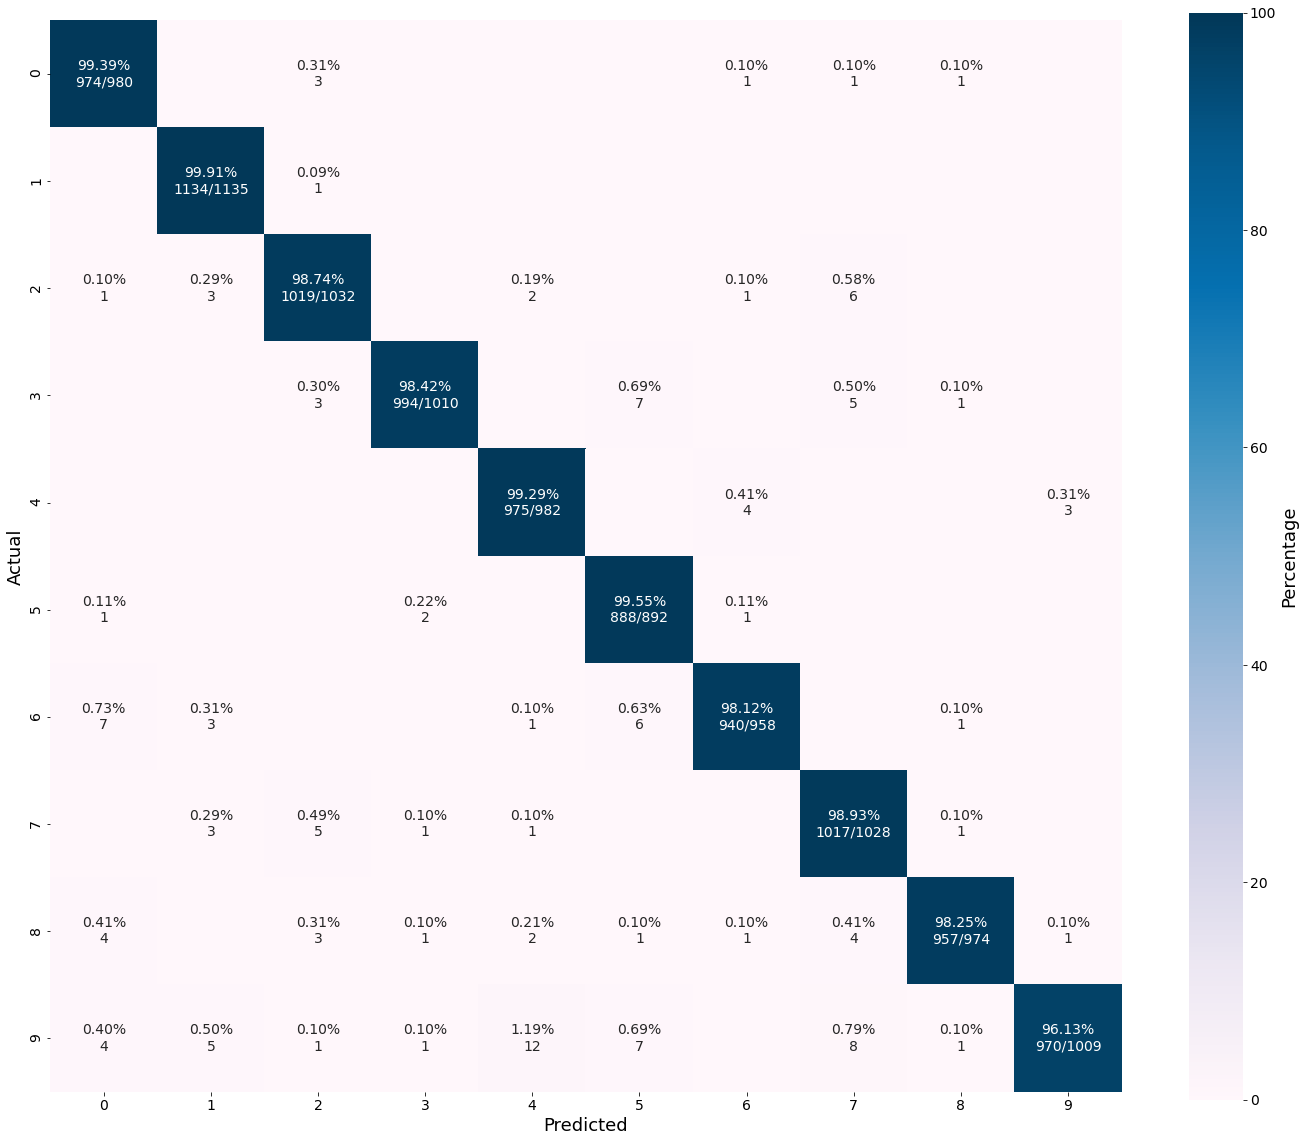

In [10]:
cm_analysis(y_test, preds, labels = np.unique(preds), ymap=None, figsize=(24,20))

In [11]:
accuracy_score(y_test, preds)

0.9868

## Heart Disease Data

In [12]:
folder = r"C:\Users\ponglao\OneDrive - savvysherpa.com\XGBoost & LGBM\heartdisease"
data = pd.read_csv(folder + '\\heart.csv')
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [13]:
data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

Let's check the distribution of `target`

In [14]:
df1 = data.target.value_counts().rename('Count')
df2 = (data.target.value_counts(normalize = True)*100).rename('Percent')
pd.concat([df1,df2], axis = 1).style.format({'Percent':'{:.2f}%'})

Separate the data into X (features) and y (class/target)

In [15]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

Split the data into train and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1010, stratify = y)

Define data types for each column

In [17]:
cat_cols = ['sex','cp','fbs','restecg','exang','slope', 'thal'] #list down the cat column names
data_type = ['categorical' if item in cat_cols else 'numerical' for item in X.columns] #get numeric indices based on column order in X
data_type = dict(zip(X.columns, data_type))

In [18]:
import tensorflow as tf
import autokeras as ak

In [19]:
clf = ak.StructuredDataClassifier(max_trials = 300,
                                  column_names = X.columns.tolist(),
                                  column_types = data_type,
                                  directory = r'C:\ak',
                                  seed = 2020)
clf.fit(X_train, y_train)

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 13.7503 - accuracy: 0.437 - 1s 75ms/step - loss: 9.3848 - accuracy: 0.4588 - val_loss: 2.6007 - val_accuracy: 0.7292
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.0830 - accuracy: 0.59 - 0s 4ms/step - loss: 2.9597 - accuracy: 0.5979 - val_loss: 2.5377 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.5842 - accuracy: 0.68 - 0s 4ms/step - loss: 3.0347 - accuracy: 0.6289 - val_loss: 1.6270 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.3506 - accuracy: 0.68 - 0s 4ms/step - loss: 1.9612 - accuracy: 0.5979 - val_loss: 2.1170 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.7988 - accuracy: 0.59 - 0s 4ms/step - loss: 2.2610 - accuracy: 0.5979 - val_loss: 1.6783 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4737 - accuracy: 0.7526 - val_loss: 0.4529 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.71 - 0s 20ms/step - loss: 0.4693 - accuracy: 0.7526 - val_loss: 0.4506 - val_accuracy: 0.8125
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4649 - accuracy: 0.7577 - val_loss: 0.4483 - val_accuracy: 0.8125
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.71 - 0s 20ms/step - loss: 0.4607 - accuracy: 0.7577 - val_loss: 0.4461 - val_accuracy: 0.8333
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4565 - accuracy: 0.7732 - val_loss: 0.4440 - val_accuracy: 0.8333
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5617 - accur

Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8454 - val_loss: 0.4098 - val_accuracy: 0.7917
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3571 - accuracy: 0.8454 - val_loss: 0.4091 - val_accuracy: 0.7917
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3561 - accuracy: 0.8454 - val_loss: 0.4109 - val_accuracy: 0.7917
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3548 - accuracy: 0.8454 - val_loss: 0.4114 - val_accuracy: 0.7917
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3537 - accuracy: 0.8454 - val_loss: 0.4113 - val_accuracy: 0.7917
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.4418 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 33.9457 - accuracy: 0.437 - 1s 89ms/step - loss: 20.9455 - accuracy: 0.5052 - val_loss: 2.0702 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.7118 - accuracy: 0.562 - 0s 20ms/step - loss: 12.2288 - accuracy: 0.4948 - val_loss: 3.8280 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 14.8664 - accuracy: 0.562 - 0s 5ms/step - loss: 9.9596 - accuracy: 0.4845 - val_loss: 2.8018 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 11.7049 - accuracy: 0.406 - 0s 20ms/step - loss: 8.5139 - accuracy: 0.5412 - val_loss: 0.9193 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 9.4555 - accuracy: 0.34 - 0s 5ms/step - loss: 5.4875 - accuracy: 0.5052 - val_loss: 0.7365 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [===================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8195 - accuracy: 0.53 - 1s 123ms/step - loss: 0.8000 - accuracy: 0.6237 - val_loss: 6.2799 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5704 - accuracy: 0.7784 - val_loss: 3.7626 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.81 - 0s 6ms/step - loss: 0.4993 - accuracy: 0.8196 - val_loss: 3.1705 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.90 - 0s 5ms/step - loss: 0.4577 - accuracy: 0.8660 - val_loss: 2.4980 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.87 - 0s 5ms/step - loss: 0.4219 - accuracy: 0.8660 - val_loss: 1.9716 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8897 - accuracy: 0.53 - 1s 131ms/step - loss: 0.7811 - accuracy: 0.5361 - val_loss: 1.1734 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.65 - 0s 22ms/step - loss: 0.7489 - accuracy: 0.5722 - val_loss: 0.6268 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.59 - 0s 22ms/step - loss: 0.6782 - accuracy: 0.5825 - val_loss: 0.6265 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.75 - 0s 6ms/step - loss: 0.7198 - accuracy: 0.6237 - val_loss: 0.6408 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.68 - 0s 6ms/step - loss: 0.7044 - accuracy: 0.6340 - val_loss: 0.6876 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0834 - accuracy: 0.34 - 1s 113ms/step - loss: 1.0399 - accuracy: 0.4381 - val_loss: 3.6999 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7860 - accuracy: 0.4794 - val_loss: 2.0456 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7346 - accuracy: 0.5619 - val_loss: 1.5081 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8195 - accuracy: 0.46 - 0s 5ms/step - loss: 0.7263 - accuracy: 0.5361 - val_loss: 1.1678 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.68 - 0s 21ms/step - loss: 0.7400 - accuracy: 0.5876 - val_loss: 0.8731 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.0961 - accuracy: 0.50 - 1s 103ms/step - loss: 0.8791 - accuracy: 0.5876 - val_loss: 13.5182 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.62 - 0s 22ms/step - loss: 0.7066 - accuracy: 0.6959 - val_loss: 1.9205 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5064 - accuracy: 0.7320 - val_loss: 2.4253 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.81 - 0s 6ms/step - loss: 0.4566 - accuracy: 0.7887 - val_loss: 2.4336 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.84 - 0s 22ms/step - loss: 0.4254 - accuracy: 0.8351 - val_loss: 0.6546 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 10.7998 - accuracy: 0.437 - 1s 75ms/step - loss: 2.5464 - accuracy: 0.5619 - val_loss: 1.7028 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.8443 - accuracy: 0.43 - 0s 20ms/step - loss: 1.4764 - accuracy: 0.5155 - val_loss: 1.8256 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.9243 - accuracy: 0.43 - 0s 20ms/step - loss: 1.7486 - accuracy: 0.4897 - val_loss: 0.6252 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.59 - 0s 4ms/step - loss: 1.5089 - accuracy: 0.5412 - val_loss: 0.9328 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.65 - 0s 4ms/step - loss: 0.9391 - accuracy: 0.6701 - val_loss: 1.0906 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 36.0826 - accuracy: 0.500 - 0s 68ms/step - loss: 42.1289 - accuracy: 0.5103 - val_loss: 25.3316 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 45.3202 - accuracy: 0.437 - 0s 3ms/step - loss: 33.8389 - accuracy: 0.5412 - val_loss: 17.4303 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 35.8227 - accuracy: 0.593 - 0s 4ms/step - loss: 26.8533 - accuracy: 0.5258 - val_loss: 11.3622 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 45.5546 - accuracy: 0.406 - 0s 4ms/step - loss: 32.2135 - accuracy: 0.5103 - val_loss: 7.7407 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 15.6416 - accuracy: 0.687 - 0s 4ms/step - loss: 34.4102 - accuracy: 0.4742 - val_loss: 6.1187 - val_accuracy: 0.3958
Epoch 6/1000
7/7 [=============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 1.4107 - accuracy: 0.43 - 1s 77ms/step - loss: 11.6244 - accuracy: 0.5515 - val_loss: 25.1243 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 27.4333 - accuracy: 0.437 - 0s 6ms/step - loss: 18.4507 - accuracy: 0.4588 - val_loss: 10.9675 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 10.2383 - accuracy: 0.562 - 0s 24ms/step - loss: 4.4664 - accuracy: 0.6031 - val_loss: 3.6223 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.6748 - accuracy: 0.50 - 0s 24ms/step - loss: 3.3789 - accuracy: 0.5773 - val_loss: 1.5497 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.5087 - accuracy: 0.68 - 0s 5ms/step - loss: 2.9571 - accuracy: 0.5722 - val_loss: 1.9842 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [=====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9082 - accuracy: 0.34 - 1s 86ms/step - loss: 0.7613 - accuracy: 0.4536 - val_loss: 1.5144 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.71 - 0s 4ms/step - loss: 0.7866 - accuracy: 0.5928 - val_loss: 1.2272 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.62 - 0s 19ms/step - loss: 0.6661 - accuracy: 0.6289 - val_loss: 1.1010 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6031 - val_loss: 0.9935 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.90 - 0s 19ms/step - loss: 0.6316 - accuracy: 0.7010 - val_loss: 0.9238 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 28.5120 - accuracy: 0.531 - 0s 68ms/step - loss: 24.3120 - accuracy: 0.5052 - val_loss: 9.4584 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 28.6606 - accuracy: 0.593 - 0s 19ms/step - loss: 20.4199 - accuracy: 0.5258 - val_loss: 5.8651 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 22.9012 - accuracy: 0.406 - 0s 19ms/step - loss: 29.6326 - accuracy: 0.4485 - val_loss: 3.2385 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 29.7921 - accuracy: 0.500 - 0s 20ms/step - loss: 22.5984 - accuracy: 0.4742 - val_loss: 1.6097 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 36.0653 - accuracy: 0.343 - 0s 19ms/step - loss: 19.5896 - accuracy: 0.5206 - val_loss: 1.1695 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6010 - accuracy: 0.75 - 1s 130ms/step - loss: 0.7692 - accuracy: 0.6443 - val_loss: 14.9124 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.59 - 0s 5ms/step - loss: 0.7914 - accuracy: 0.6392 - val_loss: 9.1696 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6299 - accuracy: 0.6753 - val_loss: 8.3769 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6306 - accuracy: 0.6804 - val_loss: 6.9122 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5310 - accuracy: 0.71 - 0s 6ms/step - loss: 0.6525 - accuracy: 0.6959 - val_loss: 4.6814 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.2252 - accuracy: 0.43 - 0s 67ms/step - loss: 5.1609 - accuracy: 0.4742 - val_loss: 2.0689 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.0062 - accuracy: 0.62 - 0s 19ms/step - loss: 1.5301 - accuracy: 0.5979 - val_loss: 1.3195 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.56 - 0s 4ms/step - loss: 1.4100 - accuracy: 0.5722 - val_loss: 0.7277 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9334 - accuracy: 0.71 - 0s 19ms/step - loss: 0.9452 - accuracy: 0.6546 - val_loss: 0.5591 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6914 - accuracy: 0.6701 - val_loss: 0.5522 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.3017 - accuracy: 0.53 - 1s 75ms/step - loss: 9.8057 - accuracy: 0.4845 - val_loss: 2.4322 - val_accuracy: 0.4583
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.5966 - accuracy: 0.46 - 0s 19ms/step - loss: 6.8932 - accuracy: 0.5361 - val_loss: 2.7919 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.2807 - accuracy: 0.56 - 0s 4ms/step - loss: 6.5143 - accuracy: 0.4227 - val_loss: 1.5652 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.3617 - accuracy: 0.53 - 0s 4ms/step - loss: 8.5356 - accuracy: 0.5155 - val_loss: 0.8397 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.6849 - accuracy: 0.43 - 0s 4ms/step - loss: 6.6303 - accuracy: 0.5000 - val_loss: 3.3351 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7196 - accuracy: 0.59 - 1s 88ms/step - loss: 0.7025 - accuracy: 0.6134 - val_loss: 6.5293 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.71 - 0s 20ms/step - loss: 0.5904 - accuracy: 0.7113 - val_loss: 2.1679 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.68 - 0s 21ms/step - loss: 0.5825 - accuracy: 0.7113 - val_loss: 0.8714 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.68 - 0s 20ms/step - loss: 0.5196 - accuracy: 0.7371 - val_loss: 0.4388 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.78 - 0s 5ms/step - loss: 0.4564 - accuracy: 0.8196 - val_loss: 0.4426 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7607 - accuracy: 0.37 - 1s 81ms/step - loss: 0.7006 - accuracy: 0.5979 - val_loss: 1.8242 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.62 - 0s 20ms/step - loss: 0.6397 - accuracy: 0.6753 - val_loss: 0.9253 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.71 - 0s 19ms/step - loss: 0.6113 - accuracy: 0.7165 - val_loss: 0.7224 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5986 - accuracy: 0.7010 - val_loss: 0.7493 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.68 - 0s 4ms/step - loss: 0.5918 - accuracy: 0.6907 - val_loss: 0.8555 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7923 - accuracy: 0.43 - 1s 107ms/step - loss: 0.7303 - accuracy: 0.5412 - val_loss: 0.6163 - val_accuracy: 0.7500
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.43 - 0s 4ms/step - loss: 0.7354 - accuracy: 0.4845 - val_loss: 0.5919 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.43 - 0s 4ms/step - loss: 0.7525 - accuracy: 0.5000 - val_loss: 0.5724 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6663 - accuracy: 0.5670 - val_loss: 0.5649 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.53 - 0s 20ms/step - loss: 0.7223 - accuracy: 0.5567 - val_loss: 0.5593 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9836 - accuracy: 0.40 - 1s 101ms/step - loss: 0.7908 - accuracy: 0.4433 - val_loss: 8.3027 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.46 - 0s 4ms/step - loss: 0.6654 - accuracy: 0.5309 - val_loss: 5.0122 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.53 - 0s 5ms/step - loss: 0.6183 - accuracy: 0.6134 - val_loss: 3.0953 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.62 - 0s 20ms/step - loss: 0.5896 - accuracy: 0.6598 - val_loss: 1.8537 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.65 - 0s 20ms/step - loss: 0.5638 - accuracy: 0.6959 - val_loss: 1.1795 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 68.5405 - accuracy: 0.531 - 0s 70ms/step - loss: 77.0604 - accuracy: 0.4845 - val_loss: 60.5964 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 84.2289 - accuracy: 0.406 - 0s 3ms/step - loss: 78.5000 - accuracy: 0.4227 - val_loss: 52.5396 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 69.5353 - accuracy: 0.468 - 0s 4ms/step - loss: 67.4731 - accuracy: 0.4536 - val_loss: 46.4905 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 81.3079 - accuracy: 0.562 - 0s 4ms/step - loss: 66.9291 - accuracy: 0.4433 - val_loss: 40.8507 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 52.9804 - accuracy: 0.406 - 0s 4ms/step - loss: 49.9613 - accuracy: 0.4639 - val_loss: 35.0876 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========

Epoch 45/1000
7/7 [==============================] - ETA: 0s - loss: 21.1562 - accuracy: 0.375 - 0s 4ms/step - loss: 15.3409 - accuracy: 0.5515 - val_loss: 2.2885 - val_accuracy: 0.5000
Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 17.0444 - accuracy: 0.500 - 0s 4ms/step - loss: 15.9232 - accuracy: 0.5052 - val_loss: 2.0903 - val_accuracy: 0.5208
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 14.3390 - accuracy: 0.562 - 0s 19ms/step - loss: 15.7732 - accuracy: 0.5258 - val_loss: 1.8120 - val_accuracy: 0.5625
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 13.1503 - accuracy: 0.562 - 0s 19ms/step - loss: 16.8925 - accuracy: 0.5309 - val_loss: 1.7258 - val_accuracy: 0.5833
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 13.7670 - accuracy: 0.593 - 0s 4ms/step - loss: 13.6520 - accuracy: 0.5258 - val_loss: 1.7867 - val_accuracy: 0.5833
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss:

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6850 - accuracy: 0.50 - 1s 86ms/step - loss: 0.7486 - accuracy: 0.5773 - val_loss: 8.6620 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.56 - 0s 4ms/step - loss: 0.7231 - accuracy: 0.5979 - val_loss: 5.9682 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7022 - accuracy: 0.6237 - val_loss: 4.3964 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.62 - 0s 4ms/step - loss: 0.6884 - accuracy: 0.6392 - val_loss: 3.3760 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.59 - 0s 4ms/step - loss: 0.6741 - accuracy: 0.6443 - val_loss: 2.6540 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 30.1426 - accuracy: 0.562 - 0s 70ms/step - loss: 21.2858 - accuracy: 0.5619 - val_loss: 10.1568 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.2743 - accuracy: 0.562 - 0s 19ms/step - loss: 3.5334 - accuracy: 0.5979 - val_loss: 5.2427 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.2848 - accuracy: 0.43 - 0s 20ms/step - loss: 5.8745 - accuracy: 0.4381 - val_loss: 2.2334 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.5933 - accuracy: 0.40 - 0s 20ms/step - loss: 2.0398 - accuracy: 0.5876 - val_loss: 2.7719 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.5517 - accuracy: 0.56 - 0s 19ms/step - loss: 1.6615 - accuracy: 0.6598 - val_loss: 1.2313 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [=====================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4469 - accuracy: 0.7938 - val_loss: 0.4765 - val_accuracy: 0.7500
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.75 - 0s 4ms/step - loss: 0.4404 - accuracy: 0.7990 - val_loss: 0.4749 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.75 - 0s 4ms/step - loss: 0.4337 - accuracy: 0.8041 - val_loss: 0.4732 - val_accuracy: 0.7292
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.75 - 0s 4ms/step - loss: 0.4276 - accuracy: 0.7990 - val_loss: 0.4753 - val_accuracy: 0.7292
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.75 - 0s 4ms/step - loss: 0.4216 - accuracy: 0.7990 - val_loss: 0.4777 - val_accuracy: 0.7500
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4726 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.0255 - accuracy: 0.28 - 1s 102ms/step - loss: 0.7824 - accuracy: 0.5206 - val_loss: 7.1984 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6322 - accuracy: 0.7113 - val_loss: 1.7181 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.78 - 0s 21ms/step - loss: 0.5161 - accuracy: 0.7577 - val_loss: 0.7349 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.90 - 0s 22ms/step - loss: 0.4759 - accuracy: 0.8144 - val_loss: 0.5693 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.87 - 0s 5ms/step - loss: 0.4508 - accuracy: 0.8454 - val_loss: 1.2615 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 8.1945 - accuracy: 0.62 - 1s 90ms/step - loss: 10.9529 - accuracy: 0.5206 - val_loss: 1.8363 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.6138 - accuracy: 0.531 - 0s 7ms/step - loss: 9.9418 - accuracy: 0.5412 - val_loss: 1.7238 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.7116 - accuracy: 0.62 - 0s 26ms/step - loss: 9.1597 - accuracy: 0.5258 - val_loss: 0.6397 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.5552 - accuracy: 0.62 - 0s 7ms/step - loss: 6.4920 - accuracy: 0.5567 - val_loss: 0.6892 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.4009 - accuracy: 0.59 - 0s 7ms/step - loss: 5.1761 - accuracy: 0.5361 - val_loss: 0.8922 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 22.7086 - accuracy: 0.437 - 0s 70ms/step - loss: 16.8961 - accuracy: 0.4381 - val_loss: 10.4715 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.3254 - accuracy: 0.437 - 0s 18ms/step - loss: 7.0470 - accuracy: 0.4381 - val_loss: 1.4973 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.50 - 0s 4ms/step - loss: 2.3493 - accuracy: 0.5928 - val_loss: 2.9784 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.8228 - accuracy: 0.59 - 0s 19ms/step - loss: 2.1305 - accuracy: 0.5928 - val_loss: 1.2083 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.68 - 0s 4ms/step - loss: 1.1962 - accuracy: 0.5722 - val_loss: 1.7069 - val_accuracy: 0.4375
Epoch 6/1000
7/7 [=======================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.71 - 0s 20ms/step - loss: 0.4500 - accuracy: 0.7990 - val_loss: 0.5884 - val_accuracy: 0.6667
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4450 - accuracy: 0.7990 - val_loss: 0.5846 - val_accuracy: 0.6667
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.71 - 0s 19ms/step - loss: 0.4403 - accuracy: 0.7990 - val_loss: 0.5808 - val_accuracy: 0.6875
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4353 - accuracy: 0.7990 - val_loss: 0.5775 - val_accuracy: 0.6875
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.71 - 0s 4ms/step - loss: 0.4312 - accuracy: 0.7990 - val_loss: 0.5743 - val_accuracy: 0.6875
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5451 - accur

Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8608 - val_loss: 0.5140 - val_accuracy: 0.7708
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3289 - accuracy: 0.8608 - val_loss: 0.5128 - val_accuracy: 0.7708
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3277 - accuracy: 0.8557 - val_loss: 0.5110 - val_accuracy: 0.7708
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3274 - accuracy: 0.8557 - val_loss: 0.5138 - val_accuracy: 0.7708
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3256 - accuracy: 0.8505 - val_loss: 0.5133 - val_accuracy: 0.7708
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.4347 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 51.3206 - accuracy: 0.437 - 0s 70ms/step - loss: 37.1943 - accuracy: 0.4381 - val_loss: 21.1771 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 26.2397 - accuracy: 0.437 - 0s 4ms/step - loss: 19.9594 - accuracy: 0.4536 - val_loss: 3.9339 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 16.4338 - accuracy: 0.531 - 0s 4ms/step - loss: 21.3107 - accuracy: 0.5000 - val_loss: 3.8547 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 16.4256 - accuracy: 0.406 - 0s 4ms/step - loss: 16.9110 - accuracy: 0.5361 - val_loss: 3.4067 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 15.8739 - accuracy: 0.406 - 0s 4ms/step - loss: 14.1980 - accuracy: 0.5309 - val_loss: 1.9920 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.4262 - accuracy: 0.43 - 0s 69ms/step - loss: 5.9901 - accuracy: 0.4794 - val_loss: 0.8126 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8094 - accuracy: 0.56 - 0s 19ms/step - loss: 2.8455 - accuracy: 0.4588 - val_loss: 0.5623 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.68 - 0s 4ms/step - loss: 1.0205 - accuracy: 0.6134 - val_loss: 1.2647 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.3677 - accuracy: 0.43 - 0s 4ms/step - loss: 1.4317 - accuracy: 0.5155 - val_loss: 0.8796 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1350 - accuracy: 0.65 - 0s 19ms/step - loss: 0.7629 - accuracy: 0.6701 - val_loss: 0.4944 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 19.4433 - accuracy: 0.437 - 1s 81ms/step - loss: 14.9704 - accuracy: 0.4433 - val_loss: 0.6448 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.5179 - accuracy: 0.406 - 0s 5ms/step - loss: 11.9809 - accuracy: 0.4948 - val_loss: 2.5238 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 8.2611 - accuracy: 0.62 - 0s 5ms/step - loss: 9.3737 - accuracy: 0.5515 - val_loss: 4.4805 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.7855 - accuracy: 0.65 - 0s 21ms/step - loss: 10.0115 - accuracy: 0.5515 - val_loss: 1.8117 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.7158 - accuracy: 0.62 - 0s 5ms/step - loss: 7.3885 - accuracy: 0.5515 - val_loss: 1.7902 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [=======================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9867 - accuracy: 0.46 - 1s 115ms/step - loss: 0.7473 - accuracy: 0.5412 - val_loss: 1.0443 - val_accuracy: 0.7292
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.71 - 0s 6ms/step - loss: 0.7356 - accuracy: 0.6546 - val_loss: 4.7676 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7144 - accuracy: 0.6753 - val_loss: 3.9685 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7612 - accuracy: 0.6443 - val_loss: 3.2530 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.46 - 0s 6ms/step - loss: 0.6272 - accuracy: 0.6649 - val_loss: 3.2991 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9410 - accuracy: 0.50 - 1s 86ms/step - loss: 0.8658 - accuracy: 0.4794 - val_loss: 9.9551 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.50 - 0s 4ms/step - loss: 0.8816 - accuracy: 0.4845 - val_loss: 6.4397 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.46 - 0s 4ms/step - loss: 0.9046 - accuracy: 0.5052 - val_loss: 4.7804 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.0512 - accuracy: 0.50 - 0s 4ms/step - loss: 0.9114 - accuracy: 0.4742 - val_loss: 3.7484 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.46 - 0s 4ms/step - loss: 0.7959 - accuracy: 0.5052 - val_loss: 3.0375 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================]

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6753 - val_loss: 0.5218 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6546 - val_loss: 0.5204 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.68 - 0s 4ms/step - loss: 0.5769 - accuracy: 0.6804 - val_loss: 0.5211 - val_accuracy: 0.7292
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6890 - accuracy: 0.6753 - val_loss: 0.5205 - val_accuracy: 0.7292
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5928 - val_loss: 0.5217 - val_accuracy: 0.7292
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5516 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0732 - accuracy: 0.21 - 1s 129ms/step - loss: 0.8965 - accuracy: 0.3969 - val_loss: 1.8278 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.28 - 0s 5ms/step - loss: 0.8436 - accuracy: 0.4691 - val_loss: 1.0797 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.59 - 0s 5ms/step - loss: 0.7737 - accuracy: 0.5206 - val_loss: 0.7761 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8727 - accuracy: 0.46 - 0s 21ms/step - loss: 0.7293 - accuracy: 0.5773 - val_loss: 0.6902 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7258 - accuracy: 0.4948 - val_loss: 0.6897 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8672 - accuracy: 0.59 - 1s 132ms/step - loss: 0.7984 - accuracy: 0.5052 - val_loss: 0.7481 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.50 - 0s 21ms/step - loss: 0.6879 - accuracy: 0.5670 - val_loss: 0.6277 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.75 - 0s 6ms/step - loss: 0.6317 - accuracy: 0.6237 - val_loss: 0.6424 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.50 - 0s 5ms/step - loss: 0.6809 - accuracy: 0.5412 - val_loss: 0.7090 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.53 - 0s 6ms/step - loss: 0.6677 - accuracy: 0.6082 - val_loss: 0.7538 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 7.3582 - accuracy: 0.43 - 0s 68ms/step - loss: 2.7674 - accuracy: 0.5412 - val_loss: 0.5688 - val_accuracy: 0.6667
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.68 - 0s 20ms/step - loss: 0.5892 - accuracy: 0.6598 - val_loss: 0.4524 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4899 - accuracy: 0.7165 - val_loss: 0.6318 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.53 - 0s 4ms/step - loss: 0.5696 - accuracy: 0.6392 - val_loss: 0.7842 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.59 - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6701 - val_loss: 1.2542 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6878 - accuracy: 0.56 - 1s 138ms/step - loss: 0.8664 - accuracy: 0.5876 - val_loss: 0.8143 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.62 - 0s 7ms/step - loss: 0.6478 - accuracy: 0.6753 - val_loss: 1.9165 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.71 - 0s 7ms/step - loss: 0.7137 - accuracy: 0.6701 - val_loss: 3.4137 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.62 - 0s 7ms/step - loss: 0.6961 - accuracy: 0.6340 - val_loss: 4.1465 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.75 - 0s 7ms/step - loss: 0.6569 - accuracy: 0.6753 - val_loss: 2.6868 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8607 - accuracy: 0.53 - 1s 85ms/step - loss: 0.7959 - accuracy: 0.5052 - val_loss: 6.4010 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.46 - 0s 4ms/step - loss: 0.8390 - accuracy: 0.4536 - val_loss: 4.5281 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9585 - accuracy: 0.53 - 0s 4ms/step - loss: 0.8173 - accuracy: 0.4948 - val_loss: 3.5653 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.43 - 0s 4ms/step - loss: 0.8742 - accuracy: 0.5103 - val_loss: 2.9595 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.62 - 0s 4ms/step - loss: 0.9202 - accuracy: 0.4588 - val_loss: 2.5366 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7399 - accuracy: 0.56 - 1s 159ms/step - loss: 0.8410 - accuracy: 0.5979 - val_loss: 16.5006 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.65 - 0s 8ms/step - loss: 0.5701 - accuracy: 0.7216 - val_loss: 2.0875 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.81 - 0s 7ms/step - loss: 0.4792 - accuracy: 0.8144 - val_loss: 5.3578 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.87 - 0s 26ms/step - loss: 0.4210 - accuracy: 0.8454 - val_loss: 0.5009 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3813 - accuracy: 0.8866 - val_loss: 0.6254 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 11.0450 - accuracy: 0.562 - 1s 76ms/step - loss: 4.8864 - accuracy: 0.5309 - val_loss: 1.9318 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.2078 - accuracy: 0.65 - 0s 20ms/step - loss: 1.2696 - accuracy: 0.6340 - val_loss: 0.6190 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.75 - 0s 20ms/step - loss: 0.7281 - accuracy: 0.6959 - val_loss: 0.5921 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7329 - accuracy: 0.6753 - val_loss: 0.6769 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8316 - accuracy: 0.53 - 0s 4ms/step - loss: 0.8086 - accuracy: 0.6186 - val_loss: 0.8108 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.2677 - accuracy: 0.50 - 1s 87ms/step - loss: 7.4651 - accuracy: 0.5412 - val_loss: 7.0884 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.6361 - accuracy: 0.53 - 0s 6ms/step - loss: 13.5808 - accuracy: 0.4845 - val_loss: 5.5747 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 8.6983 - accuracy: 0.68 - 0s 6ms/step - loss: 6.4802 - accuracy: 0.6134 - val_loss: 7.3834 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 9.2063 - accuracy: 0.53 - 0s 6ms/step - loss: 8.4678 - accuracy: 0.4691 - val_loss: 2.9566 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.5215 - accuracy: 0.50 - 0s 24ms/step - loss: 8.3561 - accuracy: 0.5258 - val_loss: 1.3106 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9561 - accuracy: 0.50 - 1s 85ms/step - loss: 0.8407 - accuracy: 0.5103 - val_loss: 1.1679 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.50 - 0s 19ms/step - loss: 0.7836 - accuracy: 0.5773 - val_loss: 0.6862 - val_accuracy: 0.7292
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.65 - 0s 19ms/step - loss: 0.7853 - accuracy: 0.5722 - val_loss: 0.5517 - val_accuracy: 0.7708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.59 - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5773 - val_loss: 0.5305 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7936 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7568 - accuracy: 0.6186 - val_loss: 0.5416 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7740 - accuracy: 0.56 - 1s 88ms/step - loss: 0.8371 - accuracy: 0.5876 - val_loss: 2.3574 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.75 - 0s 20ms/step - loss: 0.6409 - accuracy: 0.7113 - val_loss: 0.5953 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5997 - accuracy: 0.7062 - val_loss: 0.5861 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.81 - 0s 5ms/step - loss: 0.6092 - accuracy: 0.7423 - val_loss: 1.7449 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.78 - 0s 5ms/step - loss: 0.4934 - accuracy: 0.7835 - val_loss: 1.1635 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6659 - accuracy: 0.56 - 1s 90ms/step - loss: 0.6845 - accuracy: 0.6340 - val_loss: 3.3028 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.71 - 0s 21ms/step - loss: 0.5856 - accuracy: 0.7010 - val_loss: 0.8323 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.62 - 0s 5ms/step - loss: 0.5402 - accuracy: 0.7165 - val_loss: 1.3352 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.81 - 0s 5ms/step - loss: 0.5303 - accuracy: 0.7423 - val_loss: 1.6127 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.87 - 0s 21ms/step - loss: 0.5240 - accuracy: 0.7835 - val_loss: 0.5609 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8590 - accuracy: 0.34 - 1s 107ms/step - loss: 0.7816 - accuracy: 0.5722 - val_loss: 14.1060 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.78 - 0s 6ms/step - loss: 0.5817 - accuracy: 0.7268 - val_loss: 1.7170 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.93 - 0s 23ms/step - loss: 0.4898 - accuracy: 0.7990 - val_loss: 2.2647 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.87 - 0s 22ms/step - loss: 0.4344 - accuracy: 0.8247 - val_loss: 1.3909 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.87 - 0s 23ms/step - loss: 0.4023 - accuracy: 0.8660 - val_loss: 0.7405 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.4059 - accuracy: 0.437 - 0s 70ms/step - loss: 8.1928 - accuracy: 0.4381 - val_loss: 5.0207 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.0356 - accuracy: 0.56 - 0s 19ms/step - loss: 1.9552 - accuracy: 0.5619 - val_loss: 2.8644 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.2089 - accuracy: 0.43 - 0s 4ms/step - loss: 2.7894 - accuracy: 0.4536 - val_loss: 1.4635 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1862 - accuracy: 0.56 - 0s 4ms/step - loss: 0.9038 - accuracy: 0.5825 - val_loss: 1.1834 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.2219 - accuracy: 0.43 - 0s 4ms/step - loss: 1.3018 - accuracy: 0.4639 - val_loss: 0.9612 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4710 - accuracy: 0.7526 - val_loss: 0.4488 - val_accuracy: 0.8125
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4683 - accuracy: 0.7577 - val_loss: 0.4485 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.65 - 0s 4ms/step - loss: 0.4653 - accuracy: 0.7526 - val_loss: 0.4483 - val_accuracy: 0.8125
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.65 - 0s 4ms/step - loss: 0.4622 - accuracy: 0.7577 - val_loss: 0.4467 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.65 - 0s 4ms/step - loss: 0.4586 - accuracy: 0.7629 - val_loss: 0.4468 - val_accuracy: 0.7917
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5191 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7490 - accuracy: 0.50 - 1s 120ms/step - loss: 0.7587 - accuracy: 0.5309 - val_loss: 3.4951 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6719 - accuracy: 0.5979 - val_loss: 2.1232 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6546 - val_loss: 1.5142 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6056 - accuracy: 0.7062 - val_loss: 1.1998 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.75 - 0s 4ms/step - loss: 0.5888 - accuracy: 0.7320 - val_loss: 1.0362 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.93 - 0s 5ms/step - loss: 0.2711 - accuracy: 0.9227 - val_loss: 0.5822 - val_accuracy: 0.6875
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.93 - 0s 5ms/step - loss: 0.2703 - accuracy: 0.9175 - val_loss: 0.5731 - val_accuracy: 0.6875


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6754 - accuracy: 0.59 - 1s 102ms/step - loss: 0.6741 - accuracy: 0.6082 - val_loss: 2.5137 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5865 - accuracy: 0.7165 - val_loss: 2.9572 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5596 - accuracy: 0.7474 - val_loss: 3.0773 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.81 - 0s 5ms/step - loss: 0.5310 - accuracy: 0.7887 - val_loss: 2.5882 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.90 - 0s 5ms/step - loss: 0.5033 - accuracy: 0.8247 - val_loss: 1.4256 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8757 - accuracy: 0.56 - 1s 132ms/step - loss: 0.8426 - accuracy: 0.5464 - val_loss: 0.6786 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.46 - 0s 22ms/step - loss: 0.8440 - accuracy: 0.5155 - val_loss: 0.6352 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8334 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7539 - accuracy: 0.5412 - val_loss: 0.6071 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.40 - 0s 22ms/step - loss: 0.7861 - accuracy: 0.4794 - val_loss: 0.5911 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.62 - 0s 6ms/step - loss: 0.8876 - accuracy: 0.5515 - val_loss: 0.6073 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7096 - accuracy: 0.65 - 1s 139ms/step - loss: 0.7252 - accuracy: 0.5309 - val_loss: 1.0146 - val_accuracy: 0.3542
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.50 - 0s 21ms/step - loss: 0.7203 - accuracy: 0.5619 - val_loss: 0.8784 - val_accuracy: 0.3750
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.46 - 0s 21ms/step - loss: 0.8401 - accuracy: 0.5052 - val_loss: 0.8840 - val_accuracy: 0.4583
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.59 - 0s 22ms/step - loss: 0.7210 - accuracy: 0.5515 - val_loss: 0.7693 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.62 - 0s 21ms/step - loss: 0.7621 - accuracy: 0.5309 - val_loss: 0.7370 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 24.1759 - accuracy: 0.468 - 1s 77ms/step - loss: 20.3638 - accuracy: 0.4175 - val_loss: 8.1854 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.5950 - accuracy: 0.500 - 0s 4ms/step - loss: 13.6520 - accuracy: 0.4897 - val_loss: 3.0597 - val_accuracy: 0.3125
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 14.1511 - accuracy: 0.468 - 0s 4ms/step - loss: 13.1914 - accuracy: 0.4330 - val_loss: 7.1343 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 9.8136 - accuracy: 0.59 - 0s 4ms/step - loss: 11.4163 - accuracy: 0.5412 - val_loss: 9.0369 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.1684 - accuracy: 0.500 - 0s 4ms/step - loss: 11.5922 - accuracy: 0.5155 - val_loss: 8.4251 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 12.8005 - accuracy: 0.468 - 1s 88ms/step - loss: 10.3967 - accuracy: 0.5052 - val_loss: 3.9578 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.7147 - accuracy: 0.500 - 0s 7ms/step - loss: 8.7697 - accuracy: 0.4897 - val_loss: 2.4311 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.5482 - accuracy: 0.62 - 0s 7ms/step - loss: 7.9634 - accuracy: 0.5309 - val_loss: 2.4975 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 9.0166 - accuracy: 0.37 - 0s 7ms/step - loss: 7.6605 - accuracy: 0.4536 - val_loss: 4.3492 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.0498 - accuracy: 0.68 - 0s 26ms/step - loss: 6.2924 - accuracy: 0.5825 - val_loss: 0.6687 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 5.3174 - accuracy: 0.46 - 0s 69ms/step - loss: 5.0737 - accuracy: 0.5670 - val_loss: 1.3916 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.7252 - accuracy: 0.46 - 0s 20ms/step - loss: 6.7827 - accuracy: 0.5567 - val_loss: 0.6694 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.1437 - accuracy: 0.46 - 0s 20ms/step - loss: 3.9172 - accuracy: 0.5619 - val_loss: 0.6039 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.1499 - accuracy: 0.59 - 0s 20ms/step - loss: 3.7212 - accuracy: 0.6082 - val_loss: 0.5325 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.9945 - accuracy: 0.53 - 0s 20ms/step - loss: 3.6829 - accuracy: 0.5619 - val_loss: 0.6154 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 14.6918 - accuracy: 0.437 - 1s 74ms/step - loss: 7.0332 - accuracy: 0.4485 - val_loss: 3.5360 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.1286 - accuracy: 0.56 - 0s 21ms/step - loss: 1.5964 - accuracy: 0.5567 - val_loss: 1.4406 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.6272 - accuracy: 0.43 - 0s 20ms/step - loss: 1.4069 - accuracy: 0.4845 - val_loss: 0.5622 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.68 - 0s 4ms/step - loss: 0.9757 - accuracy: 0.5361 - val_loss: 0.7096 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.65 - 0s 20ms/step - loss: 0.5849 - accuracy: 0.6546 - val_loss: 0.7097 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 4.4646 - accuracy: 0.31 - 0s 68ms/step - loss: 3.2268 - accuracy: 0.4330 - val_loss: 3.8555 - val_accuracy: 0.4583
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.6326 - accuracy: 0.31 - 0s 4ms/step - loss: 3.2497 - accuracy: 0.3814 - val_loss: 2.3259 - val_accuracy: 0.3542
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.6220 - accuracy: 0.59 - 0s 19ms/step - loss: 1.2006 - accuracy: 0.4948 - val_loss: 1.0660 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9305 - accuracy: 0.31 - 0s 19ms/step - loss: 0.9245 - accuracy: 0.5052 - val_loss: 0.7469 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.65 - 0s 20ms/step - loss: 0.8884 - accuracy: 0.5464 - val_loss: 0.6340 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 1.4168 - accuracy: 0.46 - 1s 87ms/step - loss: 9.5314 - accuracy: 0.4536 - val_loss: 1.1737 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.43 - 0s 30ms/step - loss: 1.0136 - accuracy: 0.5567 - val_loss: 1.0503 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.0927 - accuracy: 0.43 - 0s 8ms/step - loss: 1.0012 - accuracy: 0.5670 - val_loss: 2.2774 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.4704 - accuracy: 0.43 - 0s 29ms/step - loss: 1.9637 - accuracy: 0.4794 - val_loss: 1.0966 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.43 - 0s 8ms/step - loss: 1.9790 - accuracy: 0.4794 - val_loss: 0.8748 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.78 - 0s 7ms/step - loss: 0.3528 - accuracy: 0.8247 - val_loss: 0.4075 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.78 - 0s 7ms/step - loss: 0.3460 - accuracy: 0.8351 - val_loss: 0.4180 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.75 - 0s 7ms/step - loss: 0.3472 - accuracy: 0.8247 - val_loss: 0.4422 - val_accuracy: 0.7917
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4814 - accuracy: 0.71 - 0s 8ms/step - loss: 0.3556 - accuracy: 0.8299 - val_loss: 0.4752 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.65 - 0s 8ms/step - loss: 0.3672 - accuracy: 0.8041 - val_loss: 0.4975 - val_accuracy: 0.8125
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5313 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 3.9109 - accuracy: 0.59 - 1s 84ms/step - loss: 2.5632 - accuracy: 0.5103 - val_loss: 0.5842 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.1698 - accuracy: 0.56 - 0s 19ms/step - loss: 4.5230 - accuracy: 0.4742 - val_loss: 0.5826 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.0105 - accuracy: 0.37 - 0s 20ms/step - loss: 1.9467 - accuracy: 0.5412 - val_loss: 0.5913 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.4069 - accuracy: 0.53 - 0s 4ms/step - loss: 1.8886 - accuracy: 0.5206 - val_loss: 0.6200 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.5104 - accuracy: 0.43 - 0s 4ms/step - loss: 1.7573 - accuracy: 0.4794 - val_loss: 0.6697 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0218 - accuracy: 0.46 - 1s 111ms/step - loss: 0.8661 - accuracy: 0.5773 - val_loss: 2.6815 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.75 - 0s 21ms/step - loss: 0.7456 - accuracy: 0.6082 - val_loss: 2.2920 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.62 - 0s 6ms/step - loss: 0.7147 - accuracy: 0.6186 - val_loss: 2.6624 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.71 - 0s 6ms/step - loss: 0.6514 - accuracy: 0.6701 - val_loss: 2.5446 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6050 - accuracy: 0.7010 - val_loss: 1.3598 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9182 - accuracy: 0.50 - 1s 84ms/step - loss: 0.9829 - accuracy: 0.5000 - val_loss: 3.2272 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8450 - accuracy: 0.40 - 0s 4ms/step - loss: 0.8771 - accuracy: 0.5464 - val_loss: 1.6102 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.46 - 0s 20ms/step - loss: 0.8419 - accuracy: 0.5567 - val_loss: 0.9448 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.50 - 0s 20ms/step - loss: 0.8515 - accuracy: 0.5567 - val_loss: 0.6814 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.59 - 0s 22ms/step - loss: 0.8320 - accuracy: 0.5825 - val_loss: 0.5726 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 22.7047 - accuracy: 0.593 - 1s 73ms/step - loss: 24.6636 - accuracy: 0.5567 - val_loss: 13.7847 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.6567 - accuracy: 0.562 - 0s 20ms/step - loss: 18.8351 - accuracy: 0.5412 - val_loss: 1.6247 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 17.3499 - accuracy: 0.406 - 0s 4ms/step - loss: 14.0907 - accuracy: 0.4794 - val_loss: 5.1733 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.5003 - accuracy: 0.65 - 0s 4ms/step - loss: 13.3229 - accuracy: 0.5619 - val_loss: 6.0623 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 11.4613 - accuracy: 0.656 - 0s 4ms/step - loss: 11.4641 - accuracy: 0.5670 - val_loss: 3.9938 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9853 - accuracy: 0.50 - 1s 144ms/step - loss: 0.9967 - accuracy: 0.5412 - val_loss: 3.3009 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.46 - 0s 6ms/step - loss: 0.8697 - accuracy: 0.5979 - val_loss: 4.2158 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.53 - 0s 7ms/step - loss: 0.8203 - accuracy: 0.5773 - val_loss: 5.6037 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.65 - 0s 6ms/step - loss: 0.6259 - accuracy: 0.6392 - val_loss: 5.9059 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7201 - accuracy: 0.6546 - val_loss: 5.4718 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 14.8373 - accuracy: 0.562 - 1s 79ms/step - loss: 4.8883 - accuracy: 0.5361 - val_loss: 3.5587 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.9511 - accuracy: 0.43 - 0s 22ms/step - loss: 2.8290 - accuracy: 0.5206 - val_loss: 3.8713 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.0510 - accuracy: 0.43 - 0s 22ms/step - loss: 3.9138 - accuracy: 0.5052 - val_loss: 1.2877 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.3255 - accuracy: 0.71 - 0s 5ms/step - loss: 2.6348 - accuracy: 0.6031 - val_loss: 2.0534 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.2828 - accuracy: 0.65 - 0s 5ms/step - loss: 2.0200 - accuracy: 0.6546 - val_loss: 2.2507 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 21.6558 - accuracy: 0.437 - 1s 78ms/step - loss: 23.6346 - accuracy: 0.4227 - val_loss: 1.8713 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 18.8087 - accuracy: 0.437 - 0s 20ms/step - loss: 13.3502 - accuracy: 0.5155 - val_loss: 1.9645 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 14.8483 - accuracy: 0.500 - 0s 20ms/step - loss: 12.9051 - accuracy: 0.4794 - val_loss: 1.2281 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.8315 - accuracy: 0.46 - 0s 20ms/step - loss: 8.7811 - accuracy: 0.5464 - val_loss: 1.1096 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 13.9661 - accuracy: 0.437 - 0s 20ms/step - loss: 9.0340 - accuracy: 0.4639 - val_loss: 0.5488 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 5.8956 - accuracy: 0.65 - 1s 81ms/step - loss: 13.6736 - accuracy: 0.4691 - val_loss: 2.9443 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.5059 - accuracy: 0.53 - 0s 23ms/step - loss: 10.7466 - accuracy: 0.4381 - val_loss: 1.4700 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.1941 - accuracy: 0.46 - 0s 6ms/step - loss: 7.2720 - accuracy: 0.5412 - val_loss: 4.0712 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 9.1421 - accuracy: 0.53 - 0s 6ms/step - loss: 7.6688 - accuracy: 0.6134 - val_loss: 8.2719 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 9.5366 - accuracy: 0.37 - 0s 6ms/step - loss: 9.0445 - accuracy: 0.5206 - val_loss: 2.8507 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 24.0424 - accuracy: 0.531 - 1s 86ms/step - loss: 20.5782 - accuracy: 0.5515 - val_loss: 9.6261 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 19.7592 - accuracy: 0.562 - 0s 5ms/step - loss: 28.2933 - accuracy: 0.5361 - val_loss: 6.9690 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 23.4011 - accuracy: 0.562 - 0s 21ms/step - loss: 22.2190 - accuracy: 0.5309 - val_loss: 2.4561 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 13.9099 - accuracy: 0.625 - 0s 21ms/step - loss: 20.4693 - accuracy: 0.5361 - val_loss: 1.2177 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 14.6012 - accuracy: 0.406 - 0s 5ms/step - loss: 12.7408 - accuracy: 0.5361 - val_loss: 2.2770 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 17.8140 - accuracy: 0.500 - 1s 82ms/step - loss: 18.5173 - accuracy: 0.4948 - val_loss: 4.1725 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.0949 - accuracy: 0.562 - 0s 5ms/step - loss: 13.4825 - accuracy: 0.5412 - val_loss: 4.0919 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 12.2657 - accuracy: 0.531 - 0s 5ms/step - loss: 11.5305 - accuracy: 0.4742 - val_loss: 8.6216 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 8.5428 - accuracy: 0.65 - 0s 21ms/step - loss: 9.1773 - accuracy: 0.5876 - val_loss: 2.8109 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 7.8768 - accuracy: 0.50 - 0s 21ms/step - loss: 8.6526 - accuracy: 0.5258 - val_loss: 0.6093 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.2985 - accuracy: 0.437 - 1s 78ms/step - loss: 6.8375 - accuracy: 0.4948 - val_loss: 0.6256 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.6532 - accuracy: 0.46 - 0s 5ms/step - loss: 1.5504 - accuracy: 0.4588 - val_loss: 0.7141 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7906 - accuracy: 0.5258 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6843 - accuracy: 0.5928 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7058 - accuracy: 0.5773 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 28.0476 - accuracy: 0.562 - 0s 70ms/step - loss: 27.3754 - accuracy: 0.5515 - val_loss: 14.8977 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.2902 - accuracy: 0.562 - 0s 19ms/step - loss: 11.1326 - accuracy: 0.5361 - val_loss: 0.8067 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.0927 - accuracy: 0.59 - 0s 4ms/step - loss: 7.9955 - accuracy: 0.5052 - val_loss: 7.5028 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 17.9605 - accuracy: 0.312 - 0s 4ms/step - loss: 10.7272 - accuracy: 0.4794 - val_loss: 4.6564 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 8.4484 - accuracy: 0.46 - 0s 19ms/step - loss: 9.3491 - accuracy: 0.5155 - val_loss: 0.6578 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [===================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.1967 - accuracy: 0.25 - 1s 93ms/step - loss: 0.9849 - accuracy: 0.4124 - val_loss: 9.7717 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8892 - accuracy: 0.37 - 0s 5ms/step - loss: 0.8965 - accuracy: 0.4588 - val_loss: 5.9492 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.46 - 0s 4ms/step - loss: 0.9012 - accuracy: 0.5052 - val_loss: 3.8727 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6484 - accuracy: 0.6289 - val_loss: 2.5241 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7567 - accuracy: 0.5567 - val_loss: 1.5014 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.7730 - accuracy: 0.65 - 1s 73ms/step - loss: 8.0111 - accuracy: 0.5412 - val_loss: 5.9020 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.1151 - accuracy: 0.59 - 0s 19ms/step - loss: 7.4091 - accuracy: 0.5258 - val_loss: 0.7877 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.6613 - accuracy: 0.56 - 0s 19ms/step - loss: 6.7261 - accuracy: 0.5206 - val_loss: 0.6428 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.1637 - accuracy: 0.65 - 0s 19ms/step - loss: 8.6607 - accuracy: 0.5412 - val_loss: 0.6855 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.0402 - accuracy: 0.34 - 0s 20ms/step - loss: 6.7853 - accuracy: 0.5000 - val_loss: 0.7112 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7999 - accuracy: 0.50 - 1s 125ms/step - loss: 0.6919 - accuracy: 0.6186 - val_loss: 1.8848 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5537 - accuracy: 0.7062 - val_loss: 1.0684 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.75 - 0s 5ms/step - loss: 0.4967 - accuracy: 0.7732 - val_loss: 1.0638 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.84 - 0s 21ms/step - loss: 0.4448 - accuracy: 0.8093 - val_loss: 0.9122 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.84 - 0s 22ms/step - loss: 0.3922 - accuracy: 0.8351 - val_loss: 0.7838 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 26.8661 - accuracy: 0.437 - 0s 71ms/step - loss: 17.1525 - accuracy: 0.4691 - val_loss: 5.7732 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.1136 - accuracy: 0.50 - 0s 4ms/step - loss: 6.8097 - accuracy: 0.4691 - val_loss: 6.8128 - val_accuracy: 0.3958
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 11.0883 - accuracy: 0.468 - 0s 4ms/step - loss: 8.4446 - accuracy: 0.5155 - val_loss: 6.1878 - val_accuracy: 0.4167
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.9349 - accuracy: 0.53 - 0s 4ms/step - loss: 6.6927 - accuracy: 0.5258 - val_loss: 1.9531 - val_accuracy: 0.2917
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.4023 - accuracy: 0.46 - 0s 4ms/step - loss: 6.7359 - accuracy: 0.4588 - val_loss: 3.6992 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 4.7214 - accuracy: 0.56 - 1s 72ms/step - loss: 4.2981 - accuracy: 0.4433 - val_loss: 1.7368 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.4819 - accuracy: 0.59 - 0s 20ms/step - loss: 5.1336 - accuracy: 0.5258 - val_loss: 0.7557 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.9320 - accuracy: 0.56 - 0s 20ms/step - loss: 2.6347 - accuracy: 0.5464 - val_loss: 0.5582 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.8582 - accuracy: 0.53 - 0s 20ms/step - loss: 2.6586 - accuracy: 0.5722 - val_loss: 0.5695 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.1115 - accuracy: 0.59 - 0s 4ms/step - loss: 2.4253 - accuracy: 0.5515 - val_loss: 0.7067 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6669 - accuracy: 0.53 - 1s 119ms/step - loss: 0.8027 - accuracy: 0.5000 - val_loss: 0.6384 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.81 - 0s 5ms/step - loss: 0.6500 - accuracy: 0.6392 - val_loss: 0.6878 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5907 - accuracy: 0.6907 - val_loss: 0.7284 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5474 - accuracy: 0.7320 - val_loss: 0.7182 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5807 - accuracy: 0.7423 - val_loss: 0.6795 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 10.8287 - accuracy: 0.500 - 1s 84ms/step - loss: 8.9053 - accuracy: 0.4433 - val_loss: 7.8573 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.1789 - accuracy: 0.343 - 0s 23ms/step - loss: 6.3677 - accuracy: 0.4639 - val_loss: 0.5748 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.1744 - accuracy: 0.50 - 0s 5ms/step - loss: 3.7220 - accuracy: 0.4845 - val_loss: 0.6608 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.9097 - accuracy: 0.62 - 0s 6ms/step - loss: 2.1872 - accuracy: 0.5412 - val_loss: 1.0411 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.5114 - accuracy: 0.37 - 0s 23ms/step - loss: 2.1968 - accuracy: 0.5103 - val_loss: 0.5796 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9085 - accuracy: 0.50 - 1s 113ms/step - loss: 0.8544 - accuracy: 0.5670 - val_loss: 15.7247 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7966 - accuracy: 0.62 - 0s 25ms/step - loss: 0.7519 - accuracy: 0.6598 - val_loss: 0.9679 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.75 - 0s 25ms/step - loss: 0.5669 - accuracy: 0.6959 - val_loss: 0.6250 - val_accuracy: 0.7708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.84 - 0s 7ms/step - loss: 0.5293 - accuracy: 0.7423 - val_loss: 3.8964 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.78 - 0s 7ms/step - loss: 0.5345 - accuracy: 0.7216 - val_loss: 0.8163 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8239 - accuracy: 0.53 - 1s 131ms/step - loss: 0.8813 - accuracy: 0.5567 - val_loss: 1.1075 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.71 - 0s 5ms/step - loss: 0.9469 - accuracy: 0.5670 - val_loss: 0.9051 - val_accuracy: 0.4583
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.65 - 0s 5ms/step - loss: 0.7563 - accuracy: 0.6134 - val_loss: 0.8448 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.59 - 0s 21ms/step - loss: 0.7584 - accuracy: 0.5155 - val_loss: 0.8149 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.59 - 0s 5ms/step - loss: 0.8881 - accuracy: 0.5412 - val_loss: 0.7653 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.43 - 0s 5ms/step - loss: 0.6717 - accuracy: 0.5979 - val_loss: 0.5141 - val_accuracy: 0.7083
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6493 - accuracy: 0.6546 - val_loss: 0.5126 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7454 - accuracy: 0.6237 - val_loss: 0.5248 - val_accuracy: 0.7292
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6841 - accuracy: 0.6649 - val_loss: 0.5568 - val_accuracy: 0.7292
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.65 - 0s 5ms/step - loss: 0.7312 - accuracy: 0.7010 - val_loss: 0.6093 - val_accuracy: 0.7292
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6633 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 13.0913 - accuracy: 0.531 - 1s 77ms/step - loss: 9.7656 - accuracy: 0.5000 - val_loss: 5.5734 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.8545 - accuracy: 0.468 - 0s 19ms/step - loss: 10.2106 - accuracy: 0.4433 - val_loss: 1.5895 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.1104 - accuracy: 0.56 - 0s 19ms/step - loss: 7.6930 - accuracy: 0.5052 - val_loss: 2.0754 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.9252 - accuracy: 0.53 - 0s 4ms/step - loss: 7.1647 - accuracy: 0.5515 - val_loss: 3.1073 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.7968 - accuracy: 0.56 - 0s 4ms/step - loss: 6.9157 - accuracy: 0.5309 - val_loss: 1.7937 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 16.0015 - accuracy: 0.437 - 1s 74ms/step - loss: 7.8367 - accuracy: 0.4278 - val_loss: 2.5125 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.1319 - accuracy: 0.56 - 0s 20ms/step - loss: 1.8737 - accuracy: 0.5619 - val_loss: 0.7145 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.65 - 0s 4ms/step - loss: 0.9392 - accuracy: 0.5000 - val_loss: 0.6881 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.71 - 0s 4ms/step - loss: 0.7628 - accuracy: 0.6134 - val_loss: 0.6689 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.71 - 0s 20ms/step - loss: 0.6154 - accuracy: 0.6186 - val_loss: 0.6430 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [===========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.71 - 0s 4ms/step - loss: 0.3488 - accuracy: 0.8299 - val_loss: 0.4142 - val_accuracy: 0.8125
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3456 - accuracy: 0.8351 - val_loss: 0.4137 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4648 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3433 - accuracy: 0.8402 - val_loss: 0.4139 - val_accuracy: 0.7917
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3400 - accuracy: 0.8402 - val_loss: 0.4145 - val_accuracy: 0.8125
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3397 - accuracy: 0.8351 - val_loss: 0.4168 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4696 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8028 - accuracy: 0.37 - 1s 119ms/step - loss: 0.9181 - accuracy: 0.5979 - val_loss: 13.9796 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.65 - 0s 26ms/step - loss: 0.7947 - accuracy: 0.6340 - val_loss: 0.6442 - val_accuracy: 0.7292
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.65 - 0s 8ms/step - loss: 0.5298 - accuracy: 0.6959 - val_loss: 0.7610 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.75 - 0s 8ms/step - loss: 0.5393 - accuracy: 0.7320 - val_loss: 1.1533 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.87 - 0s 8ms/step - loss: 0.5212 - accuracy: 0.7990 - val_loss: 0.6013 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 33.7286 - accuracy: 0.562 - 0s 69ms/step - loss: 40.1525 - accuracy: 0.5619 - val_loss: 41.4977 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 33.6964 - accuracy: 0.562 - 0s 4ms/step - loss: 40.1170 - accuracy: 0.5619 - val_loss: 41.4624 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 33.6658 - accuracy: 0.562 - 0s 4ms/step - loss: 40.0825 - accuracy: 0.5619 - val_loss: 41.4274 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 33.6356 - accuracy: 0.562 - 0s 4ms/step - loss: 40.0481 - accuracy: 0.5619 - val_loss: 41.3925 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 33.6054 - accuracy: 0.562 - 0s 4ms/step - loss: 40.0138 - accuracy: 0.5619 - val_loss: 41.3578 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [===========

Epoch 45/1000
7/7 [==============================] - ETA: 0s - loss: 32.4049 - accuracy: 0.562 - 0s 4ms/step - loss: 38.6448 - accuracy: 0.5619 - val_loss: 39.9763 - val_accuracy: 0.4792
Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 32.3751 - accuracy: 0.562 - 0s 4ms/step - loss: 38.6108 - accuracy: 0.5619 - val_loss: 39.9421 - val_accuracy: 0.4792
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 32.3453 - accuracy: 0.562 - 0s 4ms/step - loss: 38.5769 - accuracy: 0.5619 - val_loss: 39.9080 - val_accuracy: 0.4792
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 32.3155 - accuracy: 0.562 - 0s 4ms/step - loss: 38.5429 - accuracy: 0.5619 - val_loss: 39.8739 - val_accuracy: 0.4792
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 32.2858 - accuracy: 0.562 - 0s 4ms/step - loss: 38.5089 - accuracy: 0.5619 - val_loss: 39.8397 - val_accuracy: 0.4792
Epoch 50/1000
7/7 [==============================] - ETA: 0s - lo

Epoch 89/1000
7/7 [==============================] - ETA: 0s - loss: 31.0957 - accuracy: 0.562 - 0s 4ms/step - loss: 37.1554 - accuracy: 0.5619 - val_loss: 38.4811 - val_accuracy: 0.4792
Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 31.0660 - accuracy: 0.562 - 0s 4ms/step - loss: 37.1216 - accuracy: 0.5619 - val_loss: 38.4473 - val_accuracy: 0.4792
Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 31.0363 - accuracy: 0.562 - 0s 4ms/step - loss: 37.0879 - accuracy: 0.5619 - val_loss: 38.4135 - val_accuracy: 0.4792
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 31.0066 - accuracy: 0.562 - 0s 4ms/step - loss: 37.0542 - accuracy: 0.5619 - val_loss: 38.3797 - val_accuracy: 0.4792
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 30.9769 - accuracy: 0.562 - 0s 4ms/step - loss: 37.0204 - accuracy: 0.5619 - val_loss: 38.3459 - val_accuracy: 0.4792
Epoch 94/1000
7/7 [==============================] - ETA: 0s - lo

Epoch 133/1000
7/7 [==============================] - ETA: 0s - loss: 29.7872 - accuracy: 0.562 - 0s 4ms/step - loss: 35.6706 - accuracy: 0.5619 - val_loss: 36.9921 - val_accuracy: 0.4792
Epoch 134/1000
7/7 [==============================] - ETA: 0s - loss: 29.7572 - accuracy: 0.562 - 0s 5ms/step - loss: 35.6369 - accuracy: 0.5619 - val_loss: 36.9582 - val_accuracy: 0.4792
Epoch 135/1000
7/7 [==============================] - ETA: 0s - loss: 29.7272 - accuracy: 0.562 - 0s 4ms/step - loss: 35.6031 - accuracy: 0.5619 - val_loss: 36.9242 - val_accuracy: 0.4792
Epoch 136/1000
7/7 [==============================] - ETA: 0s - loss: 29.6972 - accuracy: 0.562 - 0s 4ms/step - loss: 35.5693 - accuracy: 0.5619 - val_loss: 36.8902 - val_accuracy: 0.4792
Epoch 137/1000
7/7 [==============================] - ETA: 0s - loss: 29.6671 - accuracy: 0.562 - 0s 4ms/step - loss: 35.5355 - accuracy: 0.5619 - val_loss: 36.8562 - val_accuracy: 0.4792
Epoch 138/1000
7/7 [==============================] - ETA: 0

Epoch 177/1000
7/7 [==============================] - ETA: 0s - loss: 28.4619 - accuracy: 0.562 - 0s 5ms/step - loss: 34.1790 - accuracy: 0.5619 - val_loss: 35.4790 - val_accuracy: 0.4792
Epoch 178/1000
7/7 [==============================] - ETA: 0s - loss: 28.4315 - accuracy: 0.562 - 0s 5ms/step - loss: 34.1448 - accuracy: 0.5619 - val_loss: 35.4441 - val_accuracy: 0.4792
Epoch 179/1000
7/7 [==============================] - ETA: 0s - loss: 28.4012 - accuracy: 0.562 - 0s 5ms/step - loss: 34.1105 - accuracy: 0.5619 - val_loss: 35.4092 - val_accuracy: 0.4792
Epoch 180/1000
7/7 [==============================] - ETA: 0s - loss: 28.3707 - accuracy: 0.562 - 0s 5ms/step - loss: 34.0762 - accuracy: 0.5619 - val_loss: 35.3742 - val_accuracy: 0.4792
Epoch 181/1000
7/7 [==============================] - ETA: 0s - loss: 28.3402 - accuracy: 0.562 - 0s 5ms/step - loss: 34.0420 - accuracy: 0.5619 - val_loss: 35.3393 - val_accuracy: 0.4792
Epoch 182/1000
7/7 [==============================] - ETA: 0

Epoch 221/1000
7/7 [==============================] - ETA: 0s - loss: 27.1158 - accuracy: 0.562 - 0s 4ms/step - loss: 32.6629 - accuracy: 0.5619 - val_loss: 33.9341 - val_accuracy: 0.4792
Epoch 222/1000
7/7 [==============================] - ETA: 0s - loss: 27.0850 - accuracy: 0.562 - 0s 4ms/step - loss: 32.6282 - accuracy: 0.5619 - val_loss: 33.8986 - val_accuracy: 0.4792
Epoch 223/1000
7/7 [==============================] - ETA: 0s - loss: 27.0543 - accuracy: 0.562 - 0s 4ms/step - loss: 32.5935 - accuracy: 0.5619 - val_loss: 33.8631 - val_accuracy: 0.4792
Epoch 224/1000
7/7 [==============================] - ETA: 0s - loss: 27.0235 - accuracy: 0.562 - 0s 4ms/step - loss: 32.5588 - accuracy: 0.5619 - val_loss: 33.8276 - val_accuracy: 0.4792
Epoch 225/1000
7/7 [==============================] - ETA: 0s - loss: 26.9928 - accuracy: 0.562 - 0s 5ms/step - loss: 32.5241 - accuracy: 0.5619 - val_loss: 33.7921 - val_accuracy: 0.4792
Epoch 226/1000
7/7 [==============================] - ETA: 0

Epoch 265/1000
7/7 [==============================] - ETA: 0s - loss: 25.7549 - accuracy: 0.562 - 0s 4ms/step - loss: 31.1343 - accuracy: 0.5619 - val_loss: 32.3658 - val_accuracy: 0.4792
Epoch 266/1000
7/7 [==============================] - ETA: 0s - loss: 25.7234 - accuracy: 0.562 - 0s 4ms/step - loss: 31.0993 - accuracy: 0.5619 - val_loss: 32.3299 - val_accuracy: 0.4792
Epoch 267/1000
7/7 [==============================] - ETA: 0s - loss: 25.6919 - accuracy: 0.562 - 0s 4ms/step - loss: 31.0642 - accuracy: 0.5619 - val_loss: 32.2939 - val_accuracy: 0.4792
Epoch 268/1000
7/7 [==============================] - ETA: 0s - loss: 25.6604 - accuracy: 0.562 - 0s 4ms/step - loss: 31.0292 - accuracy: 0.5619 - val_loss: 32.2579 - val_accuracy: 0.4792
Epoch 269/1000
7/7 [==============================] - ETA: 0s - loss: 25.6289 - accuracy: 0.562 - 0s 4ms/step - loss: 30.9941 - accuracy: 0.5619 - val_loss: 32.2219 - val_accuracy: 0.4792
Epoch 270/1000
7/7 [==============================] - ETA: 0

Epoch 309/1000
7/7 [==============================] - ETA: 0s - loss: 24.3649 - accuracy: 0.562 - 0s 5ms/step - loss: 29.5839 - accuracy: 0.5619 - val_loss: 30.7783 - val_accuracy: 0.4792
Epoch 310/1000
7/7 [==============================] - ETA: 0s - loss: 24.3332 - accuracy: 0.562 - 0s 5ms/step - loss: 29.5486 - accuracy: 0.5619 - val_loss: 30.7420 - val_accuracy: 0.4792
Epoch 311/1000
7/7 [==============================] - ETA: 0s - loss: 24.3016 - accuracy: 0.562 - 0s 5ms/step - loss: 29.5133 - accuracy: 0.5619 - val_loss: 30.7056 - val_accuracy: 0.4792
Epoch 312/1000
7/7 [==============================] - ETA: 0s - loss: 24.2699 - accuracy: 0.562 - 0s 5ms/step - loss: 29.4780 - accuracy: 0.5619 - val_loss: 30.6692 - val_accuracy: 0.4792
Epoch 313/1000
7/7 [==============================] - ETA: 0s - loss: 24.2383 - accuracy: 0.562 - 0s 5ms/step - loss: 29.4427 - accuracy: 0.5619 - val_loss: 30.6329 - val_accuracy: 0.4792
Epoch 314/1000
7/7 [==============================] - ETA: 0

Epoch 353/1000
7/7 [==============================] - ETA: 0s - loss: 22.9559 - accuracy: 0.562 - 0s 4ms/step - loss: 28.0097 - accuracy: 0.5619 - val_loss: 29.1612 - val_accuracy: 0.4792
Epoch 354/1000
7/7 [==============================] - ETA: 0s - loss: 22.9236 - accuracy: 0.562 - 0s 4ms/step - loss: 27.9733 - accuracy: 0.5619 - val_loss: 29.1243 - val_accuracy: 0.4792
Epoch 355/1000
7/7 [==============================] - ETA: 0s - loss: 22.8914 - accuracy: 0.562 - 0s 4ms/step - loss: 27.9369 - accuracy: 0.5619 - val_loss: 29.0874 - val_accuracy: 0.4792
Epoch 356/1000
7/7 [==============================] - ETA: 0s - loss: 22.8592 - accuracy: 0.562 - 0s 5ms/step - loss: 27.9005 - accuracy: 0.5619 - val_loss: 29.0505 - val_accuracy: 0.4792
Epoch 357/1000
7/7 [==============================] - ETA: 0s - loss: 22.8270 - accuracy: 0.562 - 0s 4ms/step - loss: 27.8642 - accuracy: 0.5619 - val_loss: 29.0137 - val_accuracy: 0.4792
Epoch 358/1000
7/7 [==============================] - ETA: 0

Epoch 397/1000
7/7 [==============================] - ETA: 0s - loss: 21.5551 - accuracy: 0.562 - 0s 5ms/step - loss: 26.4244 - accuracy: 0.5619 - val_loss: 27.5559 - val_accuracy: 0.4792
Epoch 398/1000
7/7 [==============================] - ETA: 0s - loss: 21.5236 - accuracy: 0.562 - 0s 5ms/step - loss: 26.3888 - accuracy: 0.5619 - val_loss: 27.5198 - val_accuracy: 0.4792
Epoch 399/1000
7/7 [==============================] - ETA: 0s - loss: 21.4922 - accuracy: 0.562 - 0s 4ms/step - loss: 26.3532 - accuracy: 0.5619 - val_loss: 27.4837 - val_accuracy: 0.4792
Epoch 400/1000
7/7 [==============================] - ETA: 0s - loss: 21.4608 - accuracy: 0.562 - 0s 5ms/step - loss: 26.3176 - accuracy: 0.5619 - val_loss: 27.4477 - val_accuracy: 0.4792
Epoch 401/1000
7/7 [==============================] - ETA: 0s - loss: 21.4294 - accuracy: 0.562 - 0s 5ms/step - loss: 26.2821 - accuracy: 0.5619 - val_loss: 27.4116 - val_accuracy: 0.4792
Epoch 402/1000
7/7 [==============================] - ETA: 0

Epoch 441/1000
7/7 [==============================] - ETA: 0s - loss: 20.1803 - accuracy: 0.562 - 0s 4ms/step - loss: 24.8673 - accuracy: 0.5619 - val_loss: 25.9698 - val_accuracy: 0.4792
Epoch 442/1000
7/7 [==============================] - ETA: 0s - loss: 20.1489 - accuracy: 0.562 - 0s 4ms/step - loss: 24.8320 - accuracy: 0.5619 - val_loss: 25.9338 - val_accuracy: 0.4792
Epoch 443/1000
7/7 [==============================] - ETA: 0s - loss: 20.1175 - accuracy: 0.562 - 0s 4ms/step - loss: 24.7967 - accuracy: 0.5619 - val_loss: 25.8979 - val_accuracy: 0.4792
Epoch 444/1000
7/7 [==============================] - ETA: 0s - loss: 20.0861 - accuracy: 0.562 - 0s 4ms/step - loss: 24.7615 - accuracy: 0.5619 - val_loss: 25.8620 - val_accuracy: 0.4792
Epoch 445/1000
7/7 [==============================] - ETA: 0s - loss: 20.0547 - accuracy: 0.562 - 0s 4ms/step - loss: 24.7262 - accuracy: 0.5619 - val_loss: 25.8260 - val_accuracy: 0.4792
Epoch 446/1000
7/7 [==============================] - ETA: 0

Epoch 485/1000
7/7 [==============================] - ETA: 0s - loss: 18.8060 - accuracy: 0.562 - 0s 4ms/step - loss: 23.3226 - accuracy: 0.5619 - val_loss: 24.3950 - val_accuracy: 0.4792
Epoch 486/1000
7/7 [==============================] - ETA: 0s - loss: 18.7750 - accuracy: 0.562 - 0s 4ms/step - loss: 23.2876 - accuracy: 0.5619 - val_loss: 24.3593 - val_accuracy: 0.4792
Epoch 487/1000
7/7 [==============================] - ETA: 0s - loss: 18.7439 - accuracy: 0.562 - 0s 4ms/step - loss: 23.2527 - accuracy: 0.5619 - val_loss: 24.3237 - val_accuracy: 0.4792
Epoch 488/1000
7/7 [==============================] - ETA: 0s - loss: 18.7128 - accuracy: 0.562 - 0s 4ms/step - loss: 23.2177 - accuracy: 0.5619 - val_loss: 24.2880 - val_accuracy: 0.4792
Epoch 489/1000
7/7 [==============================] - ETA: 0s - loss: 18.6817 - accuracy: 0.562 - 0s 4ms/step - loss: 23.1826 - accuracy: 0.5619 - val_loss: 24.2524 - val_accuracy: 0.4792
Epoch 490/1000
7/7 [==============================] - ETA: 0

Epoch 529/1000
7/7 [==============================] - ETA: 0s - loss: 17.4432 - accuracy: 0.562 - 0s 4ms/step - loss: 21.7876 - accuracy: 0.5619 - val_loss: 22.8319 - val_accuracy: 0.4792
Epoch 530/1000
7/7 [==============================] - ETA: 0s - loss: 17.4124 - accuracy: 0.562 - 0s 4ms/step - loss: 21.7528 - accuracy: 0.5619 - val_loss: 22.7965 - val_accuracy: 0.4792
Epoch 531/1000
7/7 [==============================] - ETA: 0s - loss: 17.3815 - accuracy: 0.562 - 0s 4ms/step - loss: 21.7180 - accuracy: 0.5619 - val_loss: 22.7610 - val_accuracy: 0.4792
Epoch 532/1000
7/7 [==============================] - ETA: 0s - loss: 17.3506 - accuracy: 0.562 - 0s 4ms/step - loss: 21.6832 - accuracy: 0.5619 - val_loss: 22.7256 - val_accuracy: 0.4792
Epoch 533/1000
7/7 [==============================] - ETA: 0s - loss: 17.3198 - accuracy: 0.562 - 0s 4ms/step - loss: 21.6483 - accuracy: 0.5619 - val_loss: 22.6902 - val_accuracy: 0.4792
Epoch 534/1000
7/7 [==============================] - ETA: 0

Epoch 573/1000
7/7 [==============================] - ETA: 0s - loss: 16.0911 - accuracy: 0.562 - 0s 4ms/step - loss: 20.2601 - accuracy: 0.5619 - val_loss: 21.2778 - val_accuracy: 0.4792
Epoch 574/1000
7/7 [==============================] - ETA: 0s - loss: 16.0607 - accuracy: 0.562 - 0s 4ms/step - loss: 20.2255 - accuracy: 0.5619 - val_loss: 21.2426 - val_accuracy: 0.4792
Epoch 575/1000
7/7 [==============================] - ETA: 0s - loss: 16.0303 - accuracy: 0.562 - 0s 4ms/step - loss: 20.1910 - accuracy: 0.5619 - val_loss: 21.2074 - val_accuracy: 0.4792
Epoch 576/1000
7/7 [==============================] - ETA: 0s - loss: 15.9999 - accuracy: 0.562 - 0s 4ms/step - loss: 20.1564 - accuracy: 0.5619 - val_loss: 21.1722 - val_accuracy: 0.4792
Epoch 577/1000
7/7 [==============================] - ETA: 0s - loss: 15.9695 - accuracy: 0.562 - 0s 4ms/step - loss: 20.1219 - accuracy: 0.5619 - val_loss: 21.1370 - val_accuracy: 0.4792
Epoch 578/1000
7/7 [==============================] - ETA: 0

Epoch 617/1000
7/7 [==============================] - ETA: 0s - loss: 14.7540 - accuracy: 0.562 - 0s 4ms/step - loss: 18.7411 - accuracy: 0.5619 - val_loss: 19.7312 - val_accuracy: 0.4792
Epoch 618/1000
7/7 [==============================] - ETA: 0s - loss: 14.7236 - accuracy: 0.562 - 0s 4ms/step - loss: 18.7066 - accuracy: 0.5619 - val_loss: 19.6961 - val_accuracy: 0.4792
Epoch 619/1000
7/7 [==============================] - ETA: 0s - loss: 14.6932 - accuracy: 0.562 - 0s 4ms/step - loss: 18.6721 - accuracy: 0.5619 - val_loss: 19.6610 - val_accuracy: 0.4792
Epoch 620/1000
7/7 [==============================] - ETA: 0s - loss: 14.6628 - accuracy: 0.562 - 0s 4ms/step - loss: 18.6376 - accuracy: 0.5619 - val_loss: 19.6259 - val_accuracy: 0.4792
Epoch 621/1000
7/7 [==============================] - ETA: 0s - loss: 14.6324 - accuracy: 0.562 - 0s 4ms/step - loss: 18.6031 - accuracy: 0.5619 - val_loss: 19.5908 - val_accuracy: 0.4792
Epoch 622/1000
7/7 [==============================] - ETA: 0

Epoch 661/1000
7/7 [==============================] - ETA: 0s - loss: 13.4190 - accuracy: 0.562 - 0s 4ms/step - loss: 17.2256 - accuracy: 0.5619 - val_loss: 18.1886 - val_accuracy: 0.4792
Epoch 662/1000
7/7 [==============================] - ETA: 0s - loss: 13.3888 - accuracy: 0.562 - 0s 4ms/step - loss: 17.1912 - accuracy: 0.5619 - val_loss: 18.1537 - val_accuracy: 0.4792
Epoch 663/1000
7/7 [==============================] - ETA: 0s - loss: 13.3586 - accuracy: 0.562 - 0s 4ms/step - loss: 17.1569 - accuracy: 0.5619 - val_loss: 18.1188 - val_accuracy: 0.4792
Epoch 664/1000
7/7 [==============================] - ETA: 0s - loss: 13.3284 - accuracy: 0.562 - 0s 4ms/step - loss: 17.1225 - accuracy: 0.5619 - val_loss: 18.0839 - val_accuracy: 0.4792
Epoch 665/1000
7/7 [==============================] - ETA: 0s - loss: 13.2982 - accuracy: 0.562 - 0s 4ms/step - loss: 17.0882 - accuracy: 0.5619 - val_loss: 18.0490 - val_accuracy: 0.4792
Epoch 666/1000
7/7 [==============================] - ETA: 0

Epoch 705/1000
7/7 [==============================] - ETA: 0s - loss: 12.0969 - accuracy: 0.562 - 0s 4ms/step - loss: 15.7239 - accuracy: 0.5567 - val_loss: 16.6666 - val_accuracy: 0.4792
Epoch 706/1000
7/7 [==============================] - ETA: 0s - loss: 12.0670 - accuracy: 0.562 - 0s 4ms/step - loss: 15.6900 - accuracy: 0.5567 - val_loss: 16.6325 - val_accuracy: 0.4792
Epoch 707/1000
7/7 [==============================] - ETA: 0s - loss: 12.0372 - accuracy: 0.562 - 0s 5ms/step - loss: 15.6562 - accuracy: 0.5567 - val_loss: 16.5984 - val_accuracy: 0.4792
Epoch 708/1000
7/7 [==============================] - ETA: 0s - loss: 12.0074 - accuracy: 0.562 - 0s 5ms/step - loss: 15.6224 - accuracy: 0.5567 - val_loss: 16.5644 - val_accuracy: 0.4792
Epoch 709/1000
7/7 [==============================] - ETA: 0s - loss: 11.9776 - accuracy: 0.562 - 0s 6ms/step - loss: 15.5886 - accuracy: 0.5567 - val_loss: 16.5304 - val_accuracy: 0.4792
Epoch 710/1000
7/7 [==============================] - ETA: 0

Epoch 749/1000
7/7 [==============================] - ETA: 0s - loss: 10.7925 - accuracy: 0.562 - 0s 4ms/step - loss: 14.2469 - accuracy: 0.5567 - val_loss: 15.1968 - val_accuracy: 0.4583
Epoch 750/1000
7/7 [==============================] - ETA: 0s - loss: 10.7631 - accuracy: 0.562 - 0s 4ms/step - loss: 14.2137 - accuracy: 0.5567 - val_loss: 15.1642 - val_accuracy: 0.4583
Epoch 751/1000
7/7 [==============================] - ETA: 0s - loss: 10.7337 - accuracy: 0.562 - 0s 4ms/step - loss: 14.1805 - accuracy: 0.5567 - val_loss: 15.1315 - val_accuracy: 0.4583
Epoch 752/1000
7/7 [==============================] - ETA: 0s - loss: 10.7043 - accuracy: 0.562 - 0s 4ms/step - loss: 14.1473 - accuracy: 0.5567 - val_loss: 15.0990 - val_accuracy: 0.4583
Epoch 753/1000
7/7 [==============================] - ETA: 0s - loss: 10.6749 - accuracy: 0.562 - 0s 4ms/step - loss: 14.1141 - accuracy: 0.5567 - val_loss: 15.0664 - val_accuracy: 0.4583
Epoch 754/1000
7/7 [==============================] - ETA: 0

Epoch 793/1000
7/7 [==============================] - ETA: 0s - loss: 9.5210 - accuracy: 0.56 - 0s 4ms/step - loss: 12.8138 - accuracy: 0.5464 - val_loss: 13.7968 - val_accuracy: 0.4583
Epoch 794/1000
7/7 [==============================] - ETA: 0s - loss: 9.4929 - accuracy: 0.56 - 0s 4ms/step - loss: 12.7822 - accuracy: 0.5464 - val_loss: 13.7661 - val_accuracy: 0.4583
Epoch 795/1000
7/7 [==============================] - ETA: 0s - loss: 9.4650 - accuracy: 0.56 - 0s 4ms/step - loss: 12.7506 - accuracy: 0.5464 - val_loss: 13.7354 - val_accuracy: 0.4583
Epoch 796/1000
7/7 [==============================] - ETA: 0s - loss: 9.4370 - accuracy: 0.56 - 0s 4ms/step - loss: 12.7191 - accuracy: 0.5464 - val_loss: 13.7049 - val_accuracy: 0.4583
Epoch 797/1000
7/7 [==============================] - ETA: 0s - loss: 9.4091 - accuracy: 0.56 - 0s 4ms/step - loss: 12.6876 - accuracy: 0.5464 - val_loss: 13.6744 - val_accuracy: 0.4583
Epoch 798/1000
7/7 [==============================] - ETA: 0s - loss: 

Epoch 881/1000
7/7 [==============================] - ETA: 0s - loss: 7.4518 - accuracy: 0.43 - 0s 4ms/step - loss: 10.3251 - accuracy: 0.5052 - val_loss: 11.4157 - val_accuracy: 0.3542
Epoch 882/1000
7/7 [==============================] - ETA: 0s - loss: 7.4338 - accuracy: 0.46 - 0s 4ms/step - loss: 10.3008 - accuracy: 0.5000 - val_loss: 11.3926 - val_accuracy: 0.3542
Epoch 883/1000
7/7 [==============================] - ETA: 0s - loss: 7.4159 - accuracy: 0.46 - 0s 5ms/step - loss: 10.2766 - accuracy: 0.4948 - val_loss: 11.3695 - val_accuracy: 0.3542
Epoch 884/1000
7/7 [==============================] - ETA: 0s - loss: 7.3982 - accuracy: 0.46 - 0s 4ms/step - loss: 10.2525 - accuracy: 0.4948 - val_loss: 11.3465 - val_accuracy: 0.3542
Epoch 885/1000
7/7 [==============================] - ETA: 0s - loss: 7.3805 - accuracy: 0.46 - 0s 5ms/step - loss: 10.2285 - accuracy: 0.4948 - val_loss: 11.3235 - val_accuracy: 0.3542
Epoch 886/1000
7/7 [==============================] - ETA: 0s - loss: 

7/7 [==============================] - ETA: 0s - loss: 6.2552 - accuracy: 0.43 - 0s 4ms/step - loss: 8.5555 - accuracy: 0.4381 - val_loss: 9.7068 - val_accuracy: 0.2917
Epoch 970/1000
7/7 [==============================] - ETA: 0s - loss: 6.2456 - accuracy: 0.43 - 0s 4ms/step - loss: 8.5393 - accuracy: 0.4381 - val_loss: 9.6909 - val_accuracy: 0.2917
Epoch 971/1000
7/7 [==============================] - ETA: 0s - loss: 6.2360 - accuracy: 0.43 - 0s 4ms/step - loss: 8.5232 - accuracy: 0.4381 - val_loss: 9.6750 - val_accuracy: 0.2917
Epoch 972/1000
7/7 [==============================] - ETA: 0s - loss: 6.2265 - accuracy: 0.43 - 0s 4ms/step - loss: 8.5072 - accuracy: 0.4381 - val_loss: 9.6592 - val_accuracy: 0.2917
Epoch 973/1000
7/7 [==============================] - ETA: 0s - loss: 6.2172 - accuracy: 0.43 - 0s 4ms/step - loss: 8.4912 - accuracy: 0.4381 - val_loss: 9.6434 - val_accuracy: 0.2917
Epoch 974/1000
7/7 [==============================] - ETA: 0s - loss: 6.2078 - accuracy: 0.43 -

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8089 - accuracy: 0.46 - 1s 86ms/step - loss: 0.6854 - accuracy: 0.5722 - val_loss: 7.8738 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.46 - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5773 - val_loss: 4.9926 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.50 - 0s 4ms/step - loss: 0.6702 - accuracy: 0.6031 - val_loss: 3.6120 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.50 - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6134 - val_loss: 2.7448 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.46 - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6082 - val_loss: 2.1498 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9293 - accuracy: 0.34 - 1s 117ms/step - loss: 0.7766 - accuracy: 0.4948 - val_loss: 0.6670 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.53 - 0s 21ms/step - loss: 0.7544 - accuracy: 0.5258 - val_loss: 0.5590 - val_accuracy: 0.7917
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6798 - accuracy: 0.5722 - val_loss: 0.5530 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6638 - accuracy: 0.6134 - val_loss: 0.5461 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6145 - accuracy: 0.6340 - val_loss: 0.5612 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 10.0230 - accuracy: 0.406 - 1s 80ms/step - loss: 6.1302 - accuracy: 0.5206 - val_loss: 9.7461 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.3728 - accuracy: 0.437 - 0s 5ms/step - loss: 10.0318 - accuracy: 0.4485 - val_loss: 3.9606 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.0408 - accuracy: 0.46 - 0s 5ms/step - loss: 3.9976 - accuracy: 0.5309 - val_loss: 4.0797 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.5227 - accuracy: 0.43 - 0s 5ms/step - loss: 4.7007 - accuracy: 0.4588 - val_loss: 2.7298 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.1406 - accuracy: 0.53 - 0s 5ms/step - loss: 3.6232 - accuracy: 0.5258 - val_loss: 1.8604 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 3.2287 - accuracy: 0.56 - 1s 90ms/step - loss: 2.5364 - accuracy: 0.5361 - val_loss: 0.7022 - val_accuracy: 0.4167
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.6005 - accuracy: 0.53 - 0s 6ms/step - loss: 1.5031 - accuracy: 0.5670 - val_loss: 0.6910 - val_accuracy: 0.3333
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.2647 - accuracy: 0.56 - 0s 22ms/step - loss: 0.9059 - accuracy: 0.5515 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.59 - 0s 6ms/step - loss: 0.7307 - accuracy: 0.5619 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.53 - 0s 6ms/step - loss: 0.7368 - accuracy: 0.5464 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9471 - accuracy: 0.46 - 1s 143ms/step - loss: 0.9308 - accuracy: 0.5103 - val_loss: 3.6770 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.68 - 0s 6ms/step - loss: 0.8992 - accuracy: 0.6082 - val_loss: 4.0827 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8593 - accuracy: 0.53 - 0s 6ms/step - loss: 0.8213 - accuracy: 0.5722 - val_loss: 4.3958 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.59 - 0s 6ms/step - loss: 0.8096 - accuracy: 0.5722 - val_loss: 4.2404 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7524 - accuracy: 0.5876 - val_loss: 3.5444 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5443 - accuracy: 0.7320 - val_loss: 0.5319 - val_accuracy: 0.7500


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 13.5816 - accuracy: 0.343 - 1s 78ms/step - loss: 12.6245 - accuracy: 0.4948 - val_loss: 2.9396 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.9238 - accuracy: 0.50 - 0s 4ms/step - loss: 9.6432 - accuracy: 0.4691 - val_loss: 2.3909 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 7.5883 - accuracy: 0.56 - 0s 20ms/step - loss: 9.8990 - accuracy: 0.4227 - val_loss: 2.6394 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 10.2347 - accuracy: 0.406 - 0s 4ms/step - loss: 10.3069 - accuracy: 0.4742 - val_loss: 1.8949 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 9.4188 - accuracy: 0.50 - 0s 4ms/step - loss: 7.2706 - accuracy: 0.5361 - val_loss: 1.8094 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6340 - val_loss: 0.5338 - val_accuracy: 0.6667
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6134 - val_loss: 0.5253 - val_accuracy: 0.6875
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6443 - val_loss: 0.5268 - val_accuracy: 0.7083
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.71 - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6856 - val_loss: 0.5214 - val_accuracy: 0.6875


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 0.8509 - accuracy: 0.68 - 1s 78ms/step - loss: 0.9541 - accuracy: 0.5155 - val_loss: 0.6516 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.56 - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5619 - val_loss: 0.6932 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.56 - 0s 20ms/step - loss: 0.6931 - accuracy: 0.5619 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.43 - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.43 - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7912 - accuracy: 0.50 - 1s 114ms/step - loss: 0.7621 - accuracy: 0.5464 - val_loss: 12.0171 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.65 - 0s 6ms/step - loss: 0.6285 - accuracy: 0.6701 - val_loss: 8.5543 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.71 - 0s 22ms/step - loss: 0.6443 - accuracy: 0.6856 - val_loss: 4.2337 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6486 - accuracy: 0.6959 - val_loss: 2.8323 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.75 - 0s 22ms/step - loss: 0.5810 - accuracy: 0.7010 - val_loss: 2.4499 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6056 - accuracy: 0.65 - 1s 117ms/step - loss: 0.7910 - accuracy: 0.6237 - val_loss: 14.2158 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.68 - 0s 26ms/step - loss: 0.7279 - accuracy: 0.6856 - val_loss: 0.7171 - val_accuracy: 0.7292
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.81 - 0s 7ms/step - loss: 0.6000 - accuracy: 0.7165 - val_loss: 1.2522 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.84 - 0s 7ms/step - loss: 0.5538 - accuracy: 0.7732 - val_loss: 2.0494 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.81 - 0s 7ms/step - loss: 0.5369 - accuracy: 0.7474 - val_loss: 1.6774 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 13.8757 - accuracy: 0.468 - 1s 84ms/step - loss: 14.0468 - accuracy: 0.5309 - val_loss: 1.5053 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.4171 - accuracy: 0.375 - 0s 5ms/step - loss: 10.0918 - accuracy: 0.5155 - val_loss: 2.4874 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.3645 - accuracy: 0.62 - 0s 22ms/step - loss: 5.7707 - accuracy: 0.5773 - val_loss: 0.6167 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.5840 - accuracy: 0.62 - 0s 5ms/step - loss: 5.6467 - accuracy: 0.5567 - val_loss: 1.0321 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.3593 - accuracy: 0.50 - 0s 5ms/step - loss: 3.9579 - accuracy: 0.5309 - val_loss: 0.6066 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 3.3222 - accuracy: 0.56 - 1s 84ms/step - loss: 1.2777 - accuracy: 0.5722 - val_loss: 1.0194 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.43 - 0s 4ms/step - loss: 0.9800 - accuracy: 0.4381 - val_loss: 0.8208 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.56 - 0s 20ms/step - loss: 0.6800 - accuracy: 0.5773 - val_loss: 0.6213 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.68 - 0s 20ms/step - loss: 0.6429 - accuracy: 0.6082 - val_loss: 0.5629 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.68 - 0s 21ms/step - loss: 0.6098 - accuracy: 0.6289 - val_loss: 0.5339 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.7674 - accuracy: 0.43 - 1s 75ms/step - loss: 3.3841 - accuracy: 0.5619 - val_loss: 1.0106 - val_accuracy: 0.7083
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.56 - 0s 5ms/step - loss: 1.1252 - accuracy: 0.6237 - val_loss: 2.2252 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.2334 - accuracy: 0.43 - 0s 5ms/step - loss: 1.7570 - accuracy: 0.5206 - val_loss: 1.9665 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.9017 - accuracy: 0.50 - 0s 21ms/step - loss: 2.2182 - accuracy: 0.4948 - val_loss: 0.5648 - val_accuracy: 0.7917
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9084 - accuracy: 0.71 - 0s 5ms/step - loss: 1.6850 - accuracy: 0.5619 - val_loss: 1.5129 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 13.5047 - accuracy: 0.562 - 1s 94ms/step - loss: 9.7050 - accuracy: 0.4588 - val_loss: 0.5860 - val_accuracy: 0.7708
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.0531 - accuracy: 0.68 - 0s 6ms/step - loss: 2.9402 - accuracy: 0.4742 - val_loss: 0.7601 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.53 - 0s 6ms/step - loss: 1.0907 - accuracy: 0.5000 - val_loss: 0.7001 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.53 - 0s 6ms/step - loss: 0.8513 - accuracy: 0.4845 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.46 - 0s 6ms/step - loss: 0.7059 - accuracy: 0.4691 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 51.2920 - accuracy: 0.500 - 1s 78ms/step - loss: 45.1070 - accuracy: 0.5412 - val_loss: 30.0641 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 28.6489 - accuracy: 0.500 - 0s 5ms/step - loss: 23.8104 - accuracy: 0.5876 - val_loss: 13.2188 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 15.2063 - accuracy: 0.531 - 0s 20ms/step - loss: 13.1817 - accuracy: 0.5412 - val_loss: 1.3778 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 14.8816 - accuracy: 0.468 - 0s 20ms/step - loss: 15.8383 - accuracy: 0.4639 - val_loss: 2.4509 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.7778 - accuracy: 0.531 - 0s 4ms/step - loss: 11.5352 - accuracy: 0.5155 - val_loss: 3.6677 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6086 - accuracy: 0.53 - 1s 151ms/step - loss: 0.8518 - accuracy: 0.6289 - val_loss: 2.1414 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.75 - 0s 28ms/step - loss: 0.7600 - accuracy: 0.6186 - val_loss: 0.8066 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.78 - 0s 27ms/step - loss: 0.6039 - accuracy: 0.6546 - val_loss: 0.6170 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.78 - 0s 9ms/step - loss: 0.7310 - accuracy: 0.6082 - val_loss: 1.0225 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.68 - 0s 9ms/step - loss: 0.6652 - accuracy: 0.6340 - val_loss: 0.6427 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.5234 - accuracy: 0.562 - 0s 70ms/step - loss: 14.4398 - accuracy: 0.5619 - val_loss: 12.0792 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.4544 - accuracy: 0.56 - 0s 5ms/step - loss: 7.7878 - accuracy: 0.5619 - val_loss: 5.6533 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.9210 - accuracy: 0.56 - 0s 4ms/step - loss: 2.0822 - accuracy: 0.5103 - val_loss: 2.4581 - val_accuracy: 0.3958
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.5677 - accuracy: 0.40 - 0s 4ms/step - loss: 2.6696 - accuracy: 0.4278 - val_loss: 3.0183 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.6137 - accuracy: 0.43 - 0s 4ms/step - loss: 2.4973 - accuracy: 0.4278 - val_loss: 1.9376 - val_accuracy: 0.4375
Epoch 6/1000
7/7 [===========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4985 - accuracy: 0.7165 - val_loss: 0.7531 - val_accuracy: 0.6042
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.68 - 0s 5ms/step - loss: 0.4927 - accuracy: 0.7165 - val_loss: 0.7440 - val_accuracy: 0.6042
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4876 - accuracy: 0.7165 - val_loss: 0.7350 - val_accuracy: 0.6042
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4825 - accuracy: 0.7165 - val_loss: 0.7267 - val_accuracy: 0.6042
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.68 - 0s 4ms/step - loss: 0.4778 - accuracy: 0.7165 - val_loss: 0.7178 - val_accuracy: 0.6042
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5430 - accurac

Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.78 - 0s 21ms/step - loss: 0.3729 - accuracy: 0.8041 - val_loss: 0.5635 - val_accuracy: 0.6667
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.78 - 0s 5ms/step - loss: 0.3713 - accuracy: 0.8041 - val_loss: 0.5620 - val_accuracy: 0.6667
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.78 - 0s 5ms/step - loss: 0.3702 - accuracy: 0.7990 - val_loss: 0.5610 - val_accuracy: 0.6667
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.78 - 0s 5ms/step - loss: 0.3687 - accuracy: 0.7990 - val_loss: 0.5597 - val_accuracy: 0.6667
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.78 - 0s 5ms/step - loss: 0.3677 - accuracy: 0.8041 - val_loss: 0.5592 - val_accuracy: 0.6667
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.4466 - accura

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 5.2309 - accuracy: 0.50 - 1s 87ms/step - loss: 9.4335 - accuracy: 0.5412 - val_loss: 4.8306 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.7088 - accuracy: 0.59 - 0s 25ms/step - loss: 4.0194 - accuracy: 0.5825 - val_loss: 1.9870 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.3822 - accuracy: 0.53 - 0s 7ms/step - loss: 3.4778 - accuracy: 0.5670 - val_loss: 6.5432 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.5228 - accuracy: 0.50 - 0s 7ms/step - loss: 7.3572 - accuracy: 0.5052 - val_loss: 0.9729 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.5522 - accuracy: 0.62 - 0s 7ms/step - loss: 4.9042 - accuracy: 0.5052 - val_loss: 3.4975 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.1188 - accuracy: 0.40 - 1s 88ms/step - loss: 0.9401 - accuracy: 0.4278 - val_loss: 10.1727 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.0059 - accuracy: 0.37 - 0s 5ms/step - loss: 0.9649 - accuracy: 0.3866 - val_loss: 6.1168 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.43 - 0s 4ms/step - loss: 0.8525 - accuracy: 0.4485 - val_loss: 4.0495 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.40 - 0s 4ms/step - loss: 0.7785 - accuracy: 0.4742 - val_loss: 2.6801 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.43 - 0s 4ms/step - loss: 0.7329 - accuracy: 0.5361 - val_loss: 1.6776 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 12.4579 - accuracy: 0.500 - 1s 86ms/step - loss: 7.5301 - accuracy: 0.5515 - val_loss: 5.2496 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.7528 - accuracy: 0.53 - 0s 5ms/step - loss: 10.4857 - accuracy: 0.4536 - val_loss: 1.6229 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.6179 - accuracy: 0.59 - 0s 5ms/step - loss: 5.0601 - accuracy: 0.5979 - val_loss: 2.2945 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.0867 - accuracy: 0.53 - 0s 21ms/step - loss: 5.3742 - accuracy: 0.5412 - val_loss: 1.6694 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.9648 - accuracy: 0.53 - 0s 5ms/step - loss: 6.3020 - accuracy: 0.5103 - val_loss: 3.0443 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6214 - accuracy: 0.68 - 1s 91ms/step - loss: 0.6873 - accuracy: 0.6443 - val_loss: 4.2471 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4989 - accuracy: 0.65 - 0s 21ms/step - loss: 0.5642 - accuracy: 0.7113 - val_loss: 0.6483 - val_accuracy: 0.7708
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.75 - 0s 6ms/step - loss: 0.5272 - accuracy: 0.7320 - val_loss: 1.1525 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4232 - accuracy: 0.81 - 0s 5ms/step - loss: 0.4871 - accuracy: 0.8093 - val_loss: 0.4324 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.90 - 0s 6ms/step - loss: 0.4385 - accuracy: 0.8557 - val_loss: 0.4496 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 6.2236 - accuracy: 0.62 - 1s 89ms/step - loss: 5.2488 - accuracy: 0.5103 - val_loss: 1.1651 - val_accuracy: 0.7083
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.4610 - accuracy: 0.56 - 0s 21ms/step - loss: 2.3705 - accuracy: 0.5567 - val_loss: 0.5949 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.9819 - accuracy: 0.56 - 0s 5ms/step - loss: 1.8572 - accuracy: 0.5258 - val_loss: 0.8254 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.2113 - accuracy: 0.53 - 0s 5ms/step - loss: 1.0214 - accuracy: 0.4948 - val_loss: 0.6877 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.62 - 0s 5ms/step - loss: 0.7997 - accuracy: 0.4742 - val_loss: 0.6932 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 17.1574 - accuracy: 0.625 - 1s 102ms/step - loss: 12.2274 - accuracy: 0.6186 - val_loss: 3.5251 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.4597 - accuracy: 0.562 - 0s 24ms/step - loss: 9.4549 - accuracy: 0.5515 - val_loss: 3.9492 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 12.3589 - accuracy: 0.437 - 0s 21ms/step - loss: 13.2493 - accuracy: 0.4948 - val_loss: 1.6551 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.1351 - accuracy: 0.53 - 0s 5ms/step - loss: 8.8388 - accuracy: 0.4897 - val_loss: 2.1948 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.8990 - accuracy: 0.62 - 0s 5ms/step - loss: 7.5761 - accuracy: 0.5206 - val_loss: 2.1770 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8849 - accuracy: 0.46 - 1s 155ms/step - loss: 0.8975 - accuracy: 0.5309 - val_loss: 9.0497 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.62 - 0s 7ms/step - loss: 0.8577 - accuracy: 0.5155 - val_loss: 3.3426 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.62 - 0s 24ms/step - loss: 0.7524 - accuracy: 0.5773 - val_loss: 0.9827 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.65 - 0s 24ms/step - loss: 0.8024 - accuracy: 0.5515 - val_loss: 0.5615 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8166 - accuracy: 0.59 - 0s 7ms/step - loss: 0.7603 - accuracy: 0.5773 - val_loss: 0.6790 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7867 - accuracy: 0.50 - 1s 128ms/step - loss: 0.8175 - accuracy: 0.6186 - val_loss: 10.4649 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.71 - 0s 24ms/step - loss: 0.5652 - accuracy: 0.7216 - val_loss: 2.6514 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.81 - 0s 7ms/step - loss: 0.4831 - accuracy: 0.7835 - val_loss: 1.0564 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.84 - 0s 7ms/step - loss: 0.4475 - accuracy: 0.8041 - val_loss: 1.3931 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.84 - 0s 7ms/step - loss: 0.4032 - accuracy: 0.8557 - val_loss: 1.8586 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8095 - accuracy: 0.50 - 1s 133ms/step - loss: 0.6987 - accuracy: 0.6186 - val_loss: 3.1349 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5576 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5559 - accuracy: 0.7268 - val_loss: 1.8779 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.78 - 0s 22ms/step - loss: 0.5085 - accuracy: 0.7629 - val_loss: 1.0880 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.81 - 0s 22ms/step - loss: 0.4399 - accuracy: 0.8093 - val_loss: 0.5845 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3759 - accuracy: 0.8660 - val_loss: 0.6148 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8100 - accuracy: 0.59 - 1s 116ms/step - loss: 0.8524 - accuracy: 0.5052 - val_loss: 0.8453 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.68 - 0s 22ms/step - loss: 0.7916 - accuracy: 0.6237 - val_loss: 0.7346 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6900 - accuracy: 0.6546 - val_loss: 0.6469 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.68 - 0s 6ms/step - loss: 0.6920 - accuracy: 0.6237 - val_loss: 0.7301 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7893 - accuracy: 0.59 - 0s 22ms/step - loss: 0.7833 - accuracy: 0.5825 - val_loss: 0.6409 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 3.1905 - accuracy: 0.43 - 1s 72ms/step - loss: 1.7731 - accuracy: 0.5876 - val_loss: 2.0526 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.4486 - accuracy: 0.43 - 0s 4ms/step - loss: 1.9355 - accuracy: 0.5309 - val_loss: 1.3215 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.8586 - accuracy: 0.62 - 0s 20ms/step - loss: 1.1535 - accuracy: 0.6598 - val_loss: 0.8256 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.59 - 0s 4ms/step - loss: 0.8573 - accuracy: 0.6649 - val_loss: 0.7023 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7889 - accuracy: 0.6907 - val_loss: 0.6204 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 8.0213 - accuracy: 0.62 - 1s 91ms/step - loss: 6.5178 - accuracy: 0.5309 - val_loss: 1.7374 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 6.2031 - accuracy: 0.40 - 0s 22ms/step - loss: 6.2609 - accuracy: 0.4948 - val_loss: 0.8822 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.2136 - accuracy: 0.65 - 0s 22ms/step - loss: 4.8854 - accuracy: 0.5515 - val_loss: 0.6372 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.6612 - accuracy: 0.50 - 0s 6ms/step - loss: 5.2937 - accuracy: 0.4897 - val_loss: 1.8552 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.1522 - accuracy: 0.43 - 0s 5ms/step - loss: 4.2760 - accuracy: 0.4845 - val_loss: 1.5289 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.3195 - accuracy: 0.53 - 1s 93ms/step - loss: 1.0999 - accuracy: 0.5773 - val_loss: 9.6510 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.59 - 0s 5ms/step - loss: 0.7373 - accuracy: 0.6289 - val_loss: 2.9815 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.59 - 0s 21ms/step - loss: 0.6561 - accuracy: 0.6753 - val_loss: 1.0252 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6140 - accuracy: 0.6804 - val_loss: 0.7918 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.81 - 0s 21ms/step - loss: 0.7382 - accuracy: 0.7010 - val_loss: 0.9844 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 7.8511 - accuracy: 0.43 - 0s 68ms/step - loss: 4.9713 - accuracy: 0.4794 - val_loss: 2.2565 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.6793 - accuracy: 0.65 - 0s 5ms/step - loss: 1.8069 - accuracy: 0.5361 - val_loss: 1.8270 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.4127 - accuracy: 0.43 - 0s 26ms/step - loss: 1.6915 - accuracy: 0.5464 - val_loss: 1.2049 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1496 - accuracy: 0.68 - 0s 19ms/step - loss: 0.9302 - accuracy: 0.6237 - val_loss: 0.8565 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.56 - 0s 4ms/step - loss: 0.8286 - accuracy: 0.6031 - val_loss: 0.6246 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 10.7929 - accuracy: 0.468 - 1s 120ms/step - loss: 16.9405 - accuracy: 0.4742 - val_loss: 28.9648 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 28.8350 - accuracy: 0.437 - 0s 12ms/step - loss: 27.6113 - accuracy: 0.4330 - val_loss: 7.3127 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 19.6731 - accuracy: 0.468 - 0s 12ms/step - loss: 10.4190 - accuracy: 0.5155 - val_loss: 6.3451 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.3753 - accuracy: 0.56 - 0s 37ms/step - loss: 8.2057 - accuracy: 0.5361 - val_loss: 1.1792 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.7053 - accuracy: 0.46 - 0s 44ms/step - loss: 6.6061 - accuracy: 0.5052 - val_loss: 0.6076 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9374 - accuracy: 0.65 - 1s 149ms/step - loss: 0.9079 - accuracy: 0.4897 - val_loss: 2.0226 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.0979 - accuracy: 0.43 - 0s 6ms/step - loss: 0.8505 - accuracy: 0.4845 - val_loss: 1.7536 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8794 - accuracy: 0.46 - 0s 6ms/step - loss: 0.9162 - accuracy: 0.5464 - val_loss: 1.5408 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8443 - accuracy: 0.59 - 0s 6ms/step - loss: 0.7923 - accuracy: 0.5670 - val_loss: 1.2964 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.62 - 0s 6ms/step - loss: 0.7689 - accuracy: 0.5928 - val_loss: 1.1125 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8191 - accuracy: 0.53 - 1s 112ms/step - loss: 0.8233 - accuracy: 0.5000 - val_loss: 9.9050 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7176 - accuracy: 0.5567 - val_loss: 6.3237 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.56 - 0s 6ms/step - loss: 0.7394 - accuracy: 0.5464 - val_loss: 4.6877 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6536 - accuracy: 0.5928 - val_loss: 3.0939 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.62 - 0s 21ms/step - loss: 0.7895 - accuracy: 0.6598 - val_loss: 2.2081 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8790 - accuracy: 0.46 - 1s 110ms/step - loss: 0.7701 - accuracy: 0.4691 - val_loss: 0.9263 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8314 - accuracy: 0.53 - 0s 4ms/step - loss: 0.7393 - accuracy: 0.5206 - val_loss: 0.9658 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7150 - accuracy: 0.5515 - val_loss: 0.9304 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7640 - accuracy: 0.50 - 0s 20ms/step - loss: 0.6934 - accuracy: 0.5722 - val_loss: 0.8845 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.56 - 0s 20ms/step - loss: 0.6735 - accuracy: 0.5979 - val_loss: 0.8270 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 14.0565 - accuracy: 0.500 - 1s 76ms/step - loss: 7.8365 - accuracy: 0.5412 - val_loss: 1.1365 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.3431 - accuracy: 0.500 - 0s 4ms/step - loss: 8.4734 - accuracy: 0.5412 - val_loss: 1.2240 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.1438 - accuracy: 0.53 - 0s 19ms/step - loss: 9.8011 - accuracy: 0.5052 - val_loss: 1.0512 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.4397 - accuracy: 0.53 - 0s 4ms/step - loss: 11.0247 - accuracy: 0.5464 - val_loss: 3.1536 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 12.3678 - accuracy: 0.312 - 0s 4ms/step - loss: 9.7624 - accuracy: 0.4897 - val_loss: 1.1647 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [=======================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 1.2042 - accuracy: 0.68 - 0s 19ms/step - loss: 1.4028 - accuracy: 0.6753 - val_loss: 0.5670 - val_accuracy: 0.8333
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 2.0547 - accuracy: 0.56 - 0s 4ms/step - loss: 1.2496 - accuracy: 0.7113 - val_loss: 0.5249 - val_accuracy: 0.8125
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 1.3031 - accuracy: 0.68 - 0s 4ms/step - loss: 1.2932 - accuracy: 0.6959 - val_loss: 0.4892 - val_accuracy: 0.8125
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 1.5674 - accuracy: 0.65 - 0s 4ms/step - loss: 1.2638 - accuracy: 0.6392 - val_loss: 0.4595 - val_accuracy: 0.8125
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 1.2536 - accuracy: 0.62 - 0s 4ms/step - loss: 1.4181 - accuracy: 0.6598 - val_loss: 0.4779 - val_accuracy: 0.7917
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 1.4565 - accura

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8600 - accuracy: 0.53 - 1s 114ms/step - loss: 0.8108 - accuracy: 0.5619 - val_loss: 0.7145 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.65 - 0s 21ms/step - loss: 0.6424 - accuracy: 0.6289 - val_loss: 0.6667 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.62 - 0s 22ms/step - loss: 0.6762 - accuracy: 0.6495 - val_loss: 0.5200 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.56 - 0s 6ms/step - loss: 0.6340 - accuracy: 0.6495 - val_loss: 0.6858 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.81 - 0s 6ms/step - loss: 0.6720 - accuracy: 0.6649 - val_loss: 0.5964 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7096 - accuracy: 0.56 - 1s 106ms/step - loss: 0.6618 - accuracy: 0.6134 - val_loss: 3.9509 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.68 - 0s 21ms/step - loss: 0.5769 - accuracy: 0.7010 - val_loss: 1.9606 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.71 - 0s 20ms/step - loss: 0.5340 - accuracy: 0.7423 - val_loss: 1.5822 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5037 - accuracy: 0.7938 - val_loss: 1.7344 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.81 - 0s 5ms/step - loss: 0.4731 - accuracy: 0.8196 - val_loss: 0.9889 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 35.7589 - accuracy: 0.531 - 1s 73ms/step - loss: 32.2368 - accuracy: 0.4845 - val_loss: 42.7214 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 29.1544 - accuracy: 0.625 - 0s 4ms/step - loss: 34.5754 - accuracy: 0.5464 - val_loss: 41.1853 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 44.3855 - accuracy: 0.468 - 0s 4ms/step - loss: 49.0164 - accuracy: 0.5258 - val_loss: 39.4358 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 47.1809 - accuracy: 0.468 - 0s 4ms/step - loss: 49.4099 - accuracy: 0.4794 - val_loss: 37.7822 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 41.2372 - accuracy: 0.437 - 0s 5ms/step - loss: 56.9352 - accuracy: 0.5000 - val_loss: 36.1555 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [===========

Epoch 45/1000
7/7 [==============================] - ETA: 0s - loss: 8.0978 - accuracy: 0.50 - 0s 19ms/step - loss: 8.0531 - accuracy: 0.5567 - val_loss: 1.9639 - val_accuracy: 0.5625
Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 9.8507 - accuracy: 0.37 - 0s 4ms/step - loss: 6.2489 - accuracy: 0.5155 - val_loss: 1.4896 - val_accuracy: 0.5417
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 7.5584 - accuracy: 0.53 - 0s 4ms/step - loss: 6.9609 - accuracy: 0.5258 - val_loss: 1.4267 - val_accuracy: 0.5625
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 5.2729 - accuracy: 0.50 - 0s 19ms/step - loss: 5.0168 - accuracy: 0.5258 - val_loss: 1.1698 - val_accuracy: 0.6250
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 6.0144 - accuracy: 0.59 - 0s 20ms/step - loss: 5.5017 - accuracy: 0.5155 - val_loss: 1.0851 - val_accuracy: 0.6458
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 8.3123 - accu

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7582 - accuracy: 0.53 - 1s 109ms/step - loss: 0.8095 - accuracy: 0.5773 - val_loss: 6.6545 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.65 - 0s 22ms/step - loss: 0.6320 - accuracy: 0.6959 - val_loss: 0.7595 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5027 - accuracy: 0.7784 - val_loss: 1.7893 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.84 - 0s 6ms/step - loss: 0.4851 - accuracy: 0.7680 - val_loss: 0.7791 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.81 - 0s 5ms/step - loss: 0.4537 - accuracy: 0.8196 - val_loss: 0.8831 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 14.7862 - accuracy: 0.437 - 1s 89ms/step - loss: 12.9603 - accuracy: 0.4845 - val_loss: 2.0704 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.6356 - accuracy: 0.59 - 0s 21ms/step - loss: 5.3090 - accuracy: 0.5206 - val_loss: 1.1963 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.4827 - accuracy: 0.53 - 0s 5ms/step - loss: 4.3586 - accuracy: 0.4948 - val_loss: 1.9256 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.1931 - accuracy: 0.71 - 0s 5ms/step - loss: 2.7038 - accuracy: 0.5567 - val_loss: 3.1465 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.0724 - accuracy: 0.40 - 0s 21ms/step - loss: 3.4686 - accuracy: 0.4794 - val_loss: 0.7885 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 12.6613 - accuracy: 0.562 - 1s 77ms/step - loss: 4.6273 - accuracy: 0.5515 - val_loss: 3.7441 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.0080 - accuracy: 0.43 - 0s 4ms/step - loss: 2.7046 - accuracy: 0.4485 - val_loss: 1.4718 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.56 - 0s 5ms/step - loss: 0.9799 - accuracy: 0.5206 - val_loss: 0.7807 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7670 - accuracy: 0.43 - 0s 20ms/step - loss: 0.8563 - accuracy: 0.5155 - val_loss: 0.5958 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.68 - 0s 4ms/step - loss: 0.8010 - accuracy: 0.5052 - val_loss: 0.6386 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 21.5794 - accuracy: 0.531 - 1s 75ms/step - loss: 19.7940 - accuracy: 0.4897 - val_loss: 11.2117 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 22.9759 - accuracy: 0.406 - 0s 20ms/step - loss: 20.8448 - accuracy: 0.4278 - val_loss: 5.2789 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 21.6601 - accuracy: 0.500 - 0s 20ms/step - loss: 20.7647 - accuracy: 0.5103 - val_loss: 2.1320 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 17.4095 - accuracy: 0.500 - 0s 4ms/step - loss: 16.2592 - accuracy: 0.5000 - val_loss: 1.8189 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 11.6595 - accuracy: 0.562 - 0s 4ms/step - loss: 16.2570 - accuracy: 0.4485 - val_loss: 1.8632 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8483 - accuracy: 0.68 - 1s 132ms/step - loss: 0.8287 - accuracy: 0.5464 - val_loss: 2.1742 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.53 - 0s 5ms/step - loss: 0.8969 - accuracy: 0.5155 - val_loss: 1.1639 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7597 - accuracy: 0.53 - 0s 21ms/step - loss: 0.8017 - accuracy: 0.5103 - val_loss: 0.7377 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.71 - 0s 21ms/step - loss: 0.8620 - accuracy: 0.6237 - val_loss: 0.5874 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.65 - 0s 5ms/step - loss: 0.7156 - accuracy: 0.5722 - val_loss: 0.5617 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 30.2234 - accuracy: 0.437 - 0s 71ms/step - loss: 14.8943 - accuracy: 0.4588 - val_loss: 4.9804 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.5092 - accuracy: 0.56 - 0s 20ms/step - loss: 2.9923 - accuracy: 0.5928 - val_loss: 0.9002 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.2035 - accuracy: 0.53 - 0s 4ms/step - loss: 1.6868 - accuracy: 0.5206 - val_loss: 0.8524 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.59 - 0s 4ms/step - loss: 1.0832 - accuracy: 0.6443 - val_loss: 0.9015 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.3585 - accuracy: 0.62 - 0s 19ms/step - loss: 0.9335 - accuracy: 0.6392 - val_loss: 0.7209 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 8.5748 - accuracy: 0.43 - 1s 75ms/step - loss: 6.3904 - accuracy: 0.5155 - val_loss: 2.9301 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.9328 - accuracy: 0.50 - 0s 5ms/step - loss: 4.4687 - accuracy: 0.4897 - val_loss: 3.0307 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.7160 - accuracy: 0.65 - 0s 5ms/step - loss: 3.2914 - accuracy: 0.6031 - val_loss: 3.3087 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.0842 - accuracy: 0.46 - 0s 5ms/step - loss: 4.1973 - accuracy: 0.5052 - val_loss: 2.7878 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.9342 - accuracy: 0.53 - 0s 20ms/step - loss: 3.3865 - accuracy: 0.5670 - val_loss: 1.1801 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.2810 - accuracy: 0.43 - 0s 71ms/step - loss: 5.5982 - accuracy: 0.4381 - val_loss: 3.6052 - val_accuracy: 0.3333
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.3017 - accuracy: 0.34 - 0s 4ms/step - loss: 2.9590 - accuracy: 0.4278 - val_loss: 3.8755 - val_accuracy: 0.3333
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.6696 - accuracy: 0.37 - 0s 4ms/step - loss: 2.1134 - accuracy: 0.4588 - val_loss: 2.2952 - val_accuracy: 0.2708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.7068 - accuracy: 0.34 - 0s 19ms/step - loss: 1.4042 - accuracy: 0.4278 - val_loss: 1.8218 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.3913 - accuracy: 0.46 - 0s 4ms/step - loss: 1.2166 - accuracy: 0.4897 - val_loss: 1.5424 - val_accuracy: 0.4167
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8351 - val_loss: 0.6730 - val_accuracy: 0.6667
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3714 - accuracy: 0.8351 - val_loss: 0.6704 - val_accuracy: 0.6667
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3698 - accuracy: 0.8402 - val_loss: 0.6681 - val_accuracy: 0.6667
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3681 - accuracy: 0.8402 - val_loss: 0.6663 - val_accuracy: 0.6667
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3666 - accuracy: 0.8454 - val_loss: 0.6648 - val_accuracy: 0.6667
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4537 - accurac

Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.81 - 0s 5ms/step - loss: 0.3305 - accuracy: 0.8557 - val_loss: 0.6247 - val_accuracy: 0.6875
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.81 - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8608 - val_loss: 0.6247 - val_accuracy: 0.6875
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.81 - 0s 4ms/step - loss: 0.3295 - accuracy: 0.8557 - val_loss: 0.6248 - val_accuracy: 0.6875
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.81 - 0s 5ms/step - loss: 0.3290 - accuracy: 0.8557 - val_loss: 0.6245 - val_accuracy: 0.6875
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.4056 - accuracy: 0.81 - 0s 5ms/step - loss: 0.3286 - accuracy: 0.8557 - val_loss: 0.6242 - val_accuracy: 0.6875
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.4056 - accurac

Epoch 136/1000
7/7 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.81 - 0s 4ms/step - loss: 0.3140 - accuracy: 0.8660 - val_loss: 0.6220 - val_accuracy: 0.6875
Epoch 137/1000
7/7 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3138 - accuracy: 0.8711 - val_loss: 0.6222 - val_accuracy: 0.6875


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7771 - accuracy: 0.43 - 1s 127ms/step - loss: 0.7346 - accuracy: 0.5206 - val_loss: 0.7514 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6502 - accuracy: 0.6237 - val_loss: 0.7321 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5954 - accuracy: 0.6804 - val_loss: 0.7152 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5698 - accuracy: 0.7062 - val_loss: 0.6979 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5485 - accuracy: 0.7216 - val_loss: 0.6897 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 15.2400 - accuracy: 0.468 - 1s 80ms/step - loss: 14.3190 - accuracy: 0.5052 - val_loss: 1.8467 - val_accuracy: 0.4375
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.2481 - accuracy: 0.593 - 0s 21ms/step - loss: 15.5033 - accuracy: 0.5258 - val_loss: 1.7632 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 15.3579 - accuracy: 0.437 - 0s 21ms/step - loss: 12.6283 - accuracy: 0.4742 - val_loss: 1.1616 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 10.8445 - accuracy: 0.562 - 0s 21ms/step - loss: 11.4456 - accuracy: 0.4948 - val_loss: 0.8820 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.2962 - accuracy: 0.68 - 0s 20ms/step - loss: 9.8787 - accuracy: 0.5103 - val_loss: 0.8431 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 39.5615 - accuracy: 0.437 - 0s 69ms/step - loss: 19.5185 - accuracy: 0.5103 - val_loss: 0.7062 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.43 - 0s 4ms/step - loss: 0.6973 - accuracy: 0.4845 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.43 - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5258 - val_loss: 0.6844 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.43 - 0s 19ms/step - loss: 0.6905 - accuracy: 0.5103 - val_loss: 0.6827 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.43 - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5103 - val_loss: 0.6814 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.5768 - accuracy: 0.71 - 1s 87ms/step - loss: 0.9469 - accuracy: 0.5722 - val_loss: 0.6926 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.59 - 0s 5ms/step - loss: 0.7724 - accuracy: 0.6031 - val_loss: 1.6201 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.81 - 0s 5ms/step - loss: 0.6790 - accuracy: 0.6856 - val_loss: 1.7052 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7258 - accuracy: 0.6237 - val_loss: 1.5360 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6917 - accuracy: 0.6649 - val_loss: 1.3683 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 5.6705 - accuracy: 0.53 - 1s 83ms/step - loss: 6.1296 - accuracy: 0.4845 - val_loss: 2.5470 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 6.4577 - accuracy: 0.43 - 0s 21ms/step - loss: 6.1323 - accuracy: 0.5619 - val_loss: 0.6667 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.7838 - accuracy: 0.62 - 0s 5ms/step - loss: 4.9860 - accuracy: 0.5103 - val_loss: 3.0618 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.0912 - accuracy: 0.65 - 0s 5ms/step - loss: 4.5486 - accuracy: 0.5000 - val_loss: 1.2536 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.5009 - accuracy: 0.62 - 0s 5ms/step - loss: 3.8800 - accuracy: 0.5722 - val_loss: 1.2826 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8980 - accuracy: 0.53 - 1s 86ms/step - loss: 0.7818 - accuracy: 0.5000 - val_loss: 1.9733 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7757 - accuracy: 0.56 - 0s 20ms/step - loss: 0.6925 - accuracy: 0.5515 - val_loss: 0.7382 - val_accuracy: 0.7292
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6570 - accuracy: 0.6134 - val_loss: 0.6570 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6546 - val_loss: 0.6666 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6443 - val_loss: 0.6059 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7615 - accuracy: 0.53 - 1s 106ms/step - loss: 0.8588 - accuracy: 0.5619 - val_loss: 2.3659 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.53 - 0s 4ms/step - loss: 0.7846 - accuracy: 0.5567 - val_loss: 1.3884 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7411 - accuracy: 0.5876 - val_loss: 0.9983 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7041 - accuracy: 0.5928 - val_loss: 0.8198 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6733 - accuracy: 0.6082 - val_loss: 0.7303 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 19.5005 - accuracy: 0.500 - 1s 77ms/step - loss: 16.6430 - accuracy: 0.4897 - val_loss: 2.7625 - val_accuracy: 0.4167
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.7574 - accuracy: 0.562 - 0s 20ms/step - loss: 18.0257 - accuracy: 0.5206 - val_loss: 2.8588 - val_accuracy: 0.4375
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 17.2597 - accuracy: 0.468 - 0s 20ms/step - loss: 13.3535 - accuracy: 0.5619 - val_loss: 1.4116 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 9.8784 - accuracy: 0.56 - 0s 19ms/step - loss: 15.7061 - accuracy: 0.5206 - val_loss: 1.2095 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 17.7122 - accuracy: 0.437 - 0s 4ms/step - loss: 13.6709 - accuracy: 0.4588 - val_loss: 1.2945 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.8122 - accuracy: 0.43 - 1s 83ms/step - loss: 5.2516 - accuracy: 0.4639 - val_loss: 0.7959 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.0196 - accuracy: 0.43 - 0s 20ms/step - loss: 1.2436 - accuracy: 0.5258 - val_loss: 0.6877 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.1758 - accuracy: 0.46 - 0s 5ms/step - loss: 0.8309 - accuracy: 0.5773 - val_loss: 0.7010 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.46 - 0s 20ms/step - loss: 0.8290 - accuracy: 0.4536 - val_loss: 0.6896 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.40 - 0s 21ms/step - loss: 0.7874 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.2227 - accuracy: 0.59 - 1s 81ms/step - loss: 8.1668 - accuracy: 0.5361 - val_loss: 2.8865 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.1795 - accuracy: 0.59 - 0s 21ms/step - loss: 9.9449 - accuracy: 0.5103 - val_loss: 0.9301 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.7094 - accuracy: 0.56 - 0s 21ms/step - loss: 11.5333 - accuracy: 0.4897 - val_loss: 1.4416 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.1704 - accuracy: 0.59 - 0s 5ms/step - loss: 7.6852 - accuracy: 0.5361 - val_loss: 5.3773 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 8.2203 - accuracy: 0.56 - 0s 21ms/step - loss: 7.2921 - accuracy: 0.5206 - val_loss: 1.4394 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8245 - accuracy: 0.59 - 1s 130ms/step - loss: 0.7288 - accuracy: 0.5619 - val_loss: 0.8842 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5602 - accuracy: 0.7165 - val_loss: 0.7397 - val_accuracy: 0.4375
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5345 - accuracy: 0.7371 - val_loss: 0.7450 - val_accuracy: 0.3958
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5089 - accuracy: 0.7629 - val_loss: 0.7849 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.90 - 0s 5ms/step - loss: 0.4844 - accuracy: 0.8144 - val_loss: 0.7232 - val_accuracy: 0.4583
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 1.00 - 0s 5ms/step - loss: 0.1036 - accuracy: 1.0000 - val_loss: 0.6365 - val_accuracy: 0.6458
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 1.00 - 0s 5ms/step - loss: 0.0989 - accuracy: 1.0000 - val_loss: 0.6358 - val_accuracy: 0.6667


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 1.0187 - accuracy: 0.46 - 1s 134ms/step - loss: 0.8375 - accuracy: 0.4897 - val_loss: 1.0603 - val_accuracy: 0.6667
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.46 - 0s 6ms/step - loss: 0.7797 - accuracy: 0.5515 - val_loss: 2.2074 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.59 - 0s 7ms/step - loss: 0.7767 - accuracy: 0.5722 - val_loss: 3.9756 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.53 - 0s 6ms/step - loss: 0.7696 - accuracy: 0.5979 - val_loss: 5.0447 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.62 - 0s 6ms/step - loss: 0.6954 - accuracy: 0.6495 - val_loss: 5.1279 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 1.2678 - accuracy: 0.43 - 1s 79ms/step - loss: 5.9068 - accuracy: 0.5412 - val_loss: 0.5652 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.75 - 0s 5ms/step - loss: 0.8817 - accuracy: 0.6237 - val_loss: 0.8021 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.43 - 0s 6ms/step - loss: 0.9402 - accuracy: 0.5103 - val_loss: 1.7602 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.9304 - accuracy: 0.43 - 0s 5ms/step - loss: 1.3473 - accuracy: 0.5052 - val_loss: 1.6086 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.7412 - accuracy: 0.43 - 0s 23ms/step - loss: 1.7015 - accuracy: 0.4794 - val_loss: 0.5230 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.75 - 0s 6ms/step - loss: 0.3236 - accuracy: 0.8608 - val_loss: 0.4839 - val_accuracy: 0.8125
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.68 - 0s 5ms/step - loss: 0.3582 - accuracy: 0.8144 - val_loss: 0.6752 - val_accuracy: 0.6667
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.53 - 0s 6ms/step - loss: 0.4442 - accuracy: 0.7268 - val_loss: 0.8875 - val_accuracy: 0.6250
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.56 - 0s 6ms/step - loss: 0.5856 - accuracy: 0.7062 - val_loss: 0.5094 - val_accuracy: 0.7708
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.65 - 0s 6ms/step - loss: 0.4757 - accuracy: 0.7526 - val_loss: 0.4683 - val_accuracy: 0.8125
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5341 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 21.5016 - accuracy: 0.468 - 1s 92ms/step - loss: 17.7459 - accuracy: 0.4691 - val_loss: 4.6730 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.4128 - accuracy: 0.468 - 0s 4ms/step - loss: 12.4910 - accuracy: 0.4742 - val_loss: 2.3272 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 14.0691 - accuracy: 0.375 - 0s 5ms/step - loss: 11.1717 - accuracy: 0.4330 - val_loss: 0.8497 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.4640 - accuracy: 0.59 - 0s 21ms/step - loss: 11.6130 - accuracy: 0.5155 - val_loss: 0.7007 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.7046 - accuracy: 0.375 - 0s 5ms/step - loss: 10.6133 - accuracy: 0.5206 - val_loss: 1.4344 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 15.4987 - accuracy: 0.437 - 1s 81ms/step - loss: 10.8923 - accuracy: 0.5000 - val_loss: 3.9766 - val_accuracy: 0.3125
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.5902 - accuracy: 0.56 - 0s 22ms/step - loss: 9.9816 - accuracy: 0.5103 - val_loss: 3.3933 - val_accuracy: 0.3958
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.0051 - accuracy: 0.65 - 0s 21ms/step - loss: 7.4095 - accuracy: 0.5052 - val_loss: 1.3878 - val_accuracy: 0.4375
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.8504 - accuracy: 0.65 - 0s 4ms/step - loss: 6.5587 - accuracy: 0.5412 - val_loss: 1.1579 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.8696 - accuracy: 0.50 - 0s 19ms/step - loss: 6.4283 - accuracy: 0.5052 - val_loss: 0.9897 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [=========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.9138 - accuracy: 0.59 - 0s 4ms/step - loss: 1.0795 - accuracy: 0.6082 - val_loss: 0.5085 - val_accuracy: 0.8125
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.50 - 0s 4ms/step - loss: 1.1491 - accuracy: 0.5876 - val_loss: 0.5107 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 1.2896 - accuracy: 0.50 - 0s 4ms/step - loss: 1.0681 - accuracy: 0.5670 - val_loss: 0.5136 - val_accuracy: 0.7500
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.71 - 0s 4ms/step - loss: 0.9059 - accuracy: 0.6134 - val_loss: 0.5184 - val_accuracy: 0.7500
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 1.0936 - accuracy: 0.46 - 0s 4ms/step - loss: 1.1958 - accuracy: 0.5567 - val_loss: 0.5201 - val_accuracy: 0.7500
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 1.2566 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.0944 - accuracy: 0.43 - 1s 74ms/step - loss: 4.9491 - accuracy: 0.4691 - val_loss: 0.9219 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.2909 - accuracy: 0.68 - 0s 20ms/step - loss: 3.6336 - accuracy: 0.5825 - val_loss: 1.0287 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.3375 - accuracy: 0.53 - 0s 20ms/step - loss: 4.4535 - accuracy: 0.5722 - val_loss: 0.8345 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.1412 - accuracy: 0.71 - 0s 20ms/step - loss: 3.7891 - accuracy: 0.5825 - val_loss: 0.6002 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.3401 - accuracy: 0.65 - 0s 4ms/step - loss: 3.3237 - accuracy: 0.5876 - val_loss: 0.9221 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 2.6539 - accuracy: 0.56 - 1s 74ms/step - loss: 3.0570 - accuracy: 0.4691 - val_loss: 1.5633 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.6534 - accuracy: 0.43 - 0s 5ms/step - loss: 1.9555 - accuracy: 0.4588 - val_loss: 1.1445 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.56 - 0s 20ms/step - loss: 0.7494 - accuracy: 0.5876 - val_loss: 0.5658 - val_accuracy: 0.7500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6525 - accuracy: 0.5928 - val_loss: 0.5484 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7206 - accuracy: 0.5567 - val_loss: 0.5791 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.71 - 0s 5ms/step - loss: 0.4156 - accuracy: 0.8041 - val_loss: 0.5771 - val_accuracy: 0.7292


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 8.9436 - accuracy: 0.46 - 1s 83ms/step - loss: 7.2477 - accuracy: 0.5155 - val_loss: 2.3914 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.9588 - accuracy: 0.50 - 0s 4ms/step - loss: 5.4279 - accuracy: 0.4948 - val_loss: 0.9169 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.3142 - accuracy: 0.62 - 0s 20ms/step - loss: 6.4627 - accuracy: 0.4948 - val_loss: 0.8224 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.1485 - accuracy: 0.56 - 0s 4ms/step - loss: 4.6320 - accuracy: 0.4845 - val_loss: 1.6838 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.5199 - accuracy: 0.43 - 0s 20ms/step - loss: 5.5533 - accuracy: 0.4742 - val_loss: 0.6272 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 17.5866 - accuracy: 0.468 - 0s 70ms/step - loss: 13.2418 - accuracy: 0.4639 - val_loss: 5.3251 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.3928 - accuracy: 0.65 - 0s 4ms/step - loss: 8.7008 - accuracy: 0.5773 - val_loss: 1.9667 - val_accuracy: 0.4375
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 10.4159 - accuracy: 0.531 - 0s 20ms/step - loss: 11.2533 - accuracy: 0.5464 - val_loss: 1.2933 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 11.6863 - accuracy: 0.468 - 0s 19ms/step - loss: 10.0311 - accuracy: 0.5464 - val_loss: 0.6608 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.0251 - accuracy: 0.68 - 0s 19ms/step - loss: 9.2426 - accuracy: 0.4897 - val_loss: 0.6817 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [===================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7060 - accuracy: 0.46 - 1s 104ms/step - loss: 0.7474 - accuracy: 0.5722 - val_loss: 0.7727 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5955 - accuracy: 0.7062 - val_loss: 0.9167 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5596 - accuracy: 0.7113 - val_loss: 1.0241 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.65 - 0s 5ms/step - loss: 0.5370 - accuracy: 0.7113 - val_loss: 0.9363 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.62 - 0s 5ms/step - loss: 0.5239 - accuracy: 0.7320 - val_loss: 0.7981 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6843 - accuracy: 0.65 - 1s 141ms/step - loss: 0.7248 - accuracy: 0.5619 - val_loss: 0.8001 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.71 - 0s 23ms/step - loss: 0.6345 - accuracy: 0.6649 - val_loss: 0.6420 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.53 - 0s 23ms/step - loss: 0.7101 - accuracy: 0.5979 - val_loss: 0.5022 - val_accuracy: 0.7917
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.71 - 0s 6ms/step - loss: 0.5936 - accuracy: 0.6907 - val_loss: 0.4903 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.65 - 0s 7ms/step - loss: 0.6081 - accuracy: 0.6856 - val_loss: 0.5077 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.9740 - accuracy: 0.53 - 1s 93ms/step - loss: 10.0274 - accuracy: 0.5000 - val_loss: 0.5514 - val_accuracy: 0.6667
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 6.6920 - accuracy: 0.53 - 0s 5ms/step - loss: 6.4293 - accuracy: 0.5052 - val_loss: 0.6088 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.7520 - accuracy: 0.50 - 0s 4ms/step - loss: 3.8919 - accuracy: 0.5825 - val_loss: 0.5854 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.2158 - accuracy: 0.43 - 0s 22ms/step - loss: 5.0065 - accuracy: 0.5361 - val_loss: 0.5817 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.4622 - accuracy: 0.62 - 0s 20ms/step - loss: 2.5800 - accuracy: 0.5206 - val_loss: 0.5910 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.4286 - accuracy: 0.53 - 1s 84ms/step - loss: 5.9147 - accuracy: 0.5928 - val_loss: 8.9587 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.8456 - accuracy: 0.562 - 0s 28ms/step - loss: 9.4586 - accuracy: 0.5052 - val_loss: 1.9341 - val_accuracy: 0.7292
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.1005 - accuracy: 0.34 - 0s 7ms/step - loss: 8.3114 - accuracy: 0.5000 - val_loss: 1.8608 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.5406 - accuracy: 0.68 - 0s 7ms/step - loss: 4.7584 - accuracy: 0.5928 - val_loss: 3.4580 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.8788 - accuracy: 0.56 - 0s 28ms/step - loss: 5.8086 - accuracy: 0.5670 - val_loss: 0.9482 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 28.0561 - accuracy: 0.437 - 0s 69ms/step - loss: 16.8967 - accuracy: 0.4536 - val_loss: 12.0221 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 17.8480 - accuracy: 0.437 - 0s 4ms/step - loss: 12.1035 - accuracy: 0.4794 - val_loss: 5.9103 - val_accuracy: 0.4167
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.4807 - accuracy: 0.56 - 0s 4ms/step - loss: 9.8434 - accuracy: 0.4845 - val_loss: 4.6061 - val_accuracy: 0.2500
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.7943 - accuracy: 0.59 - 0s 4ms/step - loss: 12.7468 - accuracy: 0.4588 - val_loss: 6.0789 - val_accuracy: 0.3750
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 7.9881 - accuracy: 0.62 - 0s 4ms/step - loss: 11.6065 - accuracy: 0.5309 - val_loss: 4.7754 - val_accuracy: 0.3125
Epoch 6/1000
7/7 [======================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7167 - accuracy: 0.53 - 1s 86ms/step - loss: 0.7913 - accuracy: 0.5619 - val_loss: 9.8223 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.53 - 0s 4ms/step - loss: 0.7540 - accuracy: 0.5876 - val_loss: 6.1320 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7236 - accuracy: 0.5876 - val_loss: 4.2790 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6983 - accuracy: 0.6392 - val_loss: 3.1422 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6770 - accuracy: 0.6546 - val_loss: 2.4077 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 10.5982 - accuracy: 0.500 - 1s 85ms/step - loss: 10.2520 - accuracy: 0.5515 - val_loss: 1.0214 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.2035 - accuracy: 0.43 - 0s 5ms/step - loss: 8.9892 - accuracy: 0.4381 - val_loss: 4.1477 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.5651 - accuracy: 0.62 - 0s 5ms/step - loss: 7.5795 - accuracy: 0.5722 - val_loss: 1.6571 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.7761 - accuracy: 0.56 - 0s 6ms/step - loss: 8.0436 - accuracy: 0.4948 - val_loss: 1.6008 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.9372 - accuracy: 0.59 - 0s 5ms/step - loss: 6.8665 - accuracy: 0.5103 - val_loss: 2.6951 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8033 - accuracy: 0.46 - 1s 90ms/step - loss: 0.8869 - accuracy: 0.5412 - val_loss: 1.4342 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.46 - 0s 19ms/step - loss: 0.8037 - accuracy: 0.6134 - val_loss: 0.6337 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.46 - 0s 20ms/step - loss: 0.7178 - accuracy: 0.6134 - val_loss: 0.5620 - val_accuracy: 0.7917
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.75 - 0s 4ms/step - loss: 0.7473 - accuracy: 0.6804 - val_loss: 0.5218 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.53 - 0s 4ms/step - loss: 0.7530 - accuracy: 0.6031 - val_loss: 0.4999 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 1.6984 - accuracy: 0.43 - 1s 86ms/step - loss: 18.4935 - accuracy: 0.5412 - val_loss: 20.5191 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 22.5470 - accuracy: 0.437 - 0s 8ms/step - loss: 14.5658 - accuracy: 0.4536 - val_loss: 9.3462 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 8.3452 - accuracy: 0.56 - 0s 37ms/step - loss: 3.1010 - accuracy: 0.5722 - val_loss: 2.3463 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.4592 - accuracy: 0.43 - 0s 29ms/step - loss: 2.0706 - accuracy: 0.4948 - val_loss: 0.5754 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.68 - 0s 8ms/step - loss: 1.3347 - accuracy: 0.5000 - val_loss: 0.7515 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.68 - 0s 8ms/step - loss: 0.4218 - accuracy: 0.7784 - val_loss: 0.4228 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.68 - 0s 8ms/step - loss: 0.3648 - accuracy: 0.8247 - val_loss: 0.4492 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.68 - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8402 - val_loss: 0.4247 - val_accuracy: 0.7708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.75 - 0s 8ms/step - loss: 0.3237 - accuracy: 0.8557 - val_loss: 0.4252 - val_accuracy: 0.8125
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.78 - 0s 8ms/step - loss: 0.3226 - accuracy: 0.8557 - val_loss: 0.5039 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5641 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 1.0538 - accuracy: 0.53 - 1s 137ms/step - loss: 0.9115 - accuracy: 0.5000 - val_loss: 1.6749 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7844 - accuracy: 0.53 - 0s 7ms/step - loss: 0.8212 - accuracy: 0.5567 - val_loss: 3.4607 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.56 - 0s 7ms/step - loss: 0.7845 - accuracy: 0.5464 - val_loss: 5.6560 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.65 - 0s 7ms/step - loss: 0.7091 - accuracy: 0.6598 - val_loss: 5.3315 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.68 - 0s 8ms/step - loss: 0.6735 - accuracy: 0.6495 - val_loss: 3.6019 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6869 - accuracy: 0.59 - 1s 122ms/step - loss: 0.9316 - accuracy: 0.6340 - val_loss: 19.0700 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.68 - 0s 30ms/step - loss: 0.7637 - accuracy: 0.6959 - val_loss: 0.7813 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.71 - 0s 9ms/step - loss: 0.5498 - accuracy: 0.7423 - val_loss: 1.1588 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.68 - 0s 9ms/step - loss: 0.5227 - accuracy: 0.7320 - val_loss: 1.0349 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.78 - 0s 9ms/step - loss: 0.5671 - accuracy: 0.7938 - val_loss: 1.2523 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6394 - accuracy: 0.62 - 1s 85ms/step - loss: 0.6572 - accuracy: 0.6443 - val_loss: 4.7100 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5488 - accuracy: 0.7216 - val_loss: 2.9357 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.71 - 0s 20ms/step - loss: 0.5361 - accuracy: 0.7216 - val_loss: 1.2678 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.75 - 0s 20ms/step - loss: 0.5153 - accuracy: 0.7268 - val_loss: 0.8479 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.81 - 0s 5ms/step - loss: 0.4930 - accuracy: 0.7887 - val_loss: 1.0094 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 18.4020 - accuracy: 0.593 - 1s 89ms/step - loss: 14.0731 - accuracy: 0.5000 - val_loss: 1.8643 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.5680 - accuracy: 0.406 - 0s 6ms/step - loss: 10.8415 - accuracy: 0.5052 - val_loss: 0.8087 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 11.8018 - accuracy: 0.500 - 0s 6ms/step - loss: 7.3878 - accuracy: 0.5876 - val_loss: 2.6539 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.4941 - accuracy: 0.59 - 0s 6ms/step - loss: 5.4103 - accuracy: 0.5309 - val_loss: 2.3266 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.2076 - accuracy: 0.65 - 0s 6ms/step - loss: 4.2625 - accuracy: 0.5052 - val_loss: 0.9030 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [=======================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.3697 - accuracy: 0.50 - 1s 80ms/step - loss: 9.3734 - accuracy: 0.4742 - val_loss: 2.7965 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.3778 - accuracy: 0.56 - 0s 6ms/step - loss: 5.0365 - accuracy: 0.5515 - val_loss: 1.9772 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.1934 - accuracy: 0.71 - 0s 22ms/step - loss: 2.2750 - accuracy: 0.5670 - val_loss: 1.0767 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.2150 - accuracy: 0.40 - 0s 5ms/step - loss: 2.5147 - accuracy: 0.4845 - val_loss: 0.9678 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1607 - accuracy: 0.71 - 0s 22ms/step - loss: 1.1163 - accuracy: 0.6186 - val_loss: 0.5270 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.0368 - accuracy: 0.21 - 1s 88ms/step - loss: 0.9811 - accuracy: 0.3608 - val_loss: 6.3804 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7850 - accuracy: 0.40 - 0s 5ms/step - loss: 0.8675 - accuracy: 0.4330 - val_loss: 4.3874 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9819 - accuracy: 0.37 - 0s 5ms/step - loss: 0.8198 - accuracy: 0.4124 - val_loss: 3.3689 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8327 - accuracy: 0.59 - 0s 5ms/step - loss: 0.8076 - accuracy: 0.5052 - val_loss: 2.7617 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.43 - 0s 4ms/step - loss: 0.8887 - accuracy: 0.4072 - val_loss: 2.3613 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6650 - accuracy: 0.6237 - val_loss: 0.6470 - val_accuracy: 0.5208
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.50 - 0s 5ms/step - loss: 0.6967 - accuracy: 0.6443 - val_loss: 0.6483 - val_accuracy: 0.5208
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.65 - 0s 5ms/step - loss: 0.7421 - accuracy: 0.5722 - val_loss: 0.6507 - val_accuracy: 0.5417
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.46 - 0s 4ms/step - loss: 0.6421 - accuracy: 0.5928 - val_loss: 0.6553 - val_accuracy: 0.5208
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6207 - accuracy: 0.6392 - val_loss: 0.6557 - val_accuracy: 0.5417
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6787 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.7748 - accuracy: 0.43 - 1s 80ms/step - loss: 9.3335 - accuracy: 0.4691 - val_loss: 5.3788 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.6939 - accuracy: 0.53 - 0s 5ms/step - loss: 5.5917 - accuracy: 0.5000 - val_loss: 5.1003 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.3877 - accuracy: 0.59 - 0s 20ms/step - loss: 4.0323 - accuracy: 0.5876 - val_loss: 0.6328 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 8.8225 - accuracy: 0.43 - 0s 20ms/step - loss: 5.3782 - accuracy: 0.4536 - val_loss: 0.6025 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.1478 - accuracy: 0.50 - 0s 4ms/step - loss: 5.3447 - accuracy: 0.4897 - val_loss: 0.6438 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.4816 - accuracy: 0.59 - 0s 70ms/step - loss: 8.6278 - accuracy: 0.5000 - val_loss: 1.1016 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.6962 - accuracy: 0.593 - 0s 5ms/step - loss: 9.7020 - accuracy: 0.5515 - val_loss: 3.5164 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 11.0433 - accuracy: 0.531 - 0s 4ms/step - loss: 7.4826 - accuracy: 0.5825 - val_loss: 1.4783 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 12.0131 - accuracy: 0.500 - 0s 5ms/step - loss: 7.4350 - accuracy: 0.5567 - val_loss: 1.4367 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 8.9577 - accuracy: 0.53 - 0s 5ms/step - loss: 10.8717 - accuracy: 0.5258 - val_loss: 1.7324 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9300 - accuracy: 0.43 - 1s 124ms/step - loss: 0.8560 - accuracy: 0.4897 - val_loss: 1.1406 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.53 - 0s 23ms/step - loss: 0.8128 - accuracy: 0.4897 - val_loss: 0.7342 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.65 - 0s 21ms/step - loss: 0.6892 - accuracy: 0.6289 - val_loss: 0.5047 - val_accuracy: 0.7708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6334 - accuracy: 0.6495 - val_loss: 0.5056 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6456 - accuracy: 0.6392 - val_loss: 0.5152 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7002 - accuracy: 0.56 - 1s 151ms/step - loss: 0.8087 - accuracy: 0.6443 - val_loss: 3.1076 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.59 - 0s 8ms/step - loss: 0.7120 - accuracy: 0.6495 - val_loss: 1.5432 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.71 - 0s 7ms/step - loss: 0.7139 - accuracy: 0.6289 - val_loss: 1.2881 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.65 - 0s 8ms/step - loss: 0.6310 - accuracy: 0.6649 - val_loss: 1.7922 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.59 - 0s 7ms/step - loss: 0.6364 - accuracy: 0.6598 - val_loss: 1.0112 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7418 - accuracy: 0.68 - 1s 141ms/step - loss: 0.8096 - accuracy: 0.5670 - val_loss: 0.6762 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.75 - 0s 6ms/step - loss: 0.7013 - accuracy: 0.6701 - val_loss: 1.2727 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.62 - 0s 6ms/step - loss: 0.6287 - accuracy: 0.6649 - val_loss: 1.4158 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.68 - 0s 7ms/step - loss: 0.6881 - accuracy: 0.6649 - val_loss: 1.1038 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.68 - 0s 6ms/step - loss: 0.6183 - accuracy: 0.6495 - val_loss: 0.9697 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.59 - 0s 6ms/step - loss: 0.5238 - accuracy: 0.7062 - val_loss: 0.5825 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5203 - accuracy: 0.7268 - val_loss: 0.5776 - val_accuracy: 0.7292


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.5905 - accuracy: 0.65 - 1s 120ms/step - loss: 0.7566 - accuracy: 0.6134 - val_loss: 6.3970 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.71 - 0s 23ms/step - loss: 0.5531 - accuracy: 0.7423 - val_loss: 0.9696 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.81 - 0s 6ms/step - loss: 0.4594 - accuracy: 0.7887 - val_loss: 0.8814 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.81 - 0s 6ms/step - loss: 0.4321 - accuracy: 0.8247 - val_loss: 2.3352 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.87 - 0s 6ms/step - loss: 0.3902 - accuracy: 0.8557 - val_loss: 0.5785 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7705 - accuracy: 0.50 - 1s 105ms/step - loss: 0.8201 - accuracy: 0.5464 - val_loss: 3.6585 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.56 - 0s 4ms/step - loss: 0.9339 - accuracy: 0.4433 - val_loss: 2.3003 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.50 - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5567 - val_loss: 1.7521 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.56 - 0s 4ms/step - loss: 0.8634 - accuracy: 0.5825 - val_loss: 1.4278 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8028 - accuracy: 0.50 - 0s 4ms/step - loss: 0.9324 - accuracy: 0.5103 - val_loss: 1.2542 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9228 - accuracy: 0.40 - 1s 143ms/step - loss: 0.9619 - accuracy: 0.4948 - val_loss: 10.6123 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.68 - 0s 11ms/step - loss: 0.7670 - accuracy: 0.6237 - val_loss: 12.0914 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5183 - accuracy: 0.68 - 0s 11ms/step - loss: 0.7547 - accuracy: 0.6392 - val_loss: 6.0501 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.56 - 0s 11ms/step - loss: 0.7375 - accuracy: 0.6186 - val_loss: 4.4850 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.75 - 0s 11ms/step - loss: 0.5644 - accuracy: 0.7062 - val_loss: 4.2871 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8558 - accuracy: 0.56 - 1s 106ms/step - loss: 0.7694 - accuracy: 0.6392 - val_loss: 4.8876 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.65 - 0s 22ms/step - loss: 0.5747 - accuracy: 0.7113 - val_loss: 1.5651 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.68 - 0s 22ms/step - loss: 0.4985 - accuracy: 0.7577 - val_loss: 0.8965 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.87 - 0s 22ms/step - loss: 0.4474 - accuracy: 0.8247 - val_loss: 0.5822 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.81 - 0s 6ms/step - loss: 0.4097 - accuracy: 0.8505 - val_loss: 1.1626 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8380 - accuracy: 0.43 - 1s 115ms/step - loss: 0.7658 - accuracy: 0.5464 - val_loss: 3.6062 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.56 - 0s 6ms/step - loss: 0.6908 - accuracy: 0.6082 - val_loss: 5.2808 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6372 - accuracy: 0.71 - 0s 6ms/step - loss: 0.7696 - accuracy: 0.5979 - val_loss: 4.2029 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.65 - 0s 6ms/step - loss: 0.6678 - accuracy: 0.6443 - val_loss: 3.1935 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.71 - 0s 22ms/step - loss: 0.7148 - accuracy: 0.6753 - val_loss: 1.7139 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 5.9601 - accuracy: 0.53 - 1s 88ms/step - loss: 3.9769 - accuracy: 0.4948 - val_loss: 0.6540 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.0606 - accuracy: 0.53 - 0s 5ms/step - loss: 2.0499 - accuracy: 0.5670 - val_loss: 0.6862 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.7611 - accuracy: 0.46 - 0s 5ms/step - loss: 1.7856 - accuracy: 0.4485 - val_loss: 0.6805 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1357 - accuracy: 0.53 - 0s 21ms/step - loss: 1.1383 - accuracy: 0.5361 - val_loss: 0.6704 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.37 - 0s 5ms/step - loss: 0.8831 - accuracy: 0.5670 - val_loss: 0.6722 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8184 - accuracy: 0.53 - 1s 139ms/step - loss: 0.8535 - accuracy: 0.5515 - val_loss: 4.0326 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.75 - 0s 27ms/step - loss: 0.7211 - accuracy: 0.6546 - val_loss: 3.1907 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.65 - 0s 8ms/step - loss: 0.8478 - accuracy: 0.6392 - val_loss: 5.7164 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.53 - 0s 8ms/step - loss: 0.7330 - accuracy: 0.6082 - val_loss: 4.6156 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.71 - 0s 29ms/step - loss: 0.6190 - accuracy: 0.7010 - val_loss: 2.0352 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 17.9627 - accuracy: 0.437 - 1s 80ms/step - loss: 16.1657 - accuracy: 0.5000 - val_loss: 2.1409 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.5167 - accuracy: 0.500 - 0s 20ms/step - loss: 19.5713 - accuracy: 0.4742 - val_loss: 2.6627 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.4692 - accuracy: 0.68 - 0s 20ms/step - loss: 12.4128 - accuracy: 0.5722 - val_loss: 1.4807 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 12.2361 - accuracy: 0.562 - 0s 20ms/step - loss: 13.9093 - accuracy: 0.5464 - val_loss: 1.6792 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 12.2694 - accuracy: 0.531 - 0s 5ms/step - loss: 8.5937 - accuracy: 0.5309 - val_loss: 3.1961 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.5376 - accuracy: 0.68 - 1s 86ms/step - loss: 0.7071 - accuracy: 0.6443 - val_loss: 8.5307 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5793 - accuracy: 0.7320 - val_loss: 4.2457 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.71 - 0s 20ms/step - loss: 0.5549 - accuracy: 0.7216 - val_loss: 1.2076 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.68 - 0s 21ms/step - loss: 0.5376 - accuracy: 0.7216 - val_loss: 0.7741 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.81 - 0s 5ms/step - loss: 0.5154 - accuracy: 0.7629 - val_loss: 0.9582 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6907 - accuracy: 0.68 - 1s 134ms/step - loss: 0.7619 - accuracy: 0.5876 - val_loss: 0.6446 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.71 - 0s 21ms/step - loss: 0.6023 - accuracy: 0.7113 - val_loss: 0.6191 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.78 - 0s 21ms/step - loss: 0.5695 - accuracy: 0.7474 - val_loss: 0.5806 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5242 - accuracy: 0.7629 - val_loss: 0.6082 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.78 - 0s 5ms/step - loss: 0.4871 - accuracy: 0.7784 - val_loss: 0.8083 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.4808 - accuracy: 0.62 - 1s 87ms/step - loss: 7.3549 - accuracy: 0.5052 - val_loss: 1.0322 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.1448 - accuracy: 0.46 - 0s 20ms/step - loss: 7.5996 - accuracy: 0.5206 - val_loss: 1.3459 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.4395 - accuracy: 0.62 - 0s 27ms/step - loss: 6.6329 - accuracy: 0.5619 - val_loss: 1.4127 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.0313 - accuracy: 0.43 - 0s 22ms/step - loss: 5.9702 - accuracy: 0.5000 - val_loss: 0.9636 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 3.0607 - accuracy: 0.62 - 0s 22ms/step - loss: 5.9850 - accuracy: 0.5052 - val_loss: 0.8113 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 13.9366 - accuracy: 0.593 - 1s 90ms/step - loss: 10.3510 - accuracy: 0.5515 - val_loss: 1.8367 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.3590 - accuracy: 0.59 - 0s 4ms/step - loss: 10.5974 - accuracy: 0.5052 - val_loss: 2.7713 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 8.6253 - accuracy: 0.46 - 0s 5ms/step - loss: 7.9138 - accuracy: 0.5309 - val_loss: 3.4756 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 8.2274 - accuracy: 0.40 - 0s 4ms/step - loss: 9.9916 - accuracy: 0.4742 - val_loss: 2.0202 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 13.3510 - accuracy: 0.562 - 0s 28ms/step - loss: 6.7849 - accuracy: 0.5619 - val_loss: 0.6455 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 19.5825 - accuracy: 0.468 - 1s 106ms/step - loss: 13.2808 - accuracy: 0.5103 - val_loss: 1.4898 - val_accuracy: 0.4583
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.8508 - accuracy: 0.593 - 0s 5ms/step - loss: 9.9847 - accuracy: 0.4536 - val_loss: 1.1227 - val_accuracy: 0.4167
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 7.2451 - accuracy: 0.50 - 0s 5ms/step - loss: 6.8538 - accuracy: 0.4742 - val_loss: 1.0929 - val_accuracy: 0.3958
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.8495 - accuracy: 0.59 - 0s 5ms/step - loss: 5.8322 - accuracy: 0.5515 - val_loss: 0.9676 - val_accuracy: 0.3750
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.7823 - accuracy: 0.43 - 0s 29ms/step - loss: 4.5381 - accuracy: 0.5258 - val_loss: 0.9885 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 10.6062 - accuracy: 0.437 - 1s 81ms/step - loss: 8.4298 - accuracy: 0.4536 - val_loss: 1.7601 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.3937 - accuracy: 0.34 - 0s 27ms/step - loss: 7.9101 - accuracy: 0.4330 - val_loss: 1.1345 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.4808 - accuracy: 0.62 - 0s 29ms/step - loss: 4.6082 - accuracy: 0.5515 - val_loss: 0.8180 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.7599 - accuracy: 0.43 - 0s 4ms/step - loss: 6.0030 - accuracy: 0.5412 - val_loss: 2.2725 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 7.1327 - accuracy: 0.56 - 0s 26ms/step - loss: 5.1682 - accuracy: 0.5670 - val_loss: 0.5998 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 17.1643 - accuracy: 0.437 - 1s 80ms/step - loss: 8.4751 - accuracy: 0.4433 - val_loss: 4.9391 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.6813 - accuracy: 0.56 - 0s 28ms/step - loss: 1.9018 - accuracy: 0.6237 - val_loss: 2.7245 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.9145 - accuracy: 0.43 - 0s 4ms/step - loss: 2.3962 - accuracy: 0.4794 - val_loss: 1.5537 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.9156 - accuracy: 0.68 - 0s 30ms/step - loss: 1.1833 - accuracy: 0.6649 - val_loss: 1.0975 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.46 - 0s 4ms/step - loss: 1.2338 - accuracy: 0.5258 - val_loss: 0.9567 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 11.6423 - accuracy: 0.531 - 1s 80ms/step - loss: 13.6164 - accuracy: 0.4897 - val_loss: 4.5190 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.9465 - accuracy: 0.43 - 0s 27ms/step - loss: 11.2264 - accuracy: 0.4845 - val_loss: 3.6537 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 16.8007 - accuracy: 0.375 - 0s 5ms/step - loss: 11.9681 - accuracy: 0.4691 - val_loss: 5.1120 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 11.6765 - accuracy: 0.437 - 0s 5ms/step - loss: 10.0518 - accuracy: 0.5052 - val_loss: 3.3506 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 7.7412 - accuracy: 0.59 - 0s 28ms/step - loss: 8.9777 - accuracy: 0.5619 - val_loss: 0.5472 - val_accuracy: 0.8125
Epoch 6/1000
7/7 [===================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 2.8424 - accuracy: 0.43 - 1s 109ms/step - loss: 12.0025 - accuracy: 0.5361 - val_loss: 0.6241 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.56 - 0s 11ms/step - loss: 0.9013 - accuracy: 0.5928 - val_loss: 2.7729 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.1303 - accuracy: 0.43 - 0s 11ms/step - loss: 2.0095 - accuracy: 0.5052 - val_loss: 3.5439 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.0023 - accuracy: 0.43 - 0s 10ms/step - loss: 2.4342 - accuracy: 0.4897 - val_loss: 2.5462 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.8749 - accuracy: 0.43 - 0s 10ms/step - loss: 2.6736 - accuracy: 0.4536 - val_loss: 0.9399 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.0139 - accuracy: 0.40 - 1s 93ms/step - loss: 1.0196 - accuracy: 0.5155 - val_loss: 9.0034 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9657 - accuracy: 0.43 - 0s 4ms/step - loss: 0.9456 - accuracy: 0.5515 - val_loss: 5.2817 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.50 - 0s 4ms/step - loss: 0.8823 - accuracy: 0.5361 - val_loss: 3.1330 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7273 - accuracy: 0.5464 - val_loss: 1.8920 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.56 - 0s 4ms/step - loss: 0.8443 - accuracy: 0.6082 - val_loss: 1.2064 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.1265 - accuracy: 0.37 - 1s 101ms/step - loss: 0.9701 - accuracy: 0.3866 - val_loss: 4.7355 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.43 - 0s 5ms/step - loss: 0.7561 - accuracy: 0.5103 - val_loss: 1.4682 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.59 - 0s 23ms/step - loss: 0.7347 - accuracy: 0.6289 - val_loss: 0.5845 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.59 - 0s 5ms/step - loss: 0.6888 - accuracy: 0.6186 - val_loss: 0.4967 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6476 - accuracy: 0.6907 - val_loss: 0.6597 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 7.6993 - accuracy: 0.56 - 1s 89ms/step - loss: 10.6419 - accuracy: 0.4691 - val_loss: 6.8227 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.4867 - accuracy: 0.43 - 0s 6ms/step - loss: 7.6112 - accuracy: 0.4691 - val_loss: 3.2585 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.4284 - accuracy: 0.56 - 0s 33ms/step - loss: 2.1709 - accuracy: 0.5515 - val_loss: 1.2938 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.8495 - accuracy: 0.68 - 0s 33ms/step - loss: 1.0519 - accuracy: 0.6598 - val_loss: 0.8385 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.3352 - accuracy: 0.65 - 0s 32ms/step - loss: 0.8114 - accuracy: 0.6753 - val_loss: 0.6724 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 40.6694 - accuracy: 0.375 - 1s 80ms/step - loss: 36.0709 - accuracy: 0.4948 - val_loss: 25.6480 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 38.1760 - accuracy: 0.406 - 0s 4ms/step - loss: 29.0100 - accuracy: 0.5155 - val_loss: 21.3080 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 22.2840 - accuracy: 0.687 - 0s 4ms/step - loss: 36.1475 - accuracy: 0.5361 - val_loss: 17.7020 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 30.2310 - accuracy: 0.562 - 0s 4ms/step - loss: 30.9331 - accuracy: 0.4897 - val_loss: 14.3805 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 35.5474 - accuracy: 0.375 - 0s 4ms/step - loss: 19.7723 - accuracy: 0.5309 - val_loss: 11.6802 - val_accuracy: 0.4583
Epoch 6/1000
7/7 [===========

Epoch 45/1000
7/7 [==============================] - ETA: 0s - loss: 2.9782 - accuracy: 0.75 - 0s 4ms/step - loss: 7.2173 - accuracy: 0.5000 - val_loss: 1.6112 - val_accuracy: 0.2500
Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 7.9069 - accuracy: 0.56 - 0s 4ms/step - loss: 8.5435 - accuracy: 0.4433 - val_loss: 1.5902 - val_accuracy: 0.3958
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 5.0450 - accuracy: 0.53 - 0s 4ms/step - loss: 4.3389 - accuracy: 0.5670 - val_loss: 1.5584 - val_accuracy: 0.3958
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 6.5606 - accuracy: 0.43 - 0s 4ms/step - loss: 5.8865 - accuracy: 0.4845 - val_loss: 1.4769 - val_accuracy: 0.2708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 6.7728 - accuracy: 0.46 - 0s 4ms/step - loss: 8.2223 - accuracy: 0.4948 - val_loss: 1.4278 - val_accuracy: 0.3750
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 6.1730 - accurac

Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 1.3776 - accuracy: 0.31 - 0s 4ms/step - loss: 1.1179 - accuracy: 0.5000 - val_loss: 0.7775 - val_accuracy: 0.5208
Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 1.0627 - accuracy: 0.37 - 0s 4ms/step - loss: 0.8951 - accuracy: 0.5103 - val_loss: 0.7621 - val_accuracy: 0.5000
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.46 - 0s 4ms/step - loss: 1.0186 - accuracy: 0.4948 - val_loss: 0.7467 - val_accuracy: 0.5000
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.75 - 0s 4ms/step - loss: 1.0699 - accuracy: 0.5876 - val_loss: 0.7582 - val_accuracy: 0.4792
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.68 - 0s 4ms/step - loss: 0.7767 - accuracy: 0.5928 - val_loss: 0.7538 - val_accuracy: 0.4792
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 1.0913 - accurac

Epoch 135/1000
7/7 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5825 - val_loss: 0.6478 - val_accuracy: 0.7083
Epoch 136/1000
7/7 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.62 - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5103 - val_loss: 0.6627 - val_accuracy: 0.4583
Epoch 137/1000
7/7 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.53 - 0s 4ms/step - loss: 0.6467 - accuracy: 0.5567 - val_loss: 0.6646 - val_accuracy: 0.5625
Epoch 138/1000
7/7 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.43 - 0s 4ms/step - loss: 0.7229 - accuracy: 0.4433 - val_loss: 0.6524 - val_accuracy: 0.7083
Epoch 139/1000
7/7 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6376 - accuracy: 0.5361 - val_loss: 0.6498 - val_accuracy: 0.7083


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 4.4808 - accuracy: 0.53 - 1s 107ms/step - loss: 9.3057 - accuracy: 0.5000 - val_loss: 10.4271 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 10.6632 - accuracy: 0.468 - 0s 9ms/step - loss: 7.2573 - accuracy: 0.4588 - val_loss: 1.9093 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.5474 - accuracy: 0.53 - 0s 9ms/step - loss: 2.3426 - accuracy: 0.5155 - val_loss: 1.8227 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.1998 - accuracy: 0.62 - 0s 9ms/step - loss: 1.7686 - accuracy: 0.5876 - val_loss: 1.0307 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.4890 - accuracy: 0.62 - 0s 43ms/step - loss: 1.8701 - accuracy: 0.5412 - val_loss: 0.7014 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 43.9992 - accuracy: 0.562 - 1s 93ms/step - loss: 45.9848 - accuracy: 0.4691 - val_loss: 17.3283 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 24.4315 - accuracy: 0.625 - 0s 4ms/step - loss: 34.7788 - accuracy: 0.5619 - val_loss: 13.2333 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 41.3592 - accuracy: 0.562 - 0s 29ms/step - loss: 30.7810 - accuracy: 0.4278 - val_loss: 9.6565 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 48.8284 - accuracy: 0.437 - 0s 4ms/step - loss: 32.8539 - accuracy: 0.5206 - val_loss: 6.4347 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 40.3153 - accuracy: 0.437 - 0s 4ms/step - loss: 26.8887 - accuracy: 0.5000 - val_loss: 4.3194 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [=============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0332 - accuracy: 0.43 - 1s 138ms/step - loss: 0.7826 - accuracy: 0.5876 - val_loss: 10.0273 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5490 - accuracy: 0.7268 - val_loss: 6.1811 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.81 - 0s 7ms/step - loss: 0.4659 - accuracy: 0.8247 - val_loss: 7.8879 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.87 - 0s 8ms/step - loss: 0.4102 - accuracy: 0.8557 - val_loss: 3.7954 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3750 - accuracy: 0.8711 - val_loss: 3.0662 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9310 - accuracy: 0.50 - 1s 95ms/step - loss: 0.7575 - accuracy: 0.6186 - val_loss: 13.8406 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8112 - accuracy: 0.56 - 0s 4ms/step - loss: 0.8406 - accuracy: 0.5773 - val_loss: 9.0121 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.59 - 0s 4ms/step - loss: 0.7568 - accuracy: 0.6031 - val_loss: 6.7042 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7591 - accuracy: 0.65 - 0s 4ms/step - loss: 0.7482 - accuracy: 0.6134 - val_loss: 5.2656 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.59 - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5825 - val_loss: 4.2822 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.62 - 0s 28ms/step - loss: 0.6116 - accuracy: 0.6907 - val_loss: 0.5081 - val_accuracy: 0.7708
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.65 - 0s 27ms/step - loss: 0.6393 - accuracy: 0.6598 - val_loss: 0.5171 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.71 - 0s 4ms/step - loss: 0.6038 - accuracy: 0.7216 - val_loss: 0.5268 - val_accuracy: 0.7500
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6546 - val_loss: 0.5378 - val_accuracy: 0.7500


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6454 - accuracy: 0.56 - 1s 94ms/step - loss: 0.7495 - accuracy: 0.6237 - val_loss: 4.7641 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.68 - 0s 6ms/step - loss: 0.6187 - accuracy: 0.7526 - val_loss: 3.1592 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.75 - 0s 28ms/step - loss: 0.6001 - accuracy: 0.7423 - val_loss: 1.4465 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.71 - 0s 28ms/step - loss: 0.6264 - accuracy: 0.7113 - val_loss: 0.9087 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.78 - 0s 28ms/step - loss: 0.5333 - accuracy: 0.7371 - val_loss: 0.6037 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6327 - accuracy: 0.62 - 1s 92ms/step - loss: 0.7264 - accuracy: 0.5361 - val_loss: 9.1796 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.71 - 0s 4ms/step - loss: 0.7011 - accuracy: 0.5876 - val_loss: 6.2660 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5948 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6819 - accuracy: 0.6186 - val_loss: 4.6949 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6340 - val_loss: 3.6615 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6701 - val_loss: 2.9143 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.8294 - accuracy: 0.40 - 1s 92ms/step - loss: 7.1234 - accuracy: 0.4845 - val_loss: 1.2650 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.7956 - accuracy: 0.50 - 0s 8ms/step - loss: 4.0892 - accuracy: 0.5258 - val_loss: 0.7098 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.9611 - accuracy: 0.53 - 0s 9ms/step - loss: 1.9003 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.0443 - accuracy: 0.40 - 0s 8ms/step - loss: 1.2950 - accuracy: 0.4278 - val_loss: 0.6937 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.43 - 0s 8ms/step - loss: 0.8539 - accuracy: 0.4485 - val_loss: 0.6938 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 5.9462 - accuracy: 0.50 - 1s 78ms/step - loss: 4.7958 - accuracy: 0.5412 - val_loss: 3.2097 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.0316 - accuracy: 0.59 - 0s 20ms/step - loss: 4.6267 - accuracy: 0.5103 - val_loss: 0.8760 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.8922 - accuracy: 0.53 - 0s 4ms/step - loss: 1.4453 - accuracy: 0.5619 - val_loss: 0.7285 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.4809 - accuracy: 0.43 - 0s 4ms/step - loss: 1.2381 - accuracy: 0.4536 - val_loss: 0.6945 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7488 - accuracy: 0.4588 - val_loss: 0.6738 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.62 - 0s 4ms/step - loss: 0.6663 - accuracy: 0.6082 - val_loss: 0.6121 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.59 - 0s 5ms/step - loss: 0.6629 - accuracy: 0.6082 - val_loss: 0.6104 - val_accuracy: 0.6875
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6575 - accuracy: 0.5979 - val_loss: 0.6091 - val_accuracy: 0.7917
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.59 - 0s 4ms/step - loss: 0.6640 - accuracy: 0.5670 - val_loss: 0.5912 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.53 - 0s 5ms/step - loss: 0.6010 - accuracy: 0.6701 - val_loss: 0.5749 - val_accuracy: 0.7083
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6902 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 6.4978 - accuracy: 0.37 - 1s 92ms/step - loss: 3.2790 - accuracy: 0.4845 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.56 - 0s 8ms/step - loss: 0.6875 - accuracy: 0.5619 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.56 - 0s 9ms/step - loss: 0.7063 - accuracy: 0.5567 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.56 - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5619 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.56 - 0s 35ms/step - loss: 0.6905 - accuracy: 0.4639 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6881 - accuracy: 0.50 - 1s 87ms/step - loss: 0.7702 - accuracy: 0.4278 - val_loss: 2.2195 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.62 - 0s 20ms/step - loss: 0.6768 - accuracy: 0.5412 - val_loss: 0.6870 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.71 - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6443 - val_loss: 1.4981 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5986 - accuracy: 0.7062 - val_loss: 1.7815 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5819 - accuracy: 0.7165 - val_loss: 1.7066 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.8997 - accuracy: 0.40 - 1s 101ms/step - loss: 7.9543 - accuracy: 0.5103 - val_loss: 1.0324 - val_accuracy: 0.7500
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.9100 - accuracy: 0.65 - 0s 11ms/step - loss: 9.7406 - accuracy: 0.5258 - val_loss: 5.0000 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 12.8091 - accuracy: 0.437 - 0s 11ms/step - loss: 11.7662 - accuracy: 0.5155 - val_loss: 9.3755 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.4248 - accuracy: 0.46 - 0s 11ms/step - loss: 13.7777 - accuracy: 0.4845 - val_loss: 5.1612 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.4553 - accuracy: 0.625 - 0s 11ms/step - loss: 7.5575 - accuracy: 0.6134 - val_loss: 6.8574 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0760 - accuracy: 0.31 - 1s 129ms/step - loss: 0.8304 - accuracy: 0.4897 - val_loss: 2.9995 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9082 - accuracy: 0.50 - 0s 5ms/step - loss: 0.8691 - accuracy: 0.5155 - val_loss: 1.7510 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.46 - 0s 5ms/step - loss: 0.9926 - accuracy: 0.4845 - val_loss: 1.2588 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.62 - 0s 5ms/step - loss: 0.9166 - accuracy: 0.5361 - val_loss: 1.0268 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.65 - 0s 5ms/step - loss: 0.7798 - accuracy: 0.5567 - val_loss: 0.9281 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6638 - accuracy: 0.6082 - val_loss: 0.5861 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7293 - accuracy: 0.5825 - val_loss: 0.5840 - val_accuracy: 0.7292
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5928 - val_loss: 0.5894 - val_accuracy: 0.7292
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7231 - accuracy: 0.5928 - val_loss: 0.6039 - val_accuracy: 0.6250
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.71 - 0s 5ms/step - loss: 0.7380 - accuracy: 0.6134 - val_loss: 0.6185 - val_accuracy: 0.6042
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6010 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8934 - accuracy: 0.50 - 1s 87ms/step - loss: 0.7957 - accuracy: 0.5670 - val_loss: 4.8468 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.65 - 0s 20ms/step - loss: 0.5841 - accuracy: 0.6907 - val_loss: 1.6717 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.71 - 0s 21ms/step - loss: 0.6201 - accuracy: 0.6907 - val_loss: 1.1582 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5841 - accuracy: 0.7062 - val_loss: 1.2577 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5267 - accuracy: 0.68 - 0s 20ms/step - loss: 0.5317 - accuracy: 0.7371 - val_loss: 0.8751 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 43.3635 - accuracy: 0.500 - 1s 73ms/step - loss: 38.9839 - accuracy: 0.5309 - val_loss: 19.0239 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 31.3466 - accuracy: 0.500 - 0s 4ms/step - loss: 35.5387 - accuracy: 0.5052 - val_loss: 8.3619 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 21.9487 - accuracy: 0.531 - 0s 20ms/step - loss: 24.1931 - accuracy: 0.4588 - val_loss: 3.0459 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 16.2613 - accuracy: 0.593 - 0s 20ms/step - loss: 17.8946 - accuracy: 0.5567 - val_loss: 1.9555 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 15.0870 - accuracy: 0.562 - 0s 19ms/step - loss: 23.3116 - accuracy: 0.4845 - val_loss: 2.1812 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [============

Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6938 - accuracy: 0.6856 - val_loss: 0.4407 - val_accuracy: 0.8125
Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6856 - val_loss: 0.4456 - val_accuracy: 0.7917
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.7813 - accuracy: 0.56 - 0s 4ms/step - loss: 0.7132 - accuracy: 0.6856 - val_loss: 0.4487 - val_accuracy: 0.7917
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.8662 - accuracy: 0.62 - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6701 - val_loss: 0.4459 - val_accuracy: 0.8125
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5894 - accuracy: 0.7010 - val_loss: 0.4471 - val_accuracy: 0.8125
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.6980 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7213 - accuracy: 0.56 - 1s 133ms/step - loss: 0.7239 - accuracy: 0.5928 - val_loss: 1.2756 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.62 - 0s 5ms/step - loss: 0.7112 - accuracy: 0.6082 - val_loss: 1.2089 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6882 - accuracy: 0.6237 - val_loss: 1.3242 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6654 - accuracy: 0.6546 - val_loss: 1.3203 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.78 - 0s 5ms/step - loss: 0.6720 - accuracy: 0.6959 - val_loss: 1.2301 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6955 - accuracy: 0.56 - 1s 136ms/step - loss: 0.8672 - accuracy: 0.5361 - val_loss: 1.5275 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.59 - 0s 6ms/step - loss: 0.7431 - accuracy: 0.5722 - val_loss: 1.0310 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.65 - 0s 6ms/step - loss: 0.8119 - accuracy: 0.5515 - val_loss: 0.8599 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.56 - 0s 6ms/step - loss: 0.7027 - accuracy: 0.5722 - val_loss: 0.8609 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.62 - 0s 6ms/step - loss: 0.7934 - accuracy: 0.5670 - val_loss: 0.8142 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 26.6818 - accuracy: 0.531 - 1s 77ms/step - loss: 27.7067 - accuracy: 0.5000 - val_loss: 12.8706 - val_accuracy: 0.3958
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 31.6671 - accuracy: 0.531 - 0s 4ms/step - loss: 23.8680 - accuracy: 0.4794 - val_loss: 9.3807 - val_accuracy: 0.3750
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 27.6994 - accuracy: 0.375 - 0s 4ms/step - loss: 22.5391 - accuracy: 0.4742 - val_loss: 7.2984 - val_accuracy: 0.3333
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 25.8086 - accuracy: 0.437 - 0s 4ms/step - loss: 18.9170 - accuracy: 0.5000 - val_loss: 5.7650 - val_accuracy: 0.2708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 27.9375 - accuracy: 0.406 - 0s 4ms/step - loss: 18.6709 - accuracy: 0.5773 - val_loss: 5.3598 - val_accuracy: 0.2500
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7170 - accuracy: 0.56 - 1s 130ms/step - loss: 0.7086 - accuracy: 0.6134 - val_loss: 5.1030 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.75 - 0s 6ms/step - loss: 0.5084 - accuracy: 0.7887 - val_loss: 2.5366 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4414 - accuracy: 0.8299 - val_loss: 2.2170 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3929 - accuracy: 0.8711 - val_loss: 1.8688 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3508 - accuracy: 0.8969 - val_loss: 1.4410 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6261 - accuracy: 0.65 - 1s 108ms/step - loss: 0.6967 - accuracy: 0.6082 - val_loss: 1.4490 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.71 - 0s 5ms/step - loss: 0.7094 - accuracy: 0.5825 - val_loss: 2.1741 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.68 - 0s 5ms/step - loss: 0.7012 - accuracy: 0.6546 - val_loss: 1.8484 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6462 - accuracy: 0.6546 - val_loss: 1.5488 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7198 - accuracy: 0.6289 - val_loss: 1.3167 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 24.6773 - accuracy: 0.437 - 0s 67ms/step - loss: 13.0468 - accuracy: 0.4278 - val_loss: 3.4015 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.1698 - accuracy: 0.56 - 0s 19ms/step - loss: 3.7140 - accuracy: 0.5619 - val_loss: 0.7875 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.65 - 0s 4ms/step - loss: 1.7967 - accuracy: 0.4845 - val_loss: 1.0744 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9365 - accuracy: 0.50 - 0s 19ms/step - loss: 1.1671 - accuracy: 0.6134 - val_loss: 0.7427 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0331 - accuracy: 0.68 - 0s 21ms/step - loss: 0.7483 - accuracy: 0.6289 - val_loss: 0.6123 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 0.6297 - accuracy: 0.65 - 1s 77ms/step - loss: 7.1177 - accuracy: 0.5619 - val_loss: 1.4410 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.4118 - accuracy: 0.56 - 0s 22ms/step - loss: 1.0608 - accuracy: 0.5670 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.56 - 0s 5ms/step - loss: 0.9006 - accuracy: 0.5309 - val_loss: 1.3946 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.5735 - accuracy: 0.43 - 0s 5ms/step - loss: 1.2198 - accuracy: 0.5103 - val_loss: 1.3508 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.5167 - accuracy: 0.43 - 0s 5ms/step - loss: 1.4388 - accuracy: 0.4742 - val_loss: 0.7565 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.71 - 0s 5ms/step - loss: 0.4284 - accuracy: 0.7680 - val_loss: 0.4334 - val_accuracy: 0.7500
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.75 - 0s 5ms/step - loss: 0.3951 - accuracy: 0.7938 - val_loss: 0.4394 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.75 - 0s 24ms/step - loss: 0.3820 - accuracy: 0.8041 - val_loss: 0.4680 - val_accuracy: 0.8333
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.68 - 0s 5ms/step - loss: 0.3877 - accuracy: 0.7887 - val_loss: 0.5304 - val_accuracy: 0.7708
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.65 - 0s 5ms/step - loss: 0.4135 - accuracy: 0.7629 - val_loss: 0.6244 - val_accuracy: 0.6875
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6562 - accura

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 18.2257 - accuracy: 0.437 - 1s 85ms/step - loss: 13.6322 - accuracy: 0.4485 - val_loss: 8.3269 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.9341 - accuracy: 0.59 - 0s 21ms/step - loss: 3.8778 - accuracy: 0.5309 - val_loss: 3.3264 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.0358 - accuracy: 0.46 - 0s 21ms/step - loss: 4.8736 - accuracy: 0.4948 - val_loss: 0.6344 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.5299 - accuracy: 0.68 - 0s 5ms/step - loss: 2.9918 - accuracy: 0.5567 - val_loss: 1.2562 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.2165 - accuracy: 0.56 - 0s 21ms/step - loss: 1.8698 - accuracy: 0.5515 - val_loss: 0.5660 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 14.7685 - accuracy: 0.406 - 1s 87ms/step - loss: 8.4222 - accuracy: 0.4948 - val_loss: 0.8062 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 6.1219 - accuracy: 0.53 - 0s 5ms/step - loss: 5.1085 - accuracy: 0.5412 - val_loss: 0.9572 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.0888 - accuracy: 0.62 - 0s 5ms/step - loss: 5.3921 - accuracy: 0.5309 - val_loss: 0.7482 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.7692 - accuracy: 0.46 - 0s 6ms/step - loss: 3.8210 - accuracy: 0.4845 - val_loss: 0.9064 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.5091 - accuracy: 0.65 - 0s 22ms/step - loss: 2.0161 - accuracy: 0.5052 - val_loss: 0.5909 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 18.4452 - accuracy: 0.406 - 1s 77ms/step - loss: 16.3442 - accuracy: 0.4227 - val_loss: 5.8744 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.1539 - accuracy: 0.625 - 0s 20ms/step - loss: 14.5974 - accuracy: 0.5155 - val_loss: 1.5748 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 8.6975 - accuracy: 0.40 - 0s 4ms/step - loss: 9.9970 - accuracy: 0.4794 - val_loss: 1.8986 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 12.0717 - accuracy: 0.500 - 0s 20ms/step - loss: 8.8182 - accuracy: 0.5206 - val_loss: 1.5117 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 8.7841 - accuracy: 0.53 - 0s 4ms/step - loss: 7.4878 - accuracy: 0.5309 - val_loss: 2.1041 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9354 - accuracy: 0.43 - 1s 147ms/step - loss: 0.7915 - accuracy: 0.5670 - val_loss: 0.6487 - val_accuracy: 0.6667
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.68 - 0s 9ms/step - loss: 0.8240 - accuracy: 0.5928 - val_loss: 0.6455 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.71 - 0s 9ms/step - loss: 0.8774 - accuracy: 0.6598 - val_loss: 1.2334 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.68 - 0s 10ms/step - loss: 0.8021 - accuracy: 0.5876 - val_loss: 1.4981 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.59 - 0s 9ms/step - loss: 0.8560 - accuracy: 0.5567 - val_loss: 1.0086 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8840 - accuracy: 0.40 - 1s 145ms/step - loss: 0.9342 - accuracy: 0.5412 - val_loss: 4.8624 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.62 - 0s 9ms/step - loss: 0.6966 - accuracy: 0.6237 - val_loss: 11.9416 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.68 - 0s 10ms/step - loss: 0.7741 - accuracy: 0.6495 - val_loss: 4.1261 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.59 - 0s 31ms/step - loss: 0.7437 - accuracy: 0.6546 - val_loss: 2.1191 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.68 - 0s 31ms/step - loss: 0.6724 - accuracy: 0.7010 - val_loss: 2.0728 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 3.6906 - accuracy: 0.56 - 1s 84ms/step - loss: 28.1259 - accuracy: 0.4588 - val_loss: 21.9599 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 19.1209 - accuracy: 0.562 - 0s 28ms/step - loss: 9.8085 - accuracy: 0.5567 - val_loss: 11.6361 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 12.5527 - accuracy: 0.437 - 0s 7ms/step - loss: 9.6228 - accuracy: 0.4639 - val_loss: 6.0666 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.7341 - accuracy: 0.56 - 0s 28ms/step - loss: 3.2171 - accuracy: 0.5773 - val_loss: 1.0730 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1170 - accuracy: 0.68 - 0s 7ms/step - loss: 1.4447 - accuracy: 0.6340 - val_loss: 2.2391 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [======================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 20.6525 - accuracy: 0.312 - 1s 83ms/step - loss: 11.2679 - accuracy: 0.5103 - val_loss: 1.6312 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.5955 - accuracy: 0.437 - 0s 6ms/step - loss: 7.8227 - accuracy: 0.4845 - val_loss: 2.6997 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.3100 - accuracy: 0.68 - 0s 22ms/step - loss: 7.3203 - accuracy: 0.5515 - val_loss: 0.8494 - val_accuracy: 0.7917
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.6788 - accuracy: 0.56 - 0s 5ms/step - loss: 5.7483 - accuracy: 0.5928 - val_loss: 0.9820 - val_accuracy: 0.7917
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.7253 - accuracy: 0.65 - 0s 4ms/step - loss: 4.8984 - accuracy: 0.5567 - val_loss: 1.0636 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6851 - accuracy: 0.71 - 1s 88ms/step - loss: 0.6996 - accuracy: 0.5619 - val_loss: 3.0661 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5979 - val_loss: 2.2223 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.78 - 0s 5ms/step - loss: 0.6783 - accuracy: 0.6134 - val_loss: 1.7945 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.81 - 0s 5ms/step - loss: 0.6705 - accuracy: 0.6340 - val_loss: 1.5226 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.81 - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6340 - val_loss: 1.3293 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9221 - accuracy: 0.50 - 1s 115ms/step - loss: 0.8060 - accuracy: 0.5103 - val_loss: 6.6092 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.40 - 0s 5ms/step - loss: 0.7539 - accuracy: 0.5619 - val_loss: 3.6004 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5670 - val_loss: 2.1858 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7392 - accuracy: 0.5722 - val_loss: 1.5078 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.53 - 0s 21ms/step - loss: 0.6480 - accuracy: 0.6082 - val_loss: 1.0738 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5685 - accuracy: 0.7320 - val_loss: 0.4575 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5734 - accuracy: 0.7577 - val_loss: 0.4669 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.68 - 0s 5ms/step - loss: 0.4730 - accuracy: 0.7629 - val_loss: 0.4810 - val_accuracy: 0.7500
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.78 - 0s 5ms/step - loss: 0.4719 - accuracy: 0.7887 - val_loss: 0.4775 - val_accuracy: 0.7500
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5297 - accuracy: 0.7371 - val_loss: 0.4812 - val_accuracy: 0.7292
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4718 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8127 - accuracy: 0.37 - 1s 142ms/step - loss: 0.7339 - accuracy: 0.5928 - val_loss: 5.5001 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.65 - 0s 31ms/step - loss: 0.5522 - accuracy: 0.7320 - val_loss: 2.0924 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.78 - 0s 9ms/step - loss: 0.5007 - accuracy: 0.7990 - val_loss: 4.2057 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.84 - 0s 9ms/step - loss: 0.4605 - accuracy: 0.8351 - val_loss: 1.5954 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.87 - 0s 8ms/step - loss: 0.4211 - accuracy: 0.8505 - val_loss: 1.4025 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7878 - accuracy: 0.50 - 1s 129ms/step - loss: 0.9016 - accuracy: 0.5928 - val_loss: 3.9185 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.78 - 0s 25ms/step - loss: 0.4993 - accuracy: 0.7216 - val_loss: 0.8214 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.84 - 0s 7ms/step - loss: 0.4250 - accuracy: 0.8041 - val_loss: 1.2233 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.78 - 0s 7ms/step - loss: 0.3889 - accuracy: 0.8505 - val_loss: 0.8967 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3184 - accuracy: 0.8969 - val_loss: 0.7316 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - 0s 6ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.6181 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.6377 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.6618 - val_accuracy: 0.7292
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.6887 - val_accuracy: 0.7083


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 11.4893 - accuracy: 0.437 - 1s 83ms/step - loss: 3.5603 - accuracy: 0.4742 - val_loss: 3.0601 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.5235 - accuracy: 0.43 - 0s 5ms/step - loss: 2.5638 - accuracy: 0.4433 - val_loss: 1.1375 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.53 - 0s 5ms/step - loss: 1.2396 - accuracy: 0.4536 - val_loss: 0.9575 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.50 - 0s 4ms/step - loss: 0.6596 - accuracy: 0.5928 - val_loss: 0.8542 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9019 - accuracy: 0.43 - 0s 20ms/step - loss: 0.8399 - accuracy: 0.5412 - val_loss: 0.5434 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8066 - accuracy: 0.40 - 1s 126ms/step - loss: 0.6941 - accuracy: 0.5619 - val_loss: 0.6305 - val_accuracy: 0.6667
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5901 - accuracy: 0.6753 - val_loss: 0.9867 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5424 - accuracy: 0.7320 - val_loss: 1.5766 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5065 - accuracy: 0.7629 - val_loss: 1.2253 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.84 - 0s 5ms/step - loss: 0.4874 - accuracy: 0.8144 - val_loss: 0.8668 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.1033 - accuracy: 0.562 - 1s 75ms/step - loss: 10.2214 - accuracy: 0.5773 - val_loss: 1.5948 - val_accuracy: 0.6875
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.6862 - accuracy: 0.46 - 0s 4ms/step - loss: 7.6894 - accuracy: 0.5206 - val_loss: 4.1062 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.8129 - accuracy: 0.40 - 0s 20ms/step - loss: 10.9007 - accuracy: 0.5206 - val_loss: 1.1111 - val_accuracy: 0.7292
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.4268 - accuracy: 0.68 - 0s 4ms/step - loss: 7.4718 - accuracy: 0.5825 - val_loss: 0.9852 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.5202 - accuracy: 0.53 - 0s 4ms/step - loss: 7.5582 - accuracy: 0.5258 - val_loss: 1.0296 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [==========================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 3.9885 - accuracy: 0.53 - 0s 4ms/step - loss: 4.5627 - accuracy: 0.5979 - val_loss: 0.8151 - val_accuracy: 0.7500
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 1.3940 - accuracy: 0.78 - 0s 4ms/step - loss: 2.1323 - accuracy: 0.6907 - val_loss: 1.2899 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 3.6676 - accuracy: 0.56 - 0s 4ms/step - loss: 3.3483 - accuracy: 0.6289 - val_loss: 0.7034 - val_accuracy: 0.7708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 4.1593 - accuracy: 0.68 - 0s 4ms/step - loss: 2.2804 - accuracy: 0.7165 - val_loss: 0.8631 - val_accuracy: 0.7708
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 2.0698 - accuracy: 0.78 - 0s 4ms/step - loss: 2.3475 - accuracy: 0.6753 - val_loss: 0.7510 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 2.7059 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 13.4958 - accuracy: 0.656 - 1s 72ms/step - loss: 22.3997 - accuracy: 0.4897 - val_loss: 1.9648 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 12.7628 - accuracy: 0.562 - 0s 19ms/step - loss: 21.9716 - accuracy: 0.4897 - val_loss: 2.2382 - val_accuracy: 0.5625
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 15.5144 - accuracy: 0.593 - 0s 20ms/step - loss: 17.6553 - accuracy: 0.4845 - val_loss: 2.0191 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 11.5814 - accuracy: 0.531 - 0s 20ms/step - loss: 17.4132 - accuracy: 0.4794 - val_loss: 1.8697 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 14.1468 - accuracy: 0.468 - 0s 19ms/step - loss: 12.1406 - accuracy: 0.4897 - val_loss: 2.0526 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============

Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6289 - val_loss: 0.4655 - val_accuracy: 0.8125
Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.62 - 0s 4ms/step - loss: 0.5299 - accuracy: 0.7268 - val_loss: 0.4625 - val_accuracy: 0.7917
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.68 - 0s 4ms/step - loss: 0.7055 - accuracy: 0.6649 - val_loss: 0.4602 - val_accuracy: 0.7917
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5950 - accuracy: 0.7113 - val_loss: 0.4552 - val_accuracy: 0.7917
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.6071 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6565 - accuracy: 0.7010 - val_loss: 0.4582 - val_accuracy: 0.7917
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.7334 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 6.4684 - accuracy: 0.56 - 1s 85ms/step - loss: 4.1944 - accuracy: 0.5155 - val_loss: 2.1625 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.3606 - accuracy: 0.56 - 0s 20ms/step - loss: 2.3202 - accuracy: 0.5258 - val_loss: 0.6158 - val_accuracy: 0.6042
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.62 - 0s 4ms/step - loss: 1.7768 - accuracy: 0.5206 - val_loss: 1.0762 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.2386 - accuracy: 0.59 - 0s 5ms/step - loss: 1.7325 - accuracy: 0.5567 - val_loss: 0.7619 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.50 - 0s 20ms/step - loss: 1.5315 - accuracy: 0.4897 - val_loss: 0.6000 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 16.0529 - accuracy: 0.406 - 1s 88ms/step - loss: 15.8897 - accuracy: 0.5000 - val_loss: 5.3623 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.2718 - accuracy: 0.500 - 0s 6ms/step - loss: 12.6292 - accuracy: 0.4794 - val_loss: 2.2464 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.5714 - accuracy: 0.62 - 0s 6ms/step - loss: 8.9056 - accuracy: 0.5361 - val_loss: 3.8737 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 8.5322 - accuracy: 0.31 - 0s 25ms/step - loss: 6.4175 - accuracy: 0.4639 - val_loss: 2.3801 - val_accuracy: 0.5833
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.7853 - accuracy: 0.59 - 0s 25ms/step - loss: 6.9086 - accuracy: 0.5464 - val_loss: 1.3839 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [=======================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6918 - accuracy: 0.68 - 1s 107ms/step - loss: 0.7056 - accuracy: 0.6289 - val_loss: 2.5332 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.78 - 0s 5ms/step - loss: 0.6199 - accuracy: 0.6856 - val_loss: 0.9088 - val_accuracy: 0.3958
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.75 - 0s 4ms/step - loss: 0.5904 - accuracy: 0.7113 - val_loss: 0.8444 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5714 - accuracy: 0.6959 - val_loss: 0.8773 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5524 - accuracy: 0.7113 - val_loss: 0.8690 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 16.3948 - accuracy: 0.437 - 1s 91ms/step - loss: 17.4913 - accuracy: 0.4588 - val_loss: 5.8495 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 13.9480 - accuracy: 0.437 - 0s 26ms/step - loss: 17.1821 - accuracy: 0.4021 - val_loss: 0.8073 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 9.3543 - accuracy: 0.68 - 0s 7ms/step - loss: 7.8067 - accuracy: 0.5722 - val_loss: 4.8126 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.5212 - accuracy: 0.59 - 0s 7ms/step - loss: 9.0203 - accuracy: 0.5619 - val_loss: 1.8738 - val_accuracy: 0.5417
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.7393 - accuracy: 0.468 - 0s 7ms/step - loss: 10.7001 - accuracy: 0.5155 - val_loss: 1.5753 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [=====================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.6618 - accuracy: 0.65 - 1s 150ms/step - loss: 0.8912 - accuracy: 0.6495 - val_loss: 2.6759 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.59 - 0s 33ms/step - loss: 0.7488 - accuracy: 0.6443 - val_loss: 5.8839 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.71 - 0s 11ms/step - loss: 0.7030 - accuracy: 0.6598 - val_loss: 1.2213 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.75 - 0s 11ms/step - loss: 0.5344 - accuracy: 0.7268 - val_loss: 7.1903 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.78 - 0s 11ms/step - loss: 0.5819 - accuracy: 0.7629 - val_loss: 2.5727 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7372 - accuracy: 0.46 - 1s 84ms/step - loss: 0.6912 - accuracy: 0.5258 - val_loss: 1.1091 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6068 - accuracy: 0.7113 - val_loss: 1.7932 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.75 - 0s 4ms/step - loss: 0.5807 - accuracy: 0.7010 - val_loss: 1.6677 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.68 - 0s 4ms/step - loss: 0.5655 - accuracy: 0.7010 - val_loss: 1.3681 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5513 - accuracy: 0.7113 - val_loss: 1.1399 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9056 - accuracy: 0.46 - 1s 113ms/step - loss: 0.7813 - accuracy: 0.5670 - val_loss: 1.2278 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.68 - 0s 5ms/step - loss: 0.7309 - accuracy: 0.5928 - val_loss: 1.0314 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.68 - 0s 5ms/step - loss: 0.8077 - accuracy: 0.6237 - val_loss: 1.3214 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7655 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7251 - accuracy: 0.6598 - val_loss: 1.1458 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.59 - 0s 22ms/step - loss: 0.7659 - accuracy: 0.6134 - val_loss: 0.8939 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8050 - accuracy: 0.53 - 1s 109ms/step - loss: 0.7922 - accuracy: 0.5258 - val_loss: 8.1699 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7157 - accuracy: 0.5722 - val_loss: 5.0042 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7353 - accuracy: 0.5979 - val_loss: 3.4589 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6752 - accuracy: 0.6082 - val_loss: 2.4261 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6682 - accuracy: 0.6495 - val_loss: 1.7561 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 0.9492 - accuracy: 0.31 - 1s 79ms/step - loss: 3.1925 - accuracy: 0.5309 - val_loss: 0.8181 - val_accuracy: 0.6458
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.46 - 0s 6ms/step - loss: 1.1635 - accuracy: 0.4742 - val_loss: 0.7704 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.46 - 0s 6ms/step - loss: 1.0913 - accuracy: 0.4897 - val_loss: 0.5818 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.71 - 0s 24ms/step - loss: 0.6820 - accuracy: 0.5979 - val_loss: 0.5228 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.68 - 0s 23ms/step - loss: 0.5749 - accuracy: 0.6753 - val_loss: 0.5282 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 16.5620 - accuracy: 0.437 - 0s 69ms/step - loss: 8.8973 - accuracy: 0.4072 - val_loss: 5.3672 - val_accuracy: 0.4583
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.2538 - accuracy: 0.53 - 0s 4ms/step - loss: 4.6857 - accuracy: 0.5515 - val_loss: 3.8583 - val_accuracy: 0.4375
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.1284 - accuracy: 0.46 - 0s 4ms/step - loss: 2.5851 - accuracy: 0.4639 - val_loss: 3.4470 - val_accuracy: 0.4583
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.8639 - accuracy: 0.31 - 0s 4ms/step - loss: 2.9242 - accuracy: 0.4278 - val_loss: 2.5323 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.1159 - accuracy: 0.53 - 0s 19ms/step - loss: 1.8879 - accuracy: 0.5619 - val_loss: 1.8856 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3327 - accuracy: 0.8711 - val_loss: 0.4621 - val_accuracy: 0.7500
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3317 - accuracy: 0.8711 - val_loss: 0.4627 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3309 - accuracy: 0.8711 - val_loss: 0.4627 - val_accuracy: 0.7500
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3302 - accuracy: 0.8711 - val_loss: 0.4628 - val_accuracy: 0.7500
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3295 - accuracy: 0.8711 - val_loss: 0.4633 - val_accuracy: 0.7500


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 17.8199 - accuracy: 0.437 - 0s 69ms/step - loss: 9.8521 - accuracy: 0.3660 - val_loss: 6.9253 - val_accuracy: 0.3958
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.7321 - accuracy: 0.56 - 0s 4ms/step - loss: 4.1612 - accuracy: 0.5206 - val_loss: 3.4110 - val_accuracy: 0.3125
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.6512 - accuracy: 0.31 - 0s 4ms/step - loss: 3.8542 - accuracy: 0.3711 - val_loss: 3.0330 - val_accuracy: 0.3125
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.1349 - accuracy: 0.34 - 0s 4ms/step - loss: 3.0051 - accuracy: 0.4124 - val_loss: 2.7739 - val_accuracy: 0.3542
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.65 - 0s 4ms/step - loss: 1.6392 - accuracy: 0.4175 - val_loss: 2.2668 - val_accuracy: 0.3750
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8190 - accuracy: 0.53 - 1s 122ms/step - loss: 0.7639 - accuracy: 0.4691 - val_loss: 0.9901 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.50 - 0s 21ms/step - loss: 0.7738 - accuracy: 0.5103 - val_loss: 0.6940 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7678 - accuracy: 0.50 - 0s 21ms/step - loss: 0.7140 - accuracy: 0.5619 - val_loss: 0.6215 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.50 - 0s 5ms/step - loss: 0.7109 - accuracy: 0.5670 - val_loss: 0.6389 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.53 - 0s 21ms/step - loss: 0.6877 - accuracy: 0.5567 - val_loss: 0.6498 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 40.5066 - accuracy: 0.500 - 1s 81ms/step - loss: 29.6493 - accuracy: 0.4433 - val_loss: 5.4171 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 18.3828 - accuracy: 0.593 - 0s 20ms/step - loss: 25.0518 - accuracy: 0.4536 - val_loss: 1.2052 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 23.3248 - accuracy: 0.531 - 0s 4ms/step - loss: 26.7597 - accuracy: 0.4691 - val_loss: 2.8899 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 18.9314 - accuracy: 0.468 - 0s 4ms/step - loss: 15.1072 - accuracy: 0.5412 - val_loss: 3.9647 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 12.7488 - accuracy: 0.687 - 0s 4ms/step - loss: 20.3219 - accuracy: 0.5361 - val_loss: 4.1701 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 39.4325 - accuracy: 0.625 - 1s 77ms/step - loss: 57.0959 - accuracy: 0.5412 - val_loss: 30.2866 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 44.0533 - accuracy: 0.375 - 0s 4ms/step - loss: 35.6463 - accuracy: 0.5361 - val_loss: 24.0386 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 33.0789 - accuracy: 0.500 - 0s 4ms/step - loss: 34.9986 - accuracy: 0.5619 - val_loss: 18.7284 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 37.8075 - accuracy: 0.531 - 0s 4ms/step - loss: 29.2145 - accuracy: 0.5619 - val_loss: 14.5297 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 33.3031 - accuracy: 0.468 - 0s 4ms/step - loss: 24.2541 - accuracy: 0.5000 - val_loss: 11.3170 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [===========

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.8915 - accuracy: 0.43 - 1s 75ms/step - loss: 9.3798 - accuracy: 0.5567 - val_loss: 10.2048 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.2991 - accuracy: 0.437 - 0s 22ms/step - loss: 8.0257 - accuracy: 0.4588 - val_loss: 1.9591 - val_accuracy: 0.5625
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.3887 - accuracy: 0.65 - 0s 5ms/step - loss: 2.7909 - accuracy: 0.5412 - val_loss: 1.7660 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.3235 - accuracy: 0.65 - 0s 22ms/step - loss: 1.1088 - accuracy: 0.6959 - val_loss: 0.6552 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.1039 - accuracy: 0.68 - 0s 22ms/step - loss: 0.7411 - accuracy: 0.6959 - val_loss: 0.5945 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8419 - accuracy: 0.56 - 1s 136ms/step - loss: 0.8621 - accuracy: 0.5979 - val_loss: 9.7295 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.65 - 0s 8ms/step - loss: 0.7069 - accuracy: 0.6546 - val_loss: 11.0598 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.68 - 0s 8ms/step - loss: 0.6353 - accuracy: 0.6804 - val_loss: 9.6338 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.65 - 0s 8ms/step - loss: 0.7236 - accuracy: 0.6907 - val_loss: 7.3756 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.71 - 0s 7ms/step - loss: 0.6499 - accuracy: 0.6907 - val_loss: 5.8051 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 17.0393 - accuracy: 0.500 - 1s 72ms/step - loss: 22.2987 - accuracy: 0.5206 - val_loss: 2.7585 - val_accuracy: 0.3958
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 22.4858 - accuracy: 0.468 - 0s 20ms/step - loss: 19.1899 - accuracy: 0.5206 - val_loss: 4.2765 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 20.1994 - accuracy: 0.437 - 0s 4ms/step - loss: 17.3829 - accuracy: 0.5052 - val_loss: 4.1673 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 21.6689 - accuracy: 0.531 - 0s 19ms/step - loss: 18.8661 - accuracy: 0.5155 - val_loss: 2.6046 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 23.1353 - accuracy: 0.406 - 0s 4ms/step - loss: 23.5405 - accuracy: 0.4845 - val_loss: 1.3701 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 3.6149 - accuracy: 0.56 - 0s 70ms/step - loss: 1.5724 - accuracy: 0.5464 - val_loss: 0.6670 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.62 - 0s 19ms/step - loss: 0.9530 - accuracy: 0.5309 - val_loss: 0.7510 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8978 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6395 - accuracy: 0.6495 - val_loss: 0.5940 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.68 - 0s 20ms/step - loss: 0.5321 - accuracy: 0.7423 - val_loss: 0.5507 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.68 - 0s 4ms/step - loss: 0.5242 - accuracy: 0.7320 - val_loss: 0.5147 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.8094 - accuracy: 0.68 - 1s 81ms/step - loss: 1.9545 - accuracy: 0.5773 - val_loss: 1.4547 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.56 - 0s 21ms/step - loss: 1.6028 - accuracy: 0.4845 - val_loss: 0.5917 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.65 - 0s 4ms/step - loss: 1.0544 - accuracy: 0.5309 - val_loss: 0.9977 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1413 - accuracy: 0.59 - 0s 20ms/step - loss: 0.6795 - accuracy: 0.6443 - val_loss: 0.5738 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.56 - 0s 20ms/step - loss: 0.6364 - accuracy: 0.6443 - val_loss: 0.5358 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 10.5560 - accuracy: 0.437 - 0s 68ms/step - loss: 5.0729 - accuracy: 0.5206 - val_loss: 2.6861 - val_accuracy: 0.6250
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.7897 - accuracy: 0.65 - 0s 20ms/step - loss: 2.7117 - accuracy: 0.6392 - val_loss: 1.3174 - val_accuracy: 0.7500
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.2189 - accuracy: 0.68 - 0s 4ms/step - loss: 1.5727 - accuracy: 0.6856 - val_loss: 1.7523 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.7769 - accuracy: 0.53 - 0s 20ms/step - loss: 1.4991 - accuracy: 0.6598 - val_loss: 1.2242 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.9437 - accuracy: 0.62 - 0s 4ms/step - loss: 1.4200 - accuracy: 0.6546 - val_loss: 1.1058 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 26.0569 - accuracy: 0.500 - 0s 71ms/step - loss: 22.4905 - accuracy: 0.5412 - val_loss: 13.6259 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.1340 - accuracy: 0.625 - 0s 19ms/step - loss: 17.6586 - accuracy: 0.5361 - val_loss: 6.6892 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 7.8317 - accuracy: 0.62 - 0s 19ms/step - loss: 12.2584 - accuracy: 0.5619 - val_loss: 2.7628 - val_accuracy: 0.6042
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 12.7117 - accuracy: 0.531 - 0s 19ms/step - loss: 10.0503 - accuracy: 0.5309 - val_loss: 1.9533 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 10.1204 - accuracy: 0.625 - 0s 20ms/step - loss: 10.6249 - accuracy: 0.5412 - val_loss: 1.8104 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [=============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 31.9671 - accuracy: 0.343 - 1s 76ms/step - loss: 21.9915 - accuracy: 0.5515 - val_loss: 7.8095 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 18.4765 - accuracy: 0.562 - 0s 20ms/step - loss: 20.7447 - accuracy: 0.4897 - val_loss: 2.5851 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 22.1442 - accuracy: 0.468 - 0s 20ms/step - loss: 20.1515 - accuracy: 0.5103 - val_loss: 1.0607 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 15.0726 - accuracy: 0.593 - 0s 20ms/step - loss: 20.0123 - accuracy: 0.4897 - val_loss: 0.9367 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 18.4574 - accuracy: 0.562 - 0s 4ms/step - loss: 17.6808 - accuracy: 0.5155 - val_loss: 0.8772 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9601 - accuracy: 0.50 - 1s 110ms/step - loss: 0.7810 - accuracy: 0.5567 - val_loss: 4.8114 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.62 - 0s 20ms/step - loss: 0.6501 - accuracy: 0.6907 - val_loss: 0.9142 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6128 - accuracy: 0.7113 - val_loss: 1.2097 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5758 - accuracy: 0.7320 - val_loss: 0.7648 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.75 - 0s 21ms/step - loss: 0.5279 - accuracy: 0.7629 - val_loss: 0.6457 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.6666 - accuracy: 0.43 - 0s 71ms/step - loss: 7.5406 - accuracy: 0.4845 - val_loss: 2.9002 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.8250 - accuracy: 0.46 - 0s 4ms/step - loss: 5.4254 - accuracy: 0.4588 - val_loss: 1.2200 - val_accuracy: 0.4583
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.6552 - accuracy: 0.59 - 0s 20ms/step - loss: 7.3848 - accuracy: 0.5309 - val_loss: 0.7882 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 5.0083 - accuracy: 0.56 - 0s 20ms/step - loss: 5.8244 - accuracy: 0.5206 - val_loss: 1.6665 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.3695 - accuracy: 0.68 - 0s 4ms/step - loss: 6.9568 - accuracy: 0.5515 - val_loss: 1.4894 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.7034 - accuracy: 0.437 - 0s 66ms/step - loss: 9.3788 - accuracy: 0.4381 - val_loss: 0.8923 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.50 - 0s 4ms/step - loss: 2.9345 - accuracy: 0.5619 - val_loss: 2.8600 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.6372 - accuracy: 0.56 - 0s 4ms/step - loss: 1.1461 - accuracy: 0.5876 - val_loss: 2.0175 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.8667 - accuracy: 0.43 - 0s 19ms/step - loss: 1.7265 - accuracy: 0.4433 - val_loss: 0.6776 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.71 - 0s 4ms/step - loss: 0.9854 - accuracy: 0.6392 - val_loss: 0.6053 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3532 - accuracy: 0.8402 - val_loss: 0.4362 - val_accuracy: 0.7708
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3517 - accuracy: 0.8557 - val_loss: 0.4368 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3494 - accuracy: 0.8608 - val_loss: 0.4372 - val_accuracy: 0.7708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3478 - accuracy: 0.8608 - val_loss: 0.4368 - val_accuracy: 0.7708
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3461 - accuracy: 0.8608 - val_loss: 0.4370 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4437 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 3.4354 - accuracy: 0.56 - 1s 82ms/step - loss: 19.0526 - accuracy: 0.4588 - val_loss: 13.2995 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 11.4974 - accuracy: 0.562 - 0s 24ms/step - loss: 4.8966 - accuracy: 0.5258 - val_loss: 0.8149 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.53 - 0s 6ms/step - loss: 1.4697 - accuracy: 0.5773 - val_loss: 3.4805 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.7790 - accuracy: 0.43 - 0s 6ms/step - loss: 3.2221 - accuracy: 0.4588 - val_loss: 0.7285 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0313 - accuracy: 0.71 - 0s 6ms/step - loss: 1.6842 - accuracy: 0.5309 - val_loss: 1.3924 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 24.6772 - accuracy: 0.531 - 0s 71ms/step - loss: 34.1926 - accuracy: 0.4536 - val_loss: 11.8054 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 25.1665 - accuracy: 0.531 - 0s 4ms/step - loss: 28.0210 - accuracy: 0.5670 - val_loss: 9.4558 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 22.1335 - accuracy: 0.500 - 0s 4ms/step - loss: 22.6873 - accuracy: 0.5309 - val_loss: 7.4109 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 20.0355 - accuracy: 0.468 - 0s 4ms/step - loss: 18.5434 - accuracy: 0.5619 - val_loss: 5.8627 - val_accuracy: 0.4583
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 20.5291 - accuracy: 0.718 - 0s 19ms/step - loss: 23.1882 - accuracy: 0.5619 - val_loss: 4.6408 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8236 - accuracy: 0.53 - 1s 109ms/step - loss: 0.8779 - accuracy: 0.5722 - val_loss: 1.2936 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.68 - 0s 20ms/step - loss: 0.7997 - accuracy: 0.6134 - val_loss: 0.9200 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6987 - accuracy: 0.6649 - val_loss: 0.8829 - val_accuracy: 0.5417
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.68 - 0s 20ms/step - loss: 0.7185 - accuracy: 0.6289 - val_loss: 0.8139 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.62 - 0s 5ms/step - loss: 0.7016 - accuracy: 0.6598 - val_loss: 0.7960 - val_accuracy: 0.5417
Epoch 6/1000
7/7 [============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5170 - accuracy: 0.7423 - val_loss: 0.5209 - val_accuracy: 0.7292
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5859 - accuracy: 0.7320 - val_loss: 0.5223 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.68 - 0s 28ms/step - loss: 0.5183 - accuracy: 0.7474 - val_loss: 0.5304 - val_accuracy: 0.8125
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5410 - accuracy: 0.7990 - val_loss: 0.5424 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5355 - accuracy: 0.7474 - val_loss: 0.5491 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.4513 - accura

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 1.0919 - accuracy: 0.31 - 1s 144ms/step - loss: 0.8203 - accuracy: 0.4742 - val_loss: 1.5422 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7436 - accuracy: 0.43 - 0s 5ms/step - loss: 0.7275 - accuracy: 0.4691 - val_loss: 1.2317 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7632 - accuracy: 0.40 - 0s 5ms/step - loss: 0.6761 - accuracy: 0.5515 - val_loss: 1.2250 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6735 - accuracy: 0.6082 - val_loss: 1.1050 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.65 - 0s 6ms/step - loss: 0.6482 - accuracy: 0.6186 - val_loss: 1.0045 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 8.8622 - accuracy: 0.43 - 1s 84ms/step - loss: 4.9699 - accuracy: 0.4948 - val_loss: 1.5460 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.7035 - accuracy: 0.43 - 0s 4ms/step - loss: 2.8478 - accuracy: 0.4381 - val_loss: 2.2229 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.5406 - accuracy: 0.56 - 0s 27ms/step - loss: 1.2070 - accuracy: 0.5928 - val_loss: 1.5846 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.5585 - accuracy: 0.50 - 0s 29ms/step - loss: 1.3413 - accuracy: 0.5464 - val_loss: 0.8102 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.3280 - accuracy: 0.71 - 0s 26ms/step - loss: 0.9362 - accuracy: 0.6340 - val_loss: 0.6556 - val_accuracy: 0.6875
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 8.5228 - accuracy: 0.46 - 1s 84ms/step - loss: 8.2014 - accuracy: 0.5309 - val_loss: 4.0668 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.4639 - accuracy: 0.43 - 0s 4ms/step - loss: 9.9083 - accuracy: 0.4227 - val_loss: 2.6255 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.7370 - accuracy: 0.56 - 0s 5ms/step - loss: 7.8693 - accuracy: 0.5722 - val_loss: 2.7064 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.9841 - accuracy: 0.53 - 0s 28ms/step - loss: 7.3003 - accuracy: 0.5155 - val_loss: 0.5616 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 5.5571 - accuracy: 0.46 - 0s 4ms/step - loss: 7.6371 - accuracy: 0.5206 - val_loss: 1.6134 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0146 - accuracy: 0.25 - 1s 140ms/step - loss: 0.8999 - accuracy: 0.4742 - val_loss: 1.2174 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.62 - 0s 6ms/step - loss: 0.8346 - accuracy: 0.5722 - val_loss: 0.7660 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.53 - 0s 6ms/step - loss: 0.8261 - accuracy: 0.5103 - val_loss: 0.6864 - val_accuracy: 0.4583
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.53 - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5361 - val_loss: 0.6968 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.43 - 0s 6ms/step - loss: 0.6890 - accuracy: 0.5464 - val_loss: 0.7495 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5347 - accuracy: 0.7165 - val_loss: 0.4948 - val_accuracy: 0.7500
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.78 - 0s 6ms/step - loss: 0.5242 - accuracy: 0.7474 - val_loss: 0.5105 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.81 - 0s 6ms/step - loss: 0.5503 - accuracy: 0.7474 - val_loss: 0.4986 - val_accuracy: 0.7500
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4983 - accuracy: 0.7526 - val_loss: 0.5060 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.78 - 0s 6ms/step - loss: 0.5233 - accuracy: 0.7629 - val_loss: 0.5106 - val_accuracy: 0.7917
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6186 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.0635 - accuracy: 0.59 - 1s 94ms/step - loss: 0.8988 - accuracy: 0.5979 - val_loss: 10.8300 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6785 - accuracy: 0.6804 - val_loss: 5.2305 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.56 - 0s 27ms/step - loss: 0.6680 - accuracy: 0.6959 - val_loss: 2.6691 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.65 - 0s 29ms/step - loss: 0.5966 - accuracy: 0.6907 - val_loss: 1.6201 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6210 - accuracy: 0.6443 - val_loss: 1.7484 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 5.7431 - accuracy: 0.56 - 1s 80ms/step - loss: 2.9674 - accuracy: 0.5052 - val_loss: 2.0220 - val_accuracy: 0.4167
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.1275 - accuracy: 0.46 - 0s 30ms/step - loss: 1.6238 - accuracy: 0.5155 - val_loss: 2.0923 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.9754 - accuracy: 0.53 - 0s 4ms/step - loss: 2.0563 - accuracy: 0.5052 - val_loss: 1.3802 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 1.1138 - accuracy: 0.56 - 0s 26ms/step - loss: 0.8874 - accuracy: 0.5567 - val_loss: 0.6844 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.75 - 0s 4ms/step - loss: 0.5460 - accuracy: 0.7371 - val_loss: 0.6717 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.71 - 0s 4ms/step - loss: 0.3748 - accuracy: 0.8093 - val_loss: 0.4655 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3683 - accuracy: 0.8196 - val_loss: 0.4517 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8196 - val_loss: 0.4404 - val_accuracy: 0.7708


Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 1.1244 - accuracy: 0.46 - 1s 76ms/step - loss: 1.9712 - accuracy: 0.5309 - val_loss: 2.2904 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.1598 - accuracy: 0.43 - 0s 4ms/step - loss: 2.0100 - accuracy: 0.4948 - val_loss: 1.0802 - val_accuracy: 0.4167
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.50 - 0s 27ms/step - loss: 1.6574 - accuracy: 0.4485 - val_loss: 1.1343 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.62 - 0s 30ms/step - loss: 0.6909 - accuracy: 0.6598 - val_loss: 0.5765 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5694 - accuracy: 0.6856 - val_loss: 0.6829 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.9075 - accuracy: 0.53 - 1s 147ms/step - loss: 0.9090 - accuracy: 0.4536 - val_loss: 1.3841 - val_accuracy: 0.3125
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.50 - 0s 28ms/step - loss: 0.9223 - accuracy: 0.5052 - val_loss: 1.1903 - val_accuracy: 0.3333
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.65 - 0s 31ms/step - loss: 0.7735 - accuracy: 0.5670 - val_loss: 1.0688 - val_accuracy: 0.3542
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.31 - 0s 34ms/step - loss: 0.8085 - accuracy: 0.4742 - val_loss: 0.9714 - val_accuracy: 0.4375
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.0314 - accuracy: 0.34 - 0s 23ms/step - loss: 0.8056 - accuracy: 0.5103 - val_loss: 0.8932 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 9.0525 - accuracy: 0.56 - 1s 85ms/step - loss: 4.9901 - accuracy: 0.5722 - val_loss: 1.2282 - val_accuracy: 0.5833
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.9801 - accuracy: 0.53 - 0s 4ms/step - loss: 6.2237 - accuracy: 0.4948 - val_loss: 2.6172 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.3458 - accuracy: 0.59 - 0s 27ms/step - loss: 5.0230 - accuracy: 0.5464 - val_loss: 2.1639 - val_accuracy: 0.6458
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.6531 - accuracy: 0.56 - 0s 27ms/step - loss: 9.8810 - accuracy: 0.4278 - val_loss: 0.7384 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.3573 - accuracy: 0.53 - 0s 26ms/step - loss: 4.3476 - accuracy: 0.5928 - val_loss: 0.9634 - val_accuracy: 0.7917
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 15.0656 - accuracy: 0.562 - 1s 82ms/step - loss: 4.5579 - accuracy: 0.5206 - val_loss: 0.7036 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.71 - 0s 27ms/step - loss: 0.8061 - accuracy: 0.5206 - val_loss: 0.6400 - val_accuracy: 0.6667
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5807 - accuracy: 0.75 - 0s 4ms/step - loss: 0.7524 - accuracy: 0.5619 - val_loss: 0.5617 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5572 - accuracy: 0.68 - 0s 28ms/step - loss: 0.6218 - accuracy: 0.6753 - val_loss: 0.5200 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.68 - 0s 26ms/step - loss: 0.5687 - accuracy: 0.7062 - val_loss: 0.5029 - val_accuracy: 0.8125
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9457 - accuracy: 0.43 - 1s 118ms/step - loss: 0.8478 - accuracy: 0.4278 - val_loss: 1.0378 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9023 - accuracy: 0.59 - 0s 6ms/step - loss: 0.7481 - accuracy: 0.5309 - val_loss: 1.4054 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.62 - 0s 6ms/step - loss: 0.6664 - accuracy: 0.5979 - val_loss: 2.2353 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6792 - accuracy: 0.6392 - val_loss: 2.4368 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.65 - 0s 6ms/step - loss: 0.6501 - accuracy: 0.6134 - val_loss: 2.4213 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.2647 - accuracy: 0.37 - 1s 92ms/step - loss: 8.2972 - accuracy: 0.5412 - val_loss: 6.9048 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.7203 - accuracy: 0.40 - 0s 33ms/step - loss: 11.0853 - accuracy: 0.4897 - val_loss: 3.2238 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 3.5101 - accuracy: 0.56 - 0s 6ms/step - loss: 7.6440 - accuracy: 0.4639 - val_loss: 1.1653 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.7194 - accuracy: 0.59 - 0s 6ms/step - loss: 3.5737 - accuracy: 0.5567 - val_loss: 3.6157 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.1098 - accuracy: 0.50 - 0s 30ms/step - loss: 4.3189 - accuracy: 0.5155 - val_loss: 0.9423 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.68 - 0s 5ms/step - loss: 0.8182 - accuracy: 0.6186 - val_loss: 0.4884 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 1.0450 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6918 - accuracy: 0.7010 - val_loss: 0.5692 - val_accuracy: 0.7500
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7355 - accuracy: 0.6649 - val_loss: 0.4899 - val_accuracy: 0.7708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.68 - 0s 5ms/step - loss: 0.7793 - accuracy: 0.6804 - val_loss: 0.6055 - val_accuracy: 0.7292
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.71 - 0s 5ms/step - loss: 0.7768 - accuracy: 0.6340 - val_loss: 0.5019 - val_accuracy: 0.7500
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6048 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7847 - accuracy: 0.68 - 1s 92ms/step - loss: 0.9602 - accuracy: 0.5773 - val_loss: 3.1956 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.75 - 0s 5ms/step - loss: 0.7236 - accuracy: 0.6598 - val_loss: 1.8781 - val_accuracy: 0.5417
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6185 - accuracy: 0.6856 - val_loss: 4.1920 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.68 - 0s 4ms/step - loss: 0.5834 - accuracy: 0.7268 - val_loss: 4.3116 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.71 - 0s 4ms/step - loss: 0.5694 - accuracy: 0.7371 - val_loss: 3.0875 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 73.8803 - accuracy: 0.437 - 1s 77ms/step - loss: 61.4187 - accuracy: 0.4381 - val_loss: 55.9318 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 62.8358 - accuracy: 0.437 - 0s 4ms/step - loss: 52.0270 - accuracy: 0.4381 - val_loss: 47.0201 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 52.8868 - accuracy: 0.437 - 0s 4ms/step - loss: 43.3206 - accuracy: 0.4381 - val_loss: 38.7173 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 43.5348 - accuracy: 0.437 - 0s 4ms/step - loss: 35.0870 - accuracy: 0.4381 - val_loss: 30.9124 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 34.7721 - accuracy: 0.437 - 0s 4ms/step - loss: 27.3282 - accuracy: 0.4381 - val_loss: 23.5936 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===========

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 44.8358 - accuracy: 0.593 - 1s 78ms/step - loss: 43.2550 - accuracy: 0.5773 - val_loss: 37.5060 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 41.2713 - accuracy: 0.531 - 0s 4ms/step - loss: 35.7743 - accuracy: 0.5670 - val_loss: 27.9361 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 23.3950 - accuracy: 0.718 - 0s 4ms/step - loss: 24.5966 - accuracy: 0.6186 - val_loss: 19.1482 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 24.5901 - accuracy: 0.500 - 0s 4ms/step - loss: 18.6989 - accuracy: 0.5825 - val_loss: 11.0721 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 16.1098 - accuracy: 0.406 - 0s 4ms/step - loss: 17.4804 - accuracy: 0.5464 - val_loss: 4.5962 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.2299 - accuracy: 0.31 - 1s 99ms/step - loss: 0.8849 - accuracy: 0.4433 - val_loss: 1.0347 - val_accuracy: 0.4583
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.59 - 0s 31ms/step - loss: 0.6929 - accuracy: 0.5928 - val_loss: 0.5458 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.71 - 0s 30ms/step - loss: 0.7777 - accuracy: 0.7062 - val_loss: 0.5948 - val_accuracy: 0.7708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.65 - 0s 5ms/step - loss: 0.8135 - accuracy: 0.6392 - val_loss: 0.4778 - val_accuracy: 0.7708
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.65 - 0s 29ms/step - loss: 0.5922 - accuracy: 0.7062 - val_loss: 0.5119 - val_accuracy: 0.8125
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.2276 - accuracy: 0.53 - 1s 89ms/step - loss: 9.6174 - accuracy: 0.5052 - val_loss: 2.7559 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.0316 - accuracy: 0.56 - 0s 4ms/step - loss: 9.0633 - accuracy: 0.4897 - val_loss: 2.8853 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 12.6649 - accuracy: 0.250 - 0s 27ms/step - loss: 8.1465 - accuracy: 0.4742 - val_loss: 2.7055 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.8214 - accuracy: 0.56 - 0s 29ms/step - loss: 9.2776 - accuracy: 0.4794 - val_loss: 1.7706 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 9.9048 - accuracy: 0.50 - 0s 29ms/step - loss: 7.7454 - accuracy: 0.5258 - val_loss: 1.3681 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7730 - accuracy: 0.53 - 1s 146ms/step - loss: 0.8392 - accuracy: 0.6082 - val_loss: 1.6823 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.71 - 0s 7ms/step - loss: 0.5717 - accuracy: 0.7629 - val_loss: 0.6980 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.81 - 0s 36ms/step - loss: 0.4240 - accuracy: 0.8041 - val_loss: 2.0334 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3621 - accuracy: 0.8557 - val_loss: 1.4316 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.96 - 0s 37ms/step - loss: 0.3091 - accuracy: 0.9330 - val_loss: 0.6198 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 9.2892 - accuracy: 0.40 - 1s 95ms/step - loss: 4.9246 - accuracy: 0.5103 - val_loss: 1.1194 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.6587 - accuracy: 0.37 - 0s 5ms/step - loss: 5.4951 - accuracy: 0.4433 - val_loss: 2.5136 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.0812 - accuracy: 0.53 - 0s 30ms/step - loss: 2.3545 - accuracy: 0.5155 - val_loss: 0.6975 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.4575 - accuracy: 0.46 - 0s 5ms/step - loss: 2.6310 - accuracy: 0.4588 - val_loss: 0.8488 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 1.6953 - accuracy: 0.59 - 0s 6ms/step - loss: 2.1533 - accuracy: 0.5722 - val_loss: 0.7414 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 42.4240 - accuracy: 0.437 - 1s 77ms/step - loss: 40.1023 - accuracy: 0.5670 - val_loss: 6.2105 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 24.3020 - accuracy: 0.500 - 0s 4ms/step - loss: 15.7149 - accuracy: 0.5309 - val_loss: 4.9675 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 17.5214 - accuracy: 0.500 - 0s 5ms/step - loss: 17.3353 - accuracy: 0.5309 - val_loss: 10.1248 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 29.7350 - accuracy: 0.218 - 0s 4ms/step - loss: 16.3247 - accuracy: 0.4330 - val_loss: 8.6797 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 12.2421 - accuracy: 0.718 - 0s 4ms/step - loss: 15.4471 - accuracy: 0.5619 - val_loss: 5.3864 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [===============

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8966 - accuracy: 0.46 - 1s 140ms/step - loss: 0.8675 - accuracy: 0.5361 - val_loss: 0.7369 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9550 - accuracy: 0.53 - 0s 10ms/step - loss: 0.8764 - accuracy: 0.5206 - val_loss: 1.4255 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.59 - 0s 31ms/step - loss: 0.9011 - accuracy: 0.6031 - val_loss: 0.6571 - val_accuracy: 0.6250
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.71 - 0s 10ms/step - loss: 0.8429 - accuracy: 0.5979 - val_loss: 0.7797 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.9568 - accuracy: 0.40 - 0s 10ms/step - loss: 1.0750 - accuracy: 0.5412 - val_loss: 0.7018 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.1338 - accuracy: 0.53 - 1s 96ms/step - loss: 10.5640 - accuracy: 0.5155 - val_loss: 9.6188 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 14.3467 - accuracy: 0.500 - 0s 9ms/step - loss: 12.5383 - accuracy: 0.4536 - val_loss: 7.9968 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.8358 - accuracy: 0.65 - 0s 10ms/step - loss: 4.0030 - accuracy: 0.5773 - val_loss: 2.8542 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 7.6109 - accuracy: 0.31 - 0s 9ms/step - loss: 4.7410 - accuracy: 0.5361 - val_loss: 2.9350 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 6.3132 - accuracy: 0.50 - 0s 10ms/step - loss: 4.2261 - accuracy: 0.5052 - val_loss: 2.5424 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 3.1631 - accuracy: 0.56 - 1s 75ms/step - loss: 2.2019 - accuracy: 0.4794 - val_loss: 3.2716 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 3.5869 - accuracy: 0.43 - 0s 4ms/step - loss: 3.3987 - accuracy: 0.4381 - val_loss: 1.8834 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.5373 - accuracy: 0.56 - 0s 20ms/step - loss: 1.0991 - accuracy: 0.5619 - val_loss: 0.6193 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.65 - 0s 20ms/step - loss: 0.5838 - accuracy: 0.6649 - val_loss: 0.6716 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.59 - 0s 20ms/step - loss: 0.6500 - accuracy: 0.6237 - val_loss: 0.6485 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.8329 - accuracy: 0.46 - 1s 135ms/step - loss: 0.7892 - accuracy: 0.4536 - val_loss: 0.9060 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.56 - 0s 5ms/step - loss: 0.7719 - accuracy: 0.5412 - val_loss: 2.0823 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.65 - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6546 - val_loss: 2.5948 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.50 - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5928 - val_loss: 2.6078 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6031 - val_loss: 2.4170 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.0383 - accuracy: 0.40 - 1s 133ms/step - loss: 1.1384 - accuracy: 0.5979 - val_loss: 18.9847 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.62 - 0s 36ms/step - loss: 0.8487 - accuracy: 0.6237 - val_loss: 7.0960 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.68 - 0s 35ms/step - loss: 0.6187 - accuracy: 0.6701 - val_loss: 1.3908 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.81 - 0s 11ms/step - loss: 0.5611 - accuracy: 0.7629 - val_loss: 3.8553 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.71 - 0s 12ms/step - loss: 0.5119 - accuracy: 0.7577 - val_loss: 4.0377 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 2.1941 - accuracy: 0.56 - 1s 85ms/step - loss: 2.4732 - accuracy: 0.4691 - val_loss: 1.7222 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.7731 - accuracy: 0.43 - 0s 4ms/step - loss: 2.1069 - accuracy: 0.4639 - val_loss: 1.3136 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.3998 - accuracy: 0.56 - 0s 29ms/step - loss: 0.8747 - accuracy: 0.5979 - val_loss: 0.5556 - val_accuracy: 0.7917
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6598 - val_loss: 0.6479 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.56 - 0s 4ms/step - loss: 0.7710 - accuracy: 0.6134 - val_loss: 0.6008 - val_accuracy: 0.7083
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.1208 - accuracy: 0.43 - 1s 101ms/step - loss: 0.8454 - accuracy: 0.5412 - val_loss: 0.9243 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.43 - 0s 5ms/step - loss: 0.9324 - accuracy: 0.4485 - val_loss: 0.7260 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4588 - val_loss: 0.7315 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.43 - 0s 5ms/step - loss: 0.7406 - accuracy: 0.4278 - val_loss: 0.6933 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6972 - accuracy: 0.5619 - val_loss: 0.6943 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 4s - loss: 0.7496 - accuracy: 0.50 - 1s 148ms/step - loss: 0.8404 - accuracy: 0.6134 - val_loss: 6.0628 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.71 - 0s 35ms/step - loss: 0.5533 - accuracy: 0.7268 - val_loss: 0.6033 - val_accuracy: 0.6458
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.90 - 0s 7ms/step - loss: 0.4082 - accuracy: 0.8351 - val_loss: 1.4251 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.81 - 0s 37ms/step - loss: 0.3462 - accuracy: 0.8505 - val_loss: 0.5928 - val_accuracy: 0.7292
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2844 - accuracy: 0.9227 - val_loss: 1.3693 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 8.4432 - accuracy: 0.65 - 1s 92ms/step - loss: 7.9540 - accuracy: 0.5052 - val_loss: 5.6033 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.1892 - accuracy: 0.50 - 0s 4ms/step - loss: 6.9089 - accuracy: 0.4381 - val_loss: 2.5683 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.6642 - accuracy: 0.50 - 0s 4ms/step - loss: 5.6325 - accuracy: 0.4897 - val_loss: 1.6061 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.9536 - accuracy: 0.46 - 0s 29ms/step - loss: 5.0419 - accuracy: 0.4485 - val_loss: 0.6541 - val_accuracy: 0.5625
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.3689 - accuracy: 0.50 - 0s 5ms/step - loss: 3.4876 - accuracy: 0.5515 - val_loss: 1.3911 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9179 - accuracy: 0.34 - 1s 111ms/step - loss: 0.7521 - accuracy: 0.4536 - val_loss: 0.7002 - val_accuracy: 0.7083
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6009 - accuracy: 0.6495 - val_loss: 1.3185 - val_accuracy: 0.5625
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5633 - accuracy: 0.6753 - val_loss: 0.8784 - val_accuracy: 0.5625
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5367 - accuracy: 0.7010 - val_loss: 0.6444 - val_accuracy: 0.6250
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5046 - accuracy: 0.7371 - val_loss: 1.1843 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 8.5245 - accuracy: 0.56 - 1s 81ms/step - loss: 4.3008 - accuracy: 0.4948 - val_loss: 2.1958 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 1.6601 - accuracy: 0.56 - 0s 30ms/step - loss: 1.1681 - accuracy: 0.5155 - val_loss: 0.6805 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.68 - 0s 28ms/step - loss: 0.6904 - accuracy: 0.6289 - val_loss: 0.5136 - val_accuracy: 0.7708
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6345 - accuracy: 0.6495 - val_loss: 0.4997 - val_accuracy: 0.7500
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.65 - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6701 - val_loss: 0.4936 - val_accuracy: 0.7292
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.6646 - accuracy: 0.65 - 1s 108ms/step - loss: 0.8065 - accuracy: 0.5928 - val_loss: 1.2969 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6528 - accuracy: 0.6649 - val_loss: 1.6749 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6270 - accuracy: 0.6598 - val_loss: 2.3718 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6112 - accuracy: 0.7010 - val_loss: 1.6923 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6263 - accuracy: 0.7010 - val_loss: 0.9947 - val_accuracy: 0.5625
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 13.6726 - accuracy: 0.500 - 1s 96ms/step - loss: 13.2645 - accuracy: 0.5309 - val_loss: 1.6680 - val_accuracy: 0.4167
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 9.2674 - accuracy: 0.59 - 0s 32ms/step - loss: 9.9362 - accuracy: 0.5619 - val_loss: 1.3783 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 10.4591 - accuracy: 0.437 - 0s 5ms/step - loss: 8.0999 - accuracy: 0.5052 - val_loss: 2.1395 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 4.2418 - accuracy: 0.68 - 0s 5ms/step - loss: 7.3839 - accuracy: 0.4948 - val_loss: 1.9111 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.7302 - accuracy: 0.50 - 0s 5ms/step - loss: 4.6828 - accuracy: 0.5206 - val_loss: 1.6925 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.7335 - accuracy: 0.56 - 1s 95ms/step - loss: 0.8723 - accuracy: 0.5000 - val_loss: 9.6935 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7509 - accuracy: 0.5773 - val_loss: 5.2899 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.71 - 0s 5ms/step - loss: 0.7502 - accuracy: 0.5567 - val_loss: 3.3651 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.7965 - accuracy: 0.56 - 0s 28ms/step - loss: 0.7137 - accuracy: 0.6134 - val_loss: 2.6915 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.62 - 0s 4ms/step - loss: 0.7217 - accuracy: 0.5876 - val_loss: 2.3115 - val_accuracy: 0.5000
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 1.9781 - accuracy: 0.56 - 1s 104ms/step - loss: 5.7556 - accuracy: 0.4433 - val_loss: 5.4312 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.1765 - accuracy: 0.56 - 0s 6ms/step - loss: 5.1284 - accuracy: 0.4845 - val_loss: 1.9978 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 4.1793 - accuracy: 0.62 - 0s 6ms/step - loss: 2.9810 - accuracy: 0.5567 - val_loss: 2.9007 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.7935 - accuracy: 0.50 - 0s 32ms/step - loss: 2.8133 - accuracy: 0.4897 - val_loss: 0.7554 - val_accuracy: 0.6042
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.3334 - accuracy: 0.50 - 0s 25ms/step - loss: 1.9088 - accuracy: 0.4897 - val_loss: 0.9014 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 16.2981 - accuracy: 0.562 - 1s 78ms/step - loss: 9.6022 - accuracy: 0.5515 - val_loss: 4.8254 - val_accuracy: 0.3333
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 5.3275 - accuracy: 0.28 - 0s 26ms/step - loss: 5.0470 - accuracy: 0.3660 - val_loss: 4.4488 - val_accuracy: 0.4583
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.2631 - accuracy: 0.31 - 0s 4ms/step - loss: 3.4869 - accuracy: 0.3814 - val_loss: 3.3984 - val_accuracy: 0.3750
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.4500 - accuracy: 0.46 - 0s 4ms/step - loss: 1.8088 - accuracy: 0.4794 - val_loss: 1.9983 - val_accuracy: 0.4583
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.0196 - accuracy: 0.31 - 0s 4ms/step - loss: 1.6779 - accuracy: 0.3814 - val_loss: 1.1765 - val_accuracy: 0.3958
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 7.0580 - accuracy: 0.40 - 1s 80ms/step - loss: 6.8808 - accuracy: 0.4948 - val_loss: 1.9177 - val_accuracy: 0.5625
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 8.5221 - accuracy: 0.50 - 0s 4ms/step - loss: 8.8550 - accuracy: 0.4897 - val_loss: 1.8693 - val_accuracy: 0.5625
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 6.2667 - accuracy: 0.65 - 0s 28ms/step - loss: 5.7167 - accuracy: 0.5825 - val_loss: 1.7836 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 6.9302 - accuracy: 0.50 - 0s 4ms/step - loss: 6.9206 - accuracy: 0.5000 - val_loss: 0.8009 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 4.4551 - accuracy: 0.71 - 0s 26ms/step - loss: 5.5255 - accuracy: 0.5000 - val_loss: 1.6236 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.6048 - accuracy: 0.62 - 1s 116ms/step - loss: 0.8572 - accuracy: 0.5619 - val_loss: 6.5671 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.53 - 0s 5ms/step - loss: 0.7646 - accuracy: 0.5619 - val_loss: 5.6342 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.78 - 0s 5ms/step - loss: 0.6922 - accuracy: 0.6649 - val_loss: 4.2254 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.62 - 0s 5ms/step - loss: 0.7411 - accuracy: 0.6031 - val_loss: 3.3036 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.56 - 0s 5ms/step - loss: 0.6292 - accuracy: 0.6186 - val_loss: 3.1434 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.78 - 0s 29ms/step - loss: 0.4855 - accuracy: 0.7680 - val_loss: 0.4684 - val_accuracy: 0.7917
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.5587 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5497 - accuracy: 0.7268 - val_loss: 0.4588 - val_accuracy: 0.7917
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.65 - 0s 28ms/step - loss: 0.5510 - accuracy: 0.7784 - val_loss: 0.4560 - val_accuracy: 0.8125
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.75 - 0s 5ms/step - loss: 0.4948 - accuracy: 0.7577 - val_loss: 0.4603 - val_accuracy: 0.7917
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.5284 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5454 - accuracy: 0.7680 - val_loss: 0.5636 - val_accuracy: 0.6875
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.5681 - accur

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 17.6409 - accuracy: 0.562 - 1s 73ms/step - loss: 10.3988 - accuracy: 0.5515 - val_loss: 4.2477 - val_accuracy: 0.3125
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 4.4354 - accuracy: 0.25 - 0s 27ms/step - loss: 4.4572 - accuracy: 0.3866 - val_loss: 4.8586 - val_accuracy: 0.4583
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 5.9728 - accuracy: 0.31 - 0s 4ms/step - loss: 3.8901 - accuracy: 0.4072 - val_loss: 3.7050 - val_accuracy: 0.3958
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 3.3072 - accuracy: 0.31 - 0s 4ms/step - loss: 2.5938 - accuracy: 0.4639 - val_loss: 2.3266 - val_accuracy: 0.3125
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.4925 - accuracy: 0.28 - 0s 4ms/step - loss: 1.8389 - accuracy: 0.4175 - val_loss: 1.5731 - val_accuracy: 0.3958
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 18.8705 - accuracy: 0.343 - 1s 85ms/step - loss: 23.1538 - accuracy: 0.4536 - val_loss: 1.7108 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 18.0789 - accuracy: 0.468 - 0s 4ms/step - loss: 15.0535 - accuracy: 0.4742 - val_loss: 3.1331 - val_accuracy: 0.4583
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 16.1903 - accuracy: 0.531 - 0s 4ms/step - loss: 18.7525 - accuracy: 0.5464 - val_loss: 3.6962 - val_accuracy: 0.4583
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 18.3419 - accuracy: 0.500 - 0s 4ms/step - loss: 13.6877 - accuracy: 0.5052 - val_loss: 3.1287 - val_accuracy: 0.4583
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 14.4913 - accuracy: 0.500 - 0s 4ms/step - loss: 13.8752 - accuracy: 0.4948 - val_loss: 3.1526 - val_accuracy: 0.4583
Epoch 6/1000
7/7 [================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 1.1130 - accuracy: 0.43 - 1s 132ms/step - loss: 0.9660 - accuracy: 0.4175 - val_loss: 4.2789 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9777 - accuracy: 0.46 - 0s 6ms/step - loss: 0.8206 - accuracy: 0.5206 - val_loss: 2.3410 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8640 - accuracy: 0.62 - 0s 5ms/step - loss: 0.8327 - accuracy: 0.5258 - val_loss: 1.5465 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7499 - accuracy: 0.5722 - val_loss: 1.0202 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.68 - 0s 22ms/step - loss: 0.7397 - accuracy: 0.5567 - val_loss: 0.7514 - val_accuracy: 0.5833
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7591 - accuracy: 0.50 - 1s 131ms/step - loss: 0.7631 - accuracy: 0.5515 - val_loss: 0.6356 - val_accuracy: 0.6042
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.59 - 0s 6ms/step - loss: 0.7151 - accuracy: 0.5515 - val_loss: 0.9308 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.68 - 0s 6ms/step - loss: 0.7540 - accuracy: 0.5464 - val_loss: 1.0362 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.71 - 0s 6ms/step - loss: 0.7313 - accuracy: 0.6134 - val_loss: 0.8225 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.71 - 0s 22ms/step - loss: 0.6600 - accuracy: 0.6959 - val_loss: 0.6552 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.1063 - accuracy: 0.56 - 1s 76ms/step - loss: 9.5229 - accuracy: 0.4845 - val_loss: 6.8263 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 7.4011 - accuracy: 0.43 - 0s 21ms/step - loss: 6.4146 - accuracy: 0.4485 - val_loss: 1.7253 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 1.5883 - accuracy: 0.43 - 0s 5ms/step - loss: 4.3614 - accuracy: 0.4794 - val_loss: 1.5764 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.2485 - accuracy: 0.71 - 0s 22ms/step - loss: 2.0124 - accuracy: 0.6031 - val_loss: 1.3330 - val_accuracy: 0.6458
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.0904 - accuracy: 0.68 - 0s 20ms/step - loss: 1.2872 - accuracy: 0.6495 - val_loss: 1.1755 - val_accuracy: 0.6667
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 10.6460 - accuracy: 0.531 - 1s 87ms/step - loss: 4.1781 - accuracy: 0.5258 - val_loss: 0.9636 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.56 - 0s 5ms/step - loss: 1.0464 - accuracy: 0.5052 - val_loss: 0.6908 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.43 - 0s 5ms/step - loss: 0.7156 - accuracy: 0.4794 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.53 - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5670 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.43 - 0s 5ms/step - loss: 0.6845 - accuracy: 0.4588 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [=============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9441 - accuracy: 0.56 - 1s 137ms/step - loss: 0.9130 - accuracy: 0.5979 - val_loss: 4.0215 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.68 - 0s 6ms/step - loss: 0.7024 - accuracy: 0.7268 - val_loss: 2.1670 - val_accuracy: 0.4792
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.71 - 0s 6ms/step - loss: 0.6484 - accuracy: 0.7474 - val_loss: 0.9932 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.78 - 0s 6ms/step - loss: 0.6059 - accuracy: 0.7990 - val_loss: 0.7761 - val_accuracy: 0.4792
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5657 - accuracy: 0.8196 - val_loss: 0.7437 - val_accuracy: 0.4792
Epoch 6/1000
7/7 [==============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.9222 - accuracy: 0.34 - 1s 123ms/step - loss: 0.8181 - accuracy: 0.5103 - val_loss: 0.7596 - val_accuracy: 0.5417
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.65 - 0s 30ms/step - loss: 0.7093 - accuracy: 0.5876 - val_loss: 0.6433 - val_accuracy: 0.7083
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.59 - 0s 6ms/step - loss: 0.6648 - accuracy: 0.6289 - val_loss: 0.6331 - val_accuracy: 0.6875
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.62 - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6546 - val_loss: 0.6309 - val_accuracy: 0.6667
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.46 - 0s 6ms/step - loss: 0.7938 - accuracy: 0.5670 - val_loss: 0.6349 - val_accuracy: 0.6458
Epoch 6/1000
7/7 [=============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5522 - accuracy: 0.7474 - val_loss: 0.5857 - val_accuracy: 0.7083
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.62 - 0s 5ms/step - loss: 0.5236 - accuracy: 0.7062 - val_loss: 0.5930 - val_accuracy: 0.7083
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.78 - 0s 6ms/step - loss: 0.4896 - accuracy: 0.7887 - val_loss: 0.5923 - val_accuracy: 0.6875
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5432 - accuracy: 0.7423 - val_loss: 0.5892 - val_accuracy: 0.6875
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.75 - 0s 5ms/step - loss: 0.5411 - accuracy: 0.7423 - val_loss: 0.5970 - val_accuracy: 0.6875
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.6763 - accurac

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 1s - loss: 6.2998 - accuracy: 0.40 - 1s 81ms/step - loss: 5.9125 - accuracy: 0.5000 - val_loss: 2.7148 - val_accuracy: 0.7083
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 2.3070 - accuracy: 0.68 - 0s 4ms/step - loss: 3.1291 - accuracy: 0.6237 - val_loss: 1.9113 - val_accuracy: 0.6875
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 2.4096 - accuracy: 0.75 - 0s 4ms/step - loss: 2.9394 - accuracy: 0.6186 - val_loss: 1.9123 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 2.6118 - accuracy: 0.71 - 0s 4ms/step - loss: 2.6278 - accuracy: 0.6237 - val_loss: 1.6844 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 2.1163 - accuracy: 0.71 - 0s 28ms/step - loss: 2.2685 - accuracy: 0.6598 - val_loss: 1.7113 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [==============================

Epoch 46/1000
7/7 [==============================] - ETA: 0s - loss: 0.8151 - accuracy: 0.71 - 0s 4ms/step - loss: 0.7729 - accuracy: 0.7113 - val_loss: 0.6988 - val_accuracy: 0.7708
Epoch 47/1000
7/7 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.75 - 0s 3ms/step - loss: 0.7585 - accuracy: 0.7216 - val_loss: 0.6898 - val_accuracy: 0.7708
Epoch 48/1000
7/7 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.75 - 0s 4ms/step - loss: 0.7442 - accuracy: 0.7216 - val_loss: 0.6809 - val_accuracy: 0.7708
Epoch 49/1000
7/7 [==============================] - ETA: 0s - loss: 0.7722 - accuracy: 0.75 - 0s 3ms/step - loss: 0.7302 - accuracy: 0.7268 - val_loss: 0.6723 - val_accuracy: 0.7708
Epoch 50/1000
7/7 [==============================] - ETA: 0s - loss: 0.7582 - accuracy: 0.75 - 0s 3ms/step - loss: 0.7165 - accuracy: 0.7268 - val_loss: 0.6638 - val_accuracy: 0.7708
Epoch 51/1000
7/7 [==============================] - ETA: 0s - loss: 0.7445 - accurac

Epoch 91/1000
7/7 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.84 - 0s 4ms/step - loss: 0.4023 - accuracy: 0.8299 - val_loss: 0.4712 - val_accuracy: 0.7500
Epoch 92/1000
7/7 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3995 - accuracy: 0.8247 - val_loss: 0.4702 - val_accuracy: 0.7708
Epoch 93/1000
7/7 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3967 - accuracy: 0.8247 - val_loss: 0.4692 - val_accuracy: 0.7708
Epoch 94/1000
7/7 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3941 - accuracy: 0.8247 - val_loss: 0.4683 - val_accuracy: 0.7708
Epoch 95/1000
7/7 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.84 - 0s 3ms/step - loss: 0.3916 - accuracy: 0.8247 - val_loss: 0.4675 - val_accuracy: 0.7917
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.4523 - accurac

Epoch 136/1000
7/7 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3357 - accuracy: 0.8454 - val_loss: 0.4537 - val_accuracy: 0.7500
Epoch 137/1000
7/7 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3350 - accuracy: 0.8454 - val_loss: 0.4534 - val_accuracy: 0.7500
Epoch 138/1000
7/7 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3345 - accuracy: 0.8454 - val_loss: 0.4532 - val_accuracy: 0.7708
Epoch 139/1000
7/7 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3339 - accuracy: 0.8454 - val_loss: 0.4530 - val_accuracy: 0.7708
Epoch 140/1000
7/7 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3333 - accuracy: 0.8454 - val_loss: 0.4528 - val_accuracy: 0.7708
Epoch 141/1000
7/7 [==============================] - ETA: 0s - loss: 0.4199 - a

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 7.3278 - accuracy: 0.43 - 1s 97ms/step - loss: 6.6180 - accuracy: 0.5412 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.43 - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.43 - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.43 - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.43 - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [==============================]

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.8259 - accuracy: 0.34 - 1s 138ms/step - loss: 0.7517 - accuracy: 0.5464 - val_loss: 1.7045 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.68 - 0s 33ms/step - loss: 0.5966 - accuracy: 0.7062 - val_loss: 0.9103 - val_accuracy: 0.5000
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.71 - 0s 6ms/step - loss: 0.5115 - accuracy: 0.7320 - val_loss: 0.7411 - val_accuracy: 0.5000
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.84 - 0s 6ms/step - loss: 0.4702 - accuracy: 0.7784 - val_loss: 0.7537 - val_accuracy: 0.5000
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.81 - 0s 35ms/step - loss: 0.4338 - accuracy: 0.8093 - val_loss: 0.7472 - val_accuracy: 0.5208
Epoch 6/1000
7/7 [============================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.9378 - accuracy: 0.40 - 1s 103ms/step - loss: 0.7686 - accuracy: 0.5773 - val_loss: 1.8400 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.62 - 0s 32ms/step - loss: 0.6409 - accuracy: 0.6546 - val_loss: 0.9906 - val_accuracy: 0.6250
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.71 - 0s 5ms/step - loss: 0.5949 - accuracy: 0.7113 - val_loss: 1.1591 - val_accuracy: 0.5833
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.75 - 0s 28ms/step - loss: 0.5655 - accuracy: 0.7371 - val_loss: 0.6950 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.71 - 0s 31ms/step - loss: 0.5576 - accuracy: 0.7371 - val_loss: 0.4711 - val_accuracy: 0.7708
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7942 - accuracy: 0.46 - 1s 127ms/step - loss: 1.1610 - accuracy: 0.5876 - val_loss: 15.8720 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.8312 - accuracy: 0.65 - 0s 42ms/step - loss: 0.7728 - accuracy: 0.6649 - val_loss: 7.0784 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.75 - 0s 8ms/step - loss: 0.5201 - accuracy: 0.7423 - val_loss: 5.9453 - val_accuracy: 0.4792
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.75 - 0s 44ms/step - loss: 0.4617 - accuracy: 0.7474 - val_loss: 0.7552 - val_accuracy: 0.6875
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.81 - 0s 9ms/step - loss: 0.3992 - accuracy: 0.8402 - val_loss: 0.8145 - val_accuracy: 0.6042
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 3s - loss: 0.7336 - accuracy: 0.59 - 1s 122ms/step - loss: 0.7627 - accuracy: 0.5979 - val_loss: 9.1905 - val_accuracy: 0.4792
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.62 - 0s 36ms/step - loss: 0.6416 - accuracy: 0.6701 - val_loss: 1.9944 - val_accuracy: 0.5208
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.71 - 0s 26ms/step - loss: 0.5545 - accuracy: 0.7165 - val_loss: 1.2189 - val_accuracy: 0.7083
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.71 - 0s 7ms/step - loss: 0.6349 - accuracy: 0.6598 - val_loss: 0.5727 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.78 - 0s 25ms/step - loss: 0.5509 - accuracy: 0.7216 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 6/1000
7/7 [===========================

Train for 7 steps, validate for 2 steps
Epoch 1/1000
7/7 [==============================] - ETA: 2s - loss: 0.8091 - accuracy: 0.40 - 1s 109ms/step - loss: 0.8138 - accuracy: 0.5361 - val_loss: 1.3142 - val_accuracy: 0.5000
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.68 - 0s 28ms/step - loss: 0.6085 - accuracy: 0.6649 - val_loss: 0.9192 - val_accuracy: 0.5833
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.71 - 0s 27ms/step - loss: 0.5741 - accuracy: 0.6959 - val_loss: 0.6095 - val_accuracy: 0.6667
Epoch 4/1000
7/7 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.62 - 0s 28ms/step - loss: 0.5464 - accuracy: 0.6959 - val_loss: 0.5893 - val_accuracy: 0.7083
Epoch 5/1000
7/7 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.68 - 0s 5ms/step - loss: 0.5178 - accuracy: 0.7113 - val_loss: 0.6417 - val_accuracy: 0.6250
Epoch 6/1000
7/7 [===========================

INFO:tensorflow:Oracle triggered exit
Train for 9 steps, validate for 2 steps
Epoch 1/1000
9/9 [==============================] - ETA: 2s - loss: 8.3483 - accuracy: 0.56 - 0s 44ms/step - loss: 3.4017 - accuracy: 0.4959 - val_loss: 2.5164 - val_accuracy: 0.5208
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 2.8555 - accuracy: 0.43 - 0s 4ms/step - loss: 1.8341 - accuracy: 0.5207 - val_loss: 1.6911 - val_accuracy: 0.5833
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 1.7764 - accuracy: 0.46 - 0s 4ms/step - loss: 1.4139 - accuracy: 0.5661 - val_loss: 0.7813 - val_accuracy: 0.7083
Epoch 4/1000
9/9 [==============================] - ETA: 0s - loss: 1.1356 - accuracy: 0.71 - 0s 4ms/step - loss: 1.0753 - accuracy: 0.6364 - val_loss: 0.8566 - val_accuracy: 0.6875
Epoch 5/1000
9/9 [==============================] - ETA: 0s - loss: 1.5841 - accuracy: 0.68 - 0s 4ms/step - loss: 0.8112 - accuracy: 0.6942 - val_loss: 0.6644 - val_accuracy: 0.6667
Epoch 6/100

Epoch 90/1000
9/9 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3184 - accuracy: 0.8306 - val_loss: 0.3560 - val_accuracy: 0.7917
Epoch 91/1000
9/9 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.75 - 0s 4ms/step - loss: 0.3104 - accuracy: 0.8347 - val_loss: 0.3460 - val_accuracy: 0.7917
Epoch 92/1000
9/9 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.78 - 0s 4ms/step - loss: 0.3038 - accuracy: 0.8306 - val_loss: 0.3557 - val_accuracy: 0.7917
Epoch 93/1000
9/9 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3052 - accuracy: 0.8430 - val_loss: 0.3697 - val_accuracy: 0.8125
Epoch 94/1000
9/9 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.81 - 0s 4ms/step - loss: 0.3119 - accuracy: 0.8306 - val_loss: 0.3613 - val_accuracy: 0.7917
Epoch 95/1000
9/9 [==============================] - ETA: 0s - loss: 0.3826 - accurac

Epoch 135/1000
9/9 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.81 - 0s 4ms/step - loss: 0.3041 - accuracy: 0.8512 - val_loss: 0.3317 - val_accuracy: 0.8125


In [20]:
preds = clf.predict(X_test).flatten()

In [21]:
print(clf.evaluate(X_test, y_test))

2/2 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.81 - 0s 43ms/step - loss: 0.4562 - accuracy: 0.8361
[0.45621441304683685, 0.8360656]


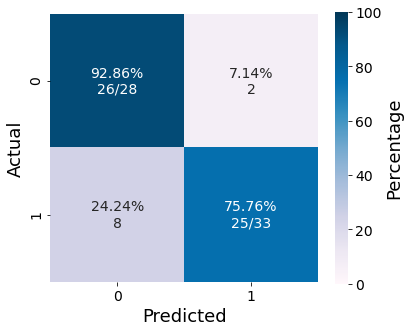

In [22]:
cm_analysis(y_test, preds, labels = np.unique(preds), ymap=None, figsize=(6,5))